# $\textbf{Overview}$
This document provides instructions on running the JWST Science Calibration Pipeline (referred to as “the pipeline”) and individual pipeline steps specifically for <mark>$\textbf{Time Series Observation (TSO) Imaging with NIRCam NRC_TSIMAGE exposure data}$</mark>.

End-to-end calibration of JWST data is divided into 3 main stages of processing. Multiple pipeline modules are used for different stages of processing and for different JWST observing modes. The modules are broken into the following 3 stages:

- $\textbf{Stage 1}$: Detector-level corrections and ramp fitting for individual exposures

- $\textbf{Stage 2}$: Instrument-mode calibrations for individual exposures

- $\textbf{Stage 3}$: Combining data from multiple exposures within an observation

$\textbf{Stage 1}$ corrections are applied nearly universally for all instruments and modes. $\textbf{Stage 2}$ is divided into separate modules for <mark>$\textbf{imaging}$</mark> and spectroscopic modes. $\textbf{Stage 3}$ is divided into five separate modules for imaging, spectroscopic, coronagraphic, Aperture Masking Interferometry (AMI), and <mark>$\textbf{Time Series Observation (TSO)}$</mark> modes.

# $\textbf{Import Library}$ 

In [2]:
import os
#os.environ['CRDS_PATH'] = '/fenrirdata1/kg_data/crds_cache/' #These pathways should be defined in your ~./bash profile. If not, you can set them within the notebook.
#os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
#os.environ['CRDS_CONTEXT']='jwst_0756.pmap' #Occasionally, the JWST CRDS pmap will be updated. Updates may break existing code. Use this command to revert to an older working verison until the issue is fixed. 
os.environ['CRDS_CONTEXT']='jwst_0803.pmap' #The newest update after this pmap has gives a bounding_box error in running stage 2


#JWST Pipeline Imports
import jwst
print(jwst.__version__) #Print what version of the pipeline you are using.

from jwst.pipeline.calwebb_detector1 import Detector1Pipeline #Stage 1
from jwst.pipeline.calwebb_image2 import Image2Pipeline #Stage 2
from jwst.pipeline.calwebb_tso3 import Tso3Pipeline #Stage 3
from jwst.associations.asn_from_list import asn_from_list #Association file imports
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

# Individual steps that make up calwebb_detector1
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst import datamodels

#General
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
import asdf
import glob
import time
import yaml
from copy import deepcopy
import pandas as pd

## ES custom pipeline
from tshirt.pipeline import phot_pipeline, analysis #tshirt specific imports
from tshirt.pipeline.instrument_specific import rowamp_sub
from splintegrate import splintegrate
import tqdm

#Modeling
import batman
from scipy.optimize import curve_fit

#Style Choice
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

1.3.1


# $\textbf{Stage 1}$
### $\textbf{Detector-level corrections and ramp fitting for individual exposures.}$
Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting.
The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.

#### $\textbf{Detector1Pipeline:}$
Apply all calibration steps to raw JWST ramps to produce a 2-D slope product. This stage takes care of basic data reduction steps, such as reference pixel correction, superbias subtraction, removal of non-linearity, and flagging of cosmic rays. In the final step in this stage of the pipeline, line-fitting is performed on each integration. A slope image is created for each integration. The steps in this stage are identical for all data.

There are two general configurations for this pipeline, depending on whether the data are to be treated as a Time Series Observation (TSO). The configuration is provided by CRDS reference file mappings and are usually set by default to always give access to the most recent reference file deliveries and selection rules. For TSO exposures, <mark>some steps are set to be skipped by default</mark>:

- The <mark>$\textbf{ipc}$</mark> step corrects a JWST exposure for interpixel capacitance by convolving with an IPC reference image.
- The <mark>$\textbf{persistence}$</mark> step. Based on a model, this step computes the number of traps that are expected to have captured or released a charge during an exposure. The released charge is proportional to the persistence signal, and this will be subtracted (group by group) from the science data. 
- The <mark>$\textbf{dq_init}$</mark> Data Quality (DQ) initialization step in the calibration pipeline populates the DQ mask for the input dataset. The MASK reference file contains pixel-by-pixel DQ flag values that indicate problem conditions.
- The <mark>$\textbf{saturation}$</mark> step flags pixels at or below the A/D floor or above the saturation threshold.
- The <mark>$\textbf{superbias}$</mark> superbias subtraction step removes the fixed detector bias from a science data set by subtracting a superbias reference image.
- The <mark>$\textbf{refpix}$</mark> step corrects for these readout signal drifts by using the reference pixels. 
- The <mark>$\textbf{linearity}$</mark> step applies the “classic” linearity correction adapted from the HST WFC3/IR linearity correction routine, correcting science data values for detector non-linearity. The correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure.
- The <mark>$\textbf{dark_current}$</mark> step removes dark current from an exposure by subtracting dark current data stored in a dark reference file in CRDS.
- The <mark>$\textbf{jump}$</mark> routine detects jumps in an exposure by looking for outliers in the up-the-ramp signal for each pixel in each integration within an input exposure.
- The <mark>$\textbf{ramp_fitting}$</mark> step determines the mean count rate, in units of counts per second, for each pixel by performing a linear fit to the data in the input file. The fit is done using the “ordinary least squares” method.

$\textbf{INPUT FILES:}$
Exposure raw data products are designated by a file name suffix of “uncal.” These files usually contain only the raw detector pixel values from an exposure, with the addition of some table extensions containing various types of meta data associated with the exposure. Additional extensions can be included for certain instruments and readout types. Below are header modifications to the "uncal" fits files.

In [3]:
#Adding header modifications
all_uncal_files = [] # All Uncalibrated File Names. Also use to check that all files have been modified by the loop. 
rawFileSearch = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/Raw_Data/*nrca3_uncal.fits' #Grabbing only nrca3 files from the directory
output_dir = "/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/"

if os.path.exists(output_dir) == False:
    os.makedirs(output_dir)
    
for fitsName in glob.glob(rawFileSearch):
    HDUList = fits.open(fitsName, 'update')
    HDUList[0].header['NOUTPUTS'] = (4, 'Number of output amplifiers') #This was not input at the time of the simulation. Therefore, we manually must input this information. 
    HDUList.close()
    all_uncal_files.append(fitsName)
    
all_uncal_files = sorted(all_uncal_files) #sort files alphabetically. 

#Required Parameters for Step1: Check the aperature size????
max_cores = "none" #"half"
photParam = {'refStarPos': [[1055,166]],'backStart':100,'backEnd': 101,
             'FITSextension': 1,
             'isCube': True,'cubePlane':0,'procFiles':'*.fits'}
seg01_len = len(glob.glob('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/splintegrate/jw01366002001_01101_00001-seg001*.fits'))

In [4]:
startTime = time.time() #Time how long this step takes

for uncal_file in all_uncal_files:
    
    # Using the run() method. Instantiate and set parameters
    #Data Quality Initialization
    dq_init_step = DQInitStep()
    dq_init = dq_init_step.run(uncal_file)
    
    # Saturation Flagging
    saturation_step = SaturationStep()
    # Call using the the output from the previously-run dq_init step
    saturation = saturation_step.run(dq_init)
    del dq_init # try to save memory
    
    # Superbias Subtraction
    superbias_step = SuperBiasStep()
    # superbias_step.output_dir = output_dir
    # superbias_step.save_results = True
    # Call using the the output from the previously-run saturation step
    superbias = superbias_step.run(saturation)
    del saturation ## try to save memory
    
    # Reference Pixel Correction
    refpix_step = RefPixStep()
    #refpix_step.output_dir = output_dir
    #refpix_step.save_results = True
    # try using a copy of the bias results as the refpix output
    # refpix = refpix_step.run(superbias)
    # es_refpix = deepcopy(refpix)
    # the old way was to run the refpix and then replace it
    es_refpix = deepcopy(superbias)
    
    ngroups = superbias.meta.exposure.ngroups
    nints = superbias.data.shape[0] ## use the array size because segmented data could have fewer ints
    
    # First, make sure that the aperture looks good. Here I have cheated and used a final rampfit result.
    phot = phot_pipeline.phot(directParam=photParam)
    #phot.showStamps(showPlot=True,boxsize=200,vmin=0,vmax=1)
    
    # Everything inside the larger blue circle will be masked when doing reference pixel corrections
    for oneInt in tqdm.tqdm(np.arange(nints)):
        for oneGroup in np.arange(ngroups):
            
            rowSub, modelImg = rowamp_sub.do_backsub(superbias.data[oneInt,oneGroup,:,:],phot)
            es_refpix.data[oneInt,oneGroup,:,:] = rowSub
            
    # Linearity Step
    del superbias # try to save memory
    linearity_step = LinearityStep()
    #Call using the the output from the previously-run refpix step
    linearity = linearity_step.run(es_refpix)
    del es_refpix # try to save memory
    
    #Persistence Step
    persist_step = PersistenceStep()
    #skip for now since ref files are zeros
    persist_step.skip = True
    #Call using the the output from the previously-run linearity step
    persist = persist_step.run(linearity)
    del linearity # try to save memory

    #Dark current step
    dark_step = DarkCurrentStep()
    # There was a CRDS error so I'm skipping
    dark_step.skip = True
    # Call using the persistence instance from the previously-run persistence step
    dark = dark_step.run(persist)
    del persist #try to save memory
    
    #Jump Step    
    jump_step = JumpStep()
    #jump_step.output_dir = output_dir
    #jump_step.save_results = True
    jump_step.rejection_threshold = 15
    jump_step.maximum_cores = max_cores
    # Call using the dark instance from the previously-run dark current subtraction step
    jump = jump_step.run(dark)
    del dark # try to save memory
    
    # Ramp Fitting    
    ramp_fit_step = RampFitStep()
    ramp_fit_step.maximum_cores = max_cores
    
    ramp_fit_step.output_dir = output_dir
    ramp_fit_step.save_results = True
    
    # Let's save the optional outputs, in order
    # to help with visualization later
    # ramp_fit_step.save_opt = True
    
    # Call using the dark instance from the previously-run jump step
    ramp_fit = ramp_fit_step.run(jump)
    del jump # try to save memory
    del ramp_fit # try to save memory
    
executionTime = (time.time() - startTime)
print('Stage 1 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2022-04-11 22:34:37,933 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2022-04-11 22:34:38,081 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/Raw_Data/jw01366002001_01101_00001-seg001_nrca3_uncal.fits',).
2022-04-11 22:34:38,084 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-04-11 22:34:47,980 - stpipe.DQInitStep - INFO - Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0058.fits
2022-04-11 22:34:53,639 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2022-04-11 22:34:53,659 - stpipe.DQInitStep - INFO - Step DQInitStep done
2022-04-11 22:34:53,662 - s

2022-04-11 22:37:48,622 - stpipe.JumpStep - INFO - CR rejection threshold = 15 sigma
2022-04-11 22:37:48,647 - stpipe.JumpStep - INFO - Using GAIN reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits
2022-04-11 22:37:48,852 - stpipe.JumpStep - INFO - Using READNOISE reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits
2022-04-11 22:37:49,047 - stpipe.JumpStep - INFO - Using 1 core for jump detection 
2022-04-11 22:37:51,999 - stpipe.JumpStep - INFO - Extracting gain subarray to match science data
2022-04-11 22:37:52,002 - stpipe.JumpStep - INFO - Extracting readnoise subarray to match science data
2022-04-11 22:37:54,552 - stpipe.JumpStep - INFO - Executing two-point difference method
2022-04-11 22:38:05,430 - stpipe.JumpStep - INFO - Working on integration 1:
2022-04-11 22:38:06,040 - stpipe.JumpStep - INFO - From highest outlier Two-point found 379 pixels with at least one CR and at least f

2022-04-11 22:38:16,525 - stpipe.JumpStep - INFO - From highest outlier Two-point found 426 pixels with at least one CR and at least four groups
2022-04-11 22:38:16,526 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:16,528 - stpipe.JumpStep - INFO - From highest outlier Two-point found 80 pixels with at least one CR and two groups
2022-04-11 22:38:16,642 - stpipe.JumpStep - INFO - Working on integration 17:
2022-04-11 22:38:17,224 - stpipe.JumpStep - INFO - From highest outlier Two-point found 370 pixels with at least one CR and at least four groups
2022-04-11 22:38:17,226 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:17,228 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 22:38:17,333 - stpipe.JumpStep - INFO - Working on integration 18:
2022-04-11 22:38

2022-04-11 22:38:27,742 - stpipe.JumpStep - INFO - Working on integration 33:
2022-04-11 22:38:28,326 - stpipe.JumpStep - INFO - From highest outlier Two-point found 405 pixels with at least one CR and at least four groups
2022-04-11 22:38:28,328 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:28,329 - stpipe.JumpStep - INFO - From highest outlier Two-point found 82 pixels with at least one CR and two groups
2022-04-11 22:38:28,436 - stpipe.JumpStep - INFO - Working on integration 34:
2022-04-11 22:38:29,019 - stpipe.JumpStep - INFO - From highest outlier Two-point found 322 pixels with at least one CR and at least four groups
2022-04-11 22:38:29,021 - stpipe.JumpStep - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups
2022-04-11 22:38:29,022 - stpipe.JumpStep - INFO - From highest outlier Two-point found 81 pixels with at least one CR and two groups
2022-04-11 22:38

2022-04-11 22:38:39,393 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 22:38:39,494 - stpipe.JumpStep - INFO - Working on integration 50:
2022-04-11 22:38:40,079 - stpipe.JumpStep - INFO - From highest outlier Two-point found 455 pixels with at least one CR and at least four groups
2022-04-11 22:38:40,081 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:40,082 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:38:40,193 - stpipe.JumpStep - INFO - Working on integration 51:
2022-04-11 22:38:40,772 - stpipe.JumpStep - INFO - From highest outlier Two-point found 405 pixels with at least one CR and at least four groups
2022-04-11 22:38:40,774 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38

2022-04-11 22:38:51,199 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:51,201 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:38:51,311 - stpipe.JumpStep - INFO - Working on integration 67:
2022-04-11 22:38:51,899 - stpipe.JumpStep - INFO - From highest outlier Two-point found 455 pixels with at least one CR and at least four groups
2022-04-11 22:38:51,900 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:38:51,902 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 22:38:52,015 - stpipe.JumpStep - INFO - Working on integration 68:
2022-04-11 22:38:52,612 - stpipe.JumpStep - INFO - From highest outlier Two-point found 418 pixels with at least one CR and at least four groups
2022-04-11 22:38

2022-04-11 22:39:03,103 - stpipe.JumpStep - INFO - From highest outlier Two-point found 367 pixels with at least one CR and at least four groups
2022-04-11 22:39:03,104 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:39:03,106 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 22:39:03,207 - stpipe.JumpStep - INFO - Working on integration 84:
2022-04-11 22:39:03,800 - stpipe.JumpStep - INFO - From highest outlier Two-point found 396 pixels with at least one CR and at least four groups
2022-04-11 22:39:03,802 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:39:03,803 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 22:39:03,912 - stpipe.JumpStep - INFO - Working on integration 85:
2022-04-11 22:39

2022-04-11 22:39:14,347 - stpipe.JumpStep - INFO - Working on integration 100:
2022-04-11 22:39:14,934 - stpipe.JumpStep - INFO - From highest outlier Two-point found 401 pixels with at least one CR and at least four groups
2022-04-11 22:39:14,937 - stpipe.JumpStep - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups
2022-04-11 22:39:14,938 - stpipe.JumpStep - INFO - From highest outlier Two-point found 80 pixels with at least one CR and two groups
2022-04-11 22:39:15,044 - stpipe.JumpStep - INFO - Working on integration 101:
2022-04-11 22:39:15,631 - stpipe.JumpStep - INFO - From highest outlier Two-point found 368 pixels with at least one CR and at least four groups
2022-04-11 22:39:15,632 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:39:15,633 - stpipe.JumpStep - INFO - From highest outlier Two-point found 75 pixels with at least one CR and two groups
2022-04-11 22:

2022-04-11 22:54:52,198 - stpipe.SaturationStep - WARNING - Keyword DEAD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 22:54:55,107 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2022-04-11 22:55:02,275 - stpipe.SaturationStep - INFO - Detected 10737 saturated pixels
2022-04-11 22:55:02,832 - stpipe.SaturationStep - INFO - Detected 0 A/D floor pixels
2022-04-11 22:55:02,838 - stpipe.SaturationStep - INFO - Step SaturationStep done
2022-04-11 22:55:02,841 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2022-04-11 22:55:03,004 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(105, 12, 256, 2048) from jw01366002001_01101_00001-seg002_nrca3_uncal.fits>,).
2022-04-11 22:55:03,007 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': F

2022-04-11 22:57:58,220 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:57:58,222 - stpipe.JumpStep - INFO - From highest outlier Two-point found 74 pixels with at least one CR and two groups
2022-04-11 22:57:58,326 - stpipe.JumpStep - INFO - Working on integration 4:
2022-04-11 22:57:58,905 - stpipe.JumpStep - INFO - From highest outlier Two-point found 416 pixels with at least one CR and at least four groups
2022-04-11 22:57:58,907 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:57:58,908 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:57:59,017 - stpipe.JumpStep - INFO - Working on integration 5:
2022-04-11 22:57:59,597 - stpipe.JumpStep - INFO - From highest outlier Two-point found 445 pixels with at least one CR and at least four groups
2022-04-11 22:57:5

2022-04-11 22:58:10,047 - stpipe.JumpStep - INFO - From highest outlier Two-point found 428 pixels with at least one CR and at least four groups
2022-04-11 22:58:10,049 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:10,050 - stpipe.JumpStep - INFO - From highest outlier Two-point found 77 pixels with at least one CR and two groups
2022-04-11 22:58:10,161 - stpipe.JumpStep - INFO - Working on integration 21:
2022-04-11 22:58:10,759 - stpipe.JumpStep - INFO - From highest outlier Two-point found 412 pixels with at least one CR and at least four groups
2022-04-11 22:58:10,762 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:10,763 - stpipe.JumpStep - INFO - From highest outlier Two-point found 77 pixels with at least one CR and two groups
2022-04-11 22:58:10,869 - stpipe.JumpStep - INFO - Working on integration 22:
2022-04-11 22:58

2022-04-11 22:58:21,324 - stpipe.JumpStep - INFO - Working on integration 37:
2022-04-11 22:58:21,916 - stpipe.JumpStep - INFO - From highest outlier Two-point found 399 pixels with at least one CR and at least four groups
2022-04-11 22:58:21,917 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:21,919 - stpipe.JumpStep - INFO - From highest outlier Two-point found 80 pixels with at least one CR and two groups
2022-04-11 22:58:22,027 - stpipe.JumpStep - INFO - Working on integration 38:
2022-04-11 22:58:22,611 - stpipe.JumpStep - INFO - From highest outlier Two-point found 416 pixels with at least one CR and at least four groups
2022-04-11 22:58:22,615 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:22,616 - stpipe.JumpStep - INFO - From highest outlier Two-point found 73 pixels with at least one CR and two groups
2022-04-11 22:58

2022-04-11 22:58:32,985 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:58:33,086 - stpipe.JumpStep - INFO - Working on integration 54:
2022-04-11 22:58:33,663 - stpipe.JumpStep - INFO - From highest outlier Two-point found 364 pixels with at least one CR and at least four groups
2022-04-11 22:58:33,665 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:33,666 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 22:58:33,766 - stpipe.JumpStep - INFO - Working on integration 55:
2022-04-11 22:58:34,348 - stpipe.JumpStep - INFO - From highest outlier Two-point found 346 pixels with at least one CR and at least four groups
2022-04-11 22:58:34,349 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58

2022-04-11 22:58:44,758 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:44,760 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:58:44,868 - stpipe.JumpStep - INFO - Working on integration 71:
2022-04-11 22:58:45,451 - stpipe.JumpStep - INFO - From highest outlier Two-point found 433 pixels with at least one CR and at least four groups
2022-04-11 22:58:45,453 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:45,454 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 22:58:45,561 - stpipe.JumpStep - INFO - Working on integration 72:
2022-04-11 22:58:46,148 - stpipe.JumpStep - INFO - From highest outlier Two-point found 333 pixels with at least one CR and at least four groups
2022-04-11 22:58

2022-04-11 22:58:56,511 - stpipe.JumpStep - INFO - From highest outlier Two-point found 389 pixels with at least one CR and at least four groups
2022-04-11 22:58:56,512 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:56,513 - stpipe.JumpStep - INFO - From highest outlier Two-point found 81 pixels with at least one CR and two groups
2022-04-11 22:58:56,621 - stpipe.JumpStep - INFO - Working on integration 88:
2022-04-11 22:58:57,204 - stpipe.JumpStep - INFO - From highest outlier Two-point found 418 pixels with at least one CR and at least four groups
2022-04-11 22:58:57,206 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:58:57,207 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 22:58:57,314 - stpipe.JumpStep - INFO - Working on integration 89:
2022-04-11 22:58

2022-04-11 22:59:07,665 - stpipe.JumpStep - INFO - Working on integration 104:
2022-04-11 22:59:08,248 - stpipe.JumpStep - INFO - From highest outlier Two-point found 369 pixels with at least one CR and at least four groups
2022-04-11 22:59:08,250 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:59:08,252 - stpipe.JumpStep - INFO - From highest outlier Two-point found 77 pixels with at least one CR and two groups
2022-04-11 22:59:08,351 - stpipe.JumpStep - INFO - Working on integration 105:
2022-04-11 22:59:08,935 - stpipe.JumpStep - INFO - From highest outlier Two-point found 379 pixels with at least one CR and at least four groups
2022-04-11 22:59:08,937 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 22:59:08,938 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 22:

2022-04-11 23:16:51,352 - stpipe.LinearityStep - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:51,354 - stpipe.LinearityStep - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:51,356 - stpipe.LinearityStep - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:51,357 - stpipe.LinearityStep - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:51,360 - stpipe.LinearityStep - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:51,361 - stpipe.LinearityStep - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored
2022-04-11 23:16:55,062 - stpipe.LinearityStep - INFO - Extracting linearity subarray to ma

2022-04-11 23:17:34,361 - stpipe.JumpStep - INFO - Working on integration 9:
2022-04-11 23:17:34,948 - stpipe.JumpStep - INFO - From highest outlier Two-point found 401 pixels with at least one CR and at least four groups
2022-04-11 23:17:34,950 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:17:34,951 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 23:17:35,060 - stpipe.JumpStep - INFO - Working on integration 10:
2022-04-11 23:17:35,646 - stpipe.JumpStep - INFO - From highest outlier Two-point found 403 pixels with at least one CR and at least four groups
2022-04-11 23:17:35,648 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:17:35,649 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 23:17:

2022-04-11 23:17:46,095 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:17:46,201 - stpipe.JumpStep - INFO - Working on integration 26:
2022-04-11 23:17:46,792 - stpipe.JumpStep - INFO - From highest outlier Two-point found 361 pixels with at least one CR and at least four groups
2022-04-11 23:17:46,794 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:17:46,795 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 23:17:46,901 - stpipe.JumpStep - INFO - Working on integration 27:
2022-04-11 23:17:47,499 - stpipe.JumpStep - INFO - From highest outlier Two-point found 356 pixels with at least one CR and at least four groups
2022-04-11 23:17:47,501 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:17

2022-04-11 23:17:58,016 - stpipe.JumpStep - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups
2022-04-11 23:17:58,017 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:17:58,132 - stpipe.JumpStep - INFO - Working on integration 43:
2022-04-11 23:17:58,732 - stpipe.JumpStep - INFO - From highest outlier Two-point found 454 pixels with at least one CR and at least four groups
2022-04-11 23:17:58,734 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:17:58,735 - stpipe.JumpStep - INFO - From highest outlier Two-point found 75 pixels with at least one CR and two groups
2022-04-11 23:17:58,850 - stpipe.JumpStep - INFO - Working on integration 44:
2022-04-11 23:17:59,443 - stpipe.JumpStep - INFO - From highest outlier Two-point found 426 pixels with at least one CR and at least four groups
2022-04-11 23:17

2022-04-11 23:18:09,908 - stpipe.JumpStep - INFO - From highest outlier Two-point found 326 pixels with at least one CR and at least four groups
2022-04-11 23:18:09,910 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:18:09,911 - stpipe.JumpStep - INFO - From highest outlier Two-point found 75 pixels with at least one CR and two groups
2022-04-11 23:18:10,007 - stpipe.JumpStep - INFO - Working on integration 60:
2022-04-11 23:18:10,590 - stpipe.JumpStep - INFO - From highest outlier Two-point found 454 pixels with at least one CR and at least four groups
2022-04-11 23:18:10,592 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:18:10,593 - stpipe.JumpStep - INFO - From highest outlier Two-point found 77 pixels with at least one CR and two groups
2022-04-11 23:18:10,708 - stpipe.JumpStep - INFO - Working on integration 61:
2022-04-11 23:18

2022-04-11 23:18:21,216 - stpipe.JumpStep - INFO - Working on integration 76:
2022-04-11 23:18:21,808 - stpipe.JumpStep - INFO - From highest outlier Two-point found 402 pixels with at least one CR and at least four groups
2022-04-11 23:18:21,810 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:18:21,811 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:18:21,917 - stpipe.JumpStep - INFO - Working on integration 77:
2022-04-11 23:18:22,507 - stpipe.JumpStep - INFO - From highest outlier Two-point found 391 pixels with at least one CR and at least four groups
2022-04-11 23:18:22,509 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:18:22,510 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:18

2022-04-11 23:18:33,027 - stpipe.JumpStep - INFO - From highest outlier Two-point found 75 pixels with at least one CR and two groups
2022-04-11 23:18:33,131 - stpipe.JumpStep - INFO - Working on integration 93:
2022-04-11 23:18:33,715 - stpipe.JumpStep - INFO - From highest outlier Two-point found 357 pixels with at least one CR and at least four groups
2022-04-11 23:18:33,717 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:18:33,718 - stpipe.JumpStep - INFO - From highest outlier Two-point found 74 pixels with at least one CR and two groups
2022-04-11 23:18:33,819 - stpipe.JumpStep - INFO - Working on integration 94:
2022-04-11 23:18:34,407 - stpipe.JumpStep - INFO - From highest outlier Two-point found 473 pixels with at least one CR and at least four groups
2022-04-11 23:18:34,409 - stpipe.JumpStep - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups
2022-04-11 23:18

2022-04-11 23:33:27,433 - stpipe.RampFitStep - INFO - Number of groups per integration: 12
2022-04-11 23:33:27,435 - stpipe.RampFitStep - INFO - Number of integrations: 105
2022-04-11 23:33:28,048 - stpipe.RampFitStep - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg003_nrca3_0_rampfitstep.fits
2022-04-11 23:33:29,541 - stpipe.RampFitStep - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg003_nrca3_1_rampfitstep.fits
2022-04-11 23:33:29,542 - stpipe.RampFitStep - INFO - Step RampFitStep done
2022-04-11 23:33:29,546 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2022-04-11 23:33:29,798 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/Raw_Data/jw01366002001_01101_00001-seg004_nrca3_uncal.fits',).
2022-04-11 23:33:29,801 - stpipe.DQInitStep - INFO

2022-04-11 23:35:00,186 - stpipe.DarkCurrentStep - INFO - Step skipped.
2022-04-11 23:35:00,189 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done
2022-04-11 23:35:00,193 - stpipe.JumpStep - INFO - JumpStep instance created.
2022-04-11 23:35:00,326 - stpipe.JumpStep - INFO - Step JumpStep running with args (<RampModel(63, 12, 256, 2048) from jw01366002001_01101_00001-seg004_nrca3_uncal.fits>,).
2022-04-11 23:35:00,329 - stpipe.JumpStep - INFO - Step JumpStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 15, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}
2022-04-11 23:35:00,351 - stp

2022-04-11 23:35:19,836 - stpipe.JumpStep - INFO - From highest outlier Two-point found 415 pixels with at least one CR and at least four groups
2022-04-11 23:35:19,837 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35:19,839 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 23:35:19,951 - stpipe.JumpStep - INFO - Working on integration 15:
2022-04-11 23:35:20,533 - stpipe.JumpStep - INFO - From highest outlier Two-point found 414 pixels with at least one CR and at least four groups
2022-04-11 23:35:20,534 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35:20,536 - stpipe.JumpStep - INFO - From highest outlier Two-point found 76 pixels with at least one CR and two groups
2022-04-11 23:35:20,645 - stpipe.JumpStep - INFO - Working on integration 16:
2022-04-11 23:35

2022-04-11 23:35:31,039 - stpipe.JumpStep - INFO - Working on integration 31:
2022-04-11 23:35:31,622 - stpipe.JumpStep - INFO - From highest outlier Two-point found 395 pixels with at least one CR and at least four groups
2022-04-11 23:35:31,624 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35:31,625 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:35:31,732 - stpipe.JumpStep - INFO - Working on integration 32:
2022-04-11 23:35:32,317 - stpipe.JumpStep - INFO - From highest outlier Two-point found 381 pixels with at least one CR and at least four groups
2022-04-11 23:35:32,319 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35:32,320 - stpipe.JumpStep - INFO - From highest outlier Two-point found 80 pixels with at least one CR and two groups
2022-04-11 23:35

2022-04-11 23:35:42,726 - stpipe.JumpStep - INFO - From highest outlier Two-point found 79 pixels with at least one CR and two groups
2022-04-11 23:35:42,822 - stpipe.JumpStep - INFO - Working on integration 48:
2022-04-11 23:35:43,407 - stpipe.JumpStep - INFO - From highest outlier Two-point found 353 pixels with at least one CR and at least four groups
2022-04-11 23:35:43,408 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35:43,409 - stpipe.JumpStep - INFO - From highest outlier Two-point found 78 pixels with at least one CR and two groups
2022-04-11 23:35:43,515 - stpipe.JumpStep - INFO - Working on integration 49:
2022-04-11 23:35:44,092 - stpipe.JumpStep - INFO - From highest outlier Two-point found 393 pixels with at least one CR and at least four groups
2022-04-11 23:35:44,094 - stpipe.JumpStep - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2022-04-11 23:35

2022-04-11 23:35:53,894 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2022-04-11 23:35:54,047 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(63, 12, 256, 2048) from jw01366002001_01101_00001-seg004_nrca3_uncal.fits>,).
2022-04-11 23:35:54,051 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
2022-04-11 23:35:54,119 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits
2022-04-11 23:35:54,147 - stpipe.RampFitStep - INFO - Using GAIN reference file

Stage 1 Execution Time in Seconds: 4182.039559602737


$\textbf{OUTPUT FILES:}$ Output files are \*rateints.fits. The pipeline creates a rate.fits and a rateint.fits files in cases where there is more than one integration in a file, but only a rate.fits file in the case where there is only one integration in a file.

In [5]:
all_rateints_files = [] # All Rateints File Names. Also used to check that all the rateints file exist.  
for fitsName in glob.glob(output_dir + '*nrca3_1_rampfitstep.fits'): #Grabbing only nrca3 files from the directory
    all_rateints_files.append(fitsName)

### $\textbf{Confirming a Source}$
Plotting one of the rateints.fits files to check that a target source is present before moving on to stage 2 and stage 3. 

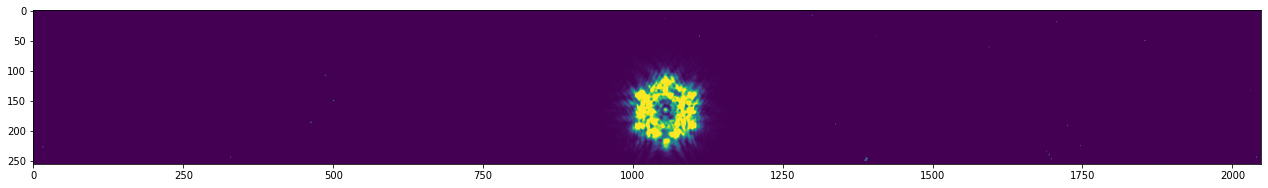

In [7]:
#A check to ensure the star is in the file
file = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg001_nrca3_1_rampfitstep.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(22,5))
ax.imshow(image2D, vmin=0, vmax=50)
#ax.plot(image2D[32,:])
#ax.set_xlim(1800,2040)

#### $\textbf{Split the Integrations for tshirt (referenced later)}$

In [8]:
#splitegrate
#Splintegrate splits and combines integrations from the pipeline up.
#Set flipToDet = False to not flip the x-axis
#This is a step required if running tshirt

#This simulation has multiple segments that need to be split for tshirt purposes.
for rateints_segment in glob.glob(output_dir + '*nrca3_1_rampfitstep.fits'): #Grabbing only nrca3 files from the directory
    outDir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/splintegrate/'
    splint = splintegrate.splint(inFile=rateints_segment,outDir=outDir,flipToDet=False)
    splint.split()

100%|███████████████████████████████████████████| 63/63 [00:01<00:00, 50.69it/s]


## $\textbf{Association Files}$
#### $\textbf{Organizing the Detector1Pipeline Output Files}$
Associations are basically just lists of things, mostly exposures, that are somehow related. An association file is a JSON-format file that contains a list of all the files with the same instrument set-up (filter, observation mode, etc) that might be combined into a single image. Relationships between multiple exposures are captured in an association, which is a means of identifying a set of exposures that belong together and may be dependent upon one another. The association concept permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

In [9]:
asn_dir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/' #Name the association file's directory. 
level2_asn = (os.path.join(asn_dir, 'nrca3_level2_asn.json')) #Name the stage 2 association file and give it a path. 
asn_stage2 = asn_from_list(all_rateints_files,rule=DMSLevel2bBase) #The rateints files; DMSLevel2bBase indicates that a Level2 association is to be created.
with open(level2_asn, 'w') as fh: #Write an association file. 
   fh.write(asn_stage2.dump()[1])

# $\textbf{Stage 2}$
### $\textbf{Processes JWST imaging-mode slope data from Level-2a to Level-2b.}$
Stage 2 processing consists of additional instrument-level and observing-mode corrections and calibrations to produce fully calibrated exposures. The details differ for imaging and spectroscopic exposures, and there are some corrections that are unique to certain instruments or modes. 

#### $\textbf{Image2Pipeline:}$
Imaging processing applies additional instrumental corrections and calibrations that result in a fully calibrated individual exposure. Imaging TSO data are run through this pipeline. The steps are very similar to those in Spec2Pipeline. WCS information is added, flat fielding and flux calibration are performed, and astrometric distortion is removed from the images. There are two parameter references used to control this pipeline, depending on whether the data are to be treated as Time Series Observation (TSO). The parameter reference is provided by CRDS. For TSO exposures, some steps are set to be skipped by default.

$\textbf{INPUT FILES:}$
The input to Image2Pipeline is a countrate exposure, in the form of either “_rate” or “_rateints” data. A single input file can be processed or an ASN file listing multiple inputs can be used, in which case the processing steps will be applied to each input exposure, one at a time. If “_rateints” products are used as input, each step applies its algorithm to each integration in the exposure, where appropriate.

In [10]:
startTime = time.time() #Time how long this step takes
#The file to use is the stage 2 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage2 = Image2Pipeline()

# Specify that you want results saved to a file
pipeline_stage2.save_results = True
pipeline_stage2.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/'

# Execute the pipeline using the run method
result_stage2 = pipeline_stage2.run(level2_asn)

executionTime = (time.time() - startTime)
print('Stage 2 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2022-04-12 16:18:32,900 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-04-12 16:18:32,907 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-04-12 16:18:32,914 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-04-12 16:18:32,919 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-04-12 16:18:32,924 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-04-12 16:18:32,930 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-04-12 16:18:35,127 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/nrca3_level2_asn.json',).
2022-04-12 16:18:35,137 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39

2022-04-12 16:18:39,231 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  217.320524177 -3.451437633 217.322441101 -3.452624952 217.331922643 -3.437433299 217.330012997 -3.436210378
2022-04-12 16:18:39,232 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  217.320524177 -3.451437633 217.322441101 -3.452624952 217.331922643 -3.437433299 217.330012997 -3.436210378
2022-04-12 16:18:39,233 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-04-12 16:18:39,362 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-04-12 16:18:39,539 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(105, 256, 2048) from jw01366002001_01101_00001-seg001_nrca3_1_rampfitstep.fits>,).
2022-04-12 16:18:39,542 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fi

2022-04-12 16:18:50,975 - stpipe.Image2Pipeline.photom - INFO -  filter: F210M
2022-04-12 16:18:50,976 - stpipe.Image2Pipeline.photom - INFO -  pupil: WLP8
2022-04-12 16:18:51,042 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-04-12 16:18:51,045 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 4.93778
2022-04-12 16:18:51,562 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-04-12 16:18:51,563 - stpipe.Image2Pipeline - INFO - Finished processing product /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg002_nrca3_1
2022-04-12 16:18:51,565 - stpipe.Image2Pipeline - INFO - Processing product /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg003_nrca3_1
2022-04-12 16:18:51,567 - stpipe.Image2Pipeline - INFO - Working on input /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg003_nrca3_1_r

2022-04-12 16:19:00,524 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  217.320524177 -3.451437633 217.322441101 -3.452624952 217.331922643 -3.437433299 217.330012997 -3.436210378
2022-04-12 16:19:00,526 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-04-12 16:19:00,634 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-04-12 16:19:00,813 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(63, 256, 2048) from jw01366002001_01101_00001-seg004_nrca3_1_rampfitstep.fits>,).
2022-04-12 16:19:00,816 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP

Stage 2 Execution Time in Seconds: 36.53781795501709


$\textbf{OUTPUT FILES:}$ The output is a fully calibrated, but unrectified, exposure, using the product type suffix “_cal” or “_calints”, depending on the type of input.

In [11]:
all_calints_files = [] # All Calibrated Data File Names. Also used to check that all the calints files exist.  
for fitsName in glob.glob(output_dir + '*nrca3_1_calints.fits'): #Grabbing only nrca3 files from the directory
    HDUList = fits.open(fitsName, 'update')
    HDUList[1].header['XREF_SCI'] = (1055, 'Aperture X reference point in SCI frame') #Fix x-position centering
    HDUList[1].header['YREF_SCI'] = (166, 'Aperture Y reference point in SCI frame') #Fix the y-position centering
    HDUList.close()
    all_calints_files.append(fitsName)
all_calints_files = sorted(all_calints_files) #sort files alphabetically. 

2022-04-12 16:19:31,003 - stpipe - WARNING - /tmp/ipykernel_1883885/2184215154.py:3: ResourceWarning: unclosed file <_io.FileIO name='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/jw01366002001_01101_00001-seg001_nrca3_1_rampfitstep.fits' mode='rb' closefd=True>
  HDUList = fits.open(fitsName, 'update')



In [12]:
#Generate an association file required for stage 3
asn_dir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/' #Name the association file's directory. 
level3_asn = (os.path.join(asn_dir, 'nrca3_level3_asn.json')) #Name the stage 3 association file and give it a path.
asn_stage3 = asn_from_list(all_calints_files, product_name ='WASP39b_SYS_nrca3_level3_asn') #The rateints files; Name the output..
with open(level3_asn, 'w') as fh: #Write an association file. 
   fh.write(asn_stage3.dump()[1])

# $\textbf{Stage 3}$
### $\textbf{Applies level 3 processing to TSO-mode data from}$
Stage 3 processing consists of routines that work with multiple exposures and in most cases produce some kind of combined product. There are unique pipeline modules for stage 3 processing of imaging, spectroscopic, coronagraphic, AMI, and TSO observations. 

#### $\textbf{Tso3Pipeline:}$
The Stage 3 TSO pipeline is to be applied to associations of calibrated TSO exposures (e.g. NIRCam TS imaging, NIRCam TS grism, NIRISS SOSS, NIRSpec BrightObj, MIRI LRS Slitless) and is used to produce calibrated time-series photometry or spectra of the source object. This is a pipeline customized for TSO data. Grism TSO data undergo outlier detection (essentially a check for any cosmic rays/transient effects that were missed in Detector1Pipeline), background subtraction, spectral extraction, and photometry. Imaging TSO data are run through outlier detection, and photometry is performed.

The logic that decides whether to apply the imaging or spectroscopy steps is based on the EXP_TYPE and TSOVISIT keyword values of the input data. Imaging steps are applied if either of the following is true:

- <mark>EXP_TYPE = ‘NRC_TSIMAGE’</mark>

- EXP_TYPE = ‘MIR_IMAGE’ and TSOVISIT = True

$\textbf{INPUT FILES:}$
The spectroscopy steps will be applied in all other cases.
The input to calwebb_tso3 is in the form of an ASN file that lists multiple exposures or exposure segments of a science target. The individual inputs should be in the form of 3D calibrated (“_calints”) products from either calwebb_image2 or calwebb_spec2 processing. 

In [13]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2022-04-12 16:20:06,820 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2022-04-12 16:20:06,828 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-04-12 16:20:06,833 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2022-04-12 16:20:06,839 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2022-04-12 16:20:06,844 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2022-04-12 16:20:07,045 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/nrca3_level3_asn.json',).
2022-04-12 16:20:07,055 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index':

2022-04-12 16:20:44,435 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA', 'save_catalog': False}
2022-04-12 16:20:45,215 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry done
2022-04-12 16:20:45,390 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry running with args (<CubeModel(105, 256, 2048) from jw01366002001_01101_00001-seg002_nrca3_1_calints.fits>,).
2022-04-12 16:20:45,393 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': 

$\textbf{OUTPUT FILES:}$ For imaging TS observations, the tso_photometry step produces a source catalog containing photometry results from all of the “_crfints” products, organized as a function of integration time stamps. This file is saved in ASCII “ecsv” format, with a product type of “_phot.” The file naming is source-based, using the output product name specified in the ASN file.

# <mark>$\textbf{Plotting Results: Unaltered}$</mark>
Initial pipeline results without altering the aperture sizes. In this particular simulation, there is an edge effect (the observation is cut off on the top and bottom). We want to see how observations that turn out this way in real life can effect the results the pipline returns. 

TSOPHOT reference files are ASDF format. An object called ‘radii’ in a TSOPHOT file defines the radii that the step needs. This object is a list of one or more dictionaries. Each such dictionary has four keys: ‘pupil’, ‘radius’, ‘radius_inner’, and ‘radius_outer’. The particular one of these dictionaries to use is selected by comparing meta.instrument.pupil with the value corresponding to ‘pupil’ in each dictionary. If an exact match is found, that dictionary will be used. If no match is found, the first dictionary with ‘pupil’: ‘ANY’ will be selected. The radii will be taken from the values of keys ‘radius’, ‘radius_inner’, and ‘radius_outer’.

The original radii parameters are: 

`radii': [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0},
  {'pupil': 'ANY', 'radius': 3.0, 'radius_inner': 4.0, 'radius_outer': 5.0}]}
  
The issue with these paramters is that our `pupil = CLEAR` therefore, it is using default `pupil = ANY`. If we plot this with tshirt, it is only capturing a small region of the target.This is also after altering the apertures to be centered. `

In [14]:
#Print the stage 3 result file with all the data
with open('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_SYS_nrca3_level3_asn_phot.ecsv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['# %ECSV 0.9']
['# ---']
['# datatype:']
['# - {name: MJD', ' datatype: float64}']
['# - {name: aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean_err', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg_err', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# meta: !!omap']
['# - {instrument: NIRCAM}']
['# - {detector: NRCA3}']
['# - {channel: SHORT}']
['# - {subarray: SUBGRISM256}']
['# - {filter: F210M}']
['# - {pupil: WLP8}']
['# - {target_name: UNKNOWN}']
['# - {xcenter: 1054}']
['# - {ycenter: 16

Pipeline Calculated Net Aperture Sum MAD (ppm): 302.5197941594104
Pipeline Calculated Net Aperture Sum std (ppm): 228.65205349448908
Median Relative Error Net Aperture Sum (ppm): 215.0293525038218
Pipeline Calculated Aperture Background std (ppm): 496.1618667436126
Median Relative Errors Aperture Background (ppm): 467.5890142769371
Pipeline Calculated Annulus Mean std (ppm): 496.161866743629
Median Relative Errors Annulus Mean (ppm): 467.5890142769371
Pipeline Calculated Annulus Sum std (ppm): 496.1618667435909
Median Relative Errors Annulus Sum (ppm): 467.5890142769371


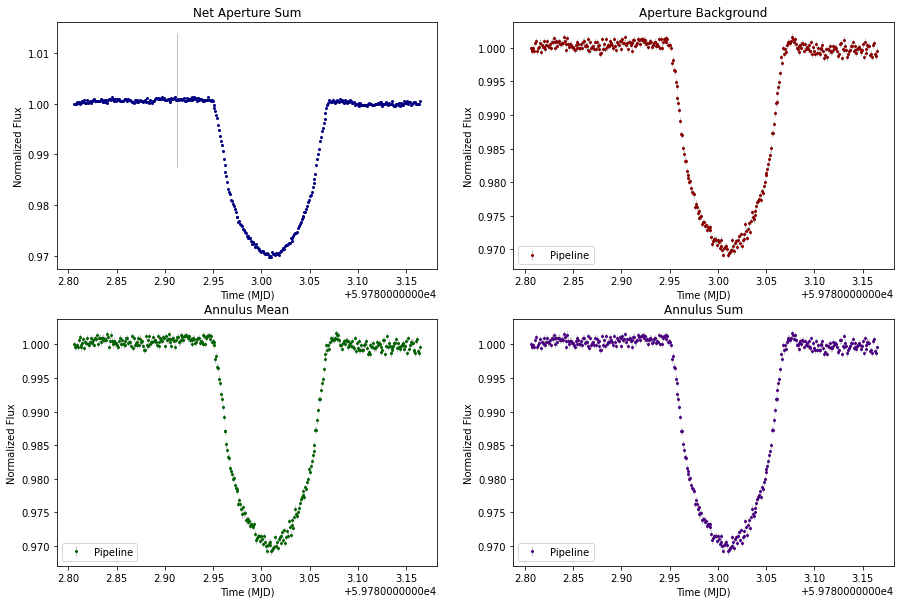

In [17]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_SYS_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)

#MAD: 
deviation = normalized_net_aperture_sum_pipeline[0:seg01_len] - np.median(normalized_net_aperture_sum_pipeline[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Pipeline Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Pipeline Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Error Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_net_aperture_sum_pipeline)*10**6)) #ppm

axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=relative_error_net_aperture_sum_pipeline,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)

print(style.BOLD+"Pipeline Calculated Aperture Background std (ppm):"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Aperture Background (ppm):"+style.END + " " +str(np.median(relative_error_aperture_bkg_pipeline)*10**6))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=relative_error_aperture_bkg_pipeline,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)

print(style.BOLD+"Pipeline Calculated Annulus Mean std (ppm):"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Mean (ppm):"+style.END + " " +str(np.median(relative_error_annulus_mean_pipeline)*10**6))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=relative_error_annulus_mean_pipeline,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)

print(style.BOLD+"Pipeline Calculated Annulus Sum std (ppm):"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Sum (ppm):"+style.END + " " +str(np.median(relative_error_annulus_sum_pipeline)*10**6))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=relative_error_annulus_sum_pipeline,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()

#### $\textbf{External method: tshirt}$

From: https://tshirt.readthedocs.io/en/latest/phot_pipeline/phot_pipeline.html

The Time Series Helper & Integration Reduction Tool (tshirt) is a general-purpose tool for time series science. Its main application is transiting exoplanet science. tshirt can:

Reduce raw data: flat field, bias subtract, gain correct, etc. Extract Spectroscopy and in our interest extract photometry. This photometric pipeline will take image data that have been reduced (using the external HAWAII-xRG method) and calculate lightcurves on the stars/sources in the field. Therefore, we can use this external method and bypass stage2 & 3 of the JWST Science Calibration Pipeline.

NOTE: yaml file values used in tshirt are pulled from jwst pipeline header information as well as the jwst pipeline stage 3 results. [e.g. `refStarPos` in yaml is pulled from the stage3 results: `xcenter`,`ycenter` values]. Currently, tshirt is using the adjusted centered positions. tshirt is also utlizing the colrow background subtraction method for comparison with the pipelines mean method. 

In [20]:
#read in yaml parameter file, a file required to run tshirt

with open("/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_WLP8_SYS_NRCA3_ROEBA_phot_pipeline.yaml", "r") as stream:
    paramfile = yaml.safe_load(stream)

paramfile

{'procFiles': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/splintegrate/jw01366002001_01101_00001-seg*.fits',
 'excludeList': None,
 'srcName': 'WASP39b_WLP8_SYS_NRCA3',
 'srcNameShort': 'NRCA3_WASP39b_SYS',
 'nightName': 'NRCA3_WASP39b_SYS_2022_07_22',
 'refStarPos': [[1055, 166]],
 'refPhotCentering': None,
 'copyCentroidFile': None,
 'srcGeometry': 'Circular',
 'bkgSub': True,
 'bkgGeometry': 'CircularAnnulus',
 'bkgMethod': 'mean',
 'apRadius': 50,
 'apHeight': None,
 'apWidth': None,
 'backStart': 60,
 'backEnd': 70,
 'backHeight': None,
 'backWidth': None,
 'backOffset': [0.0, 0.0],
 'boxFindSize': 5,
 'jdRef': 2457551,
 'timingMethod': 'JWSTint',
 'scaleAperture': False,
 'apScale': 2.5,
 'apRange': [2, 17],
 'isCube': False,
 'cubePlane': 0,
 'doCentering': True,
 'FITSextension': 0,
 'HEADextension': 0,
 'isSlope': True,
 'subpixelMethod': 'exact',
 'readNoise': 16.2,
 'detectorGain': 2.05,
 'dateFormat': 'Two Part',
 'diagnosticMode': False,
 'bkg

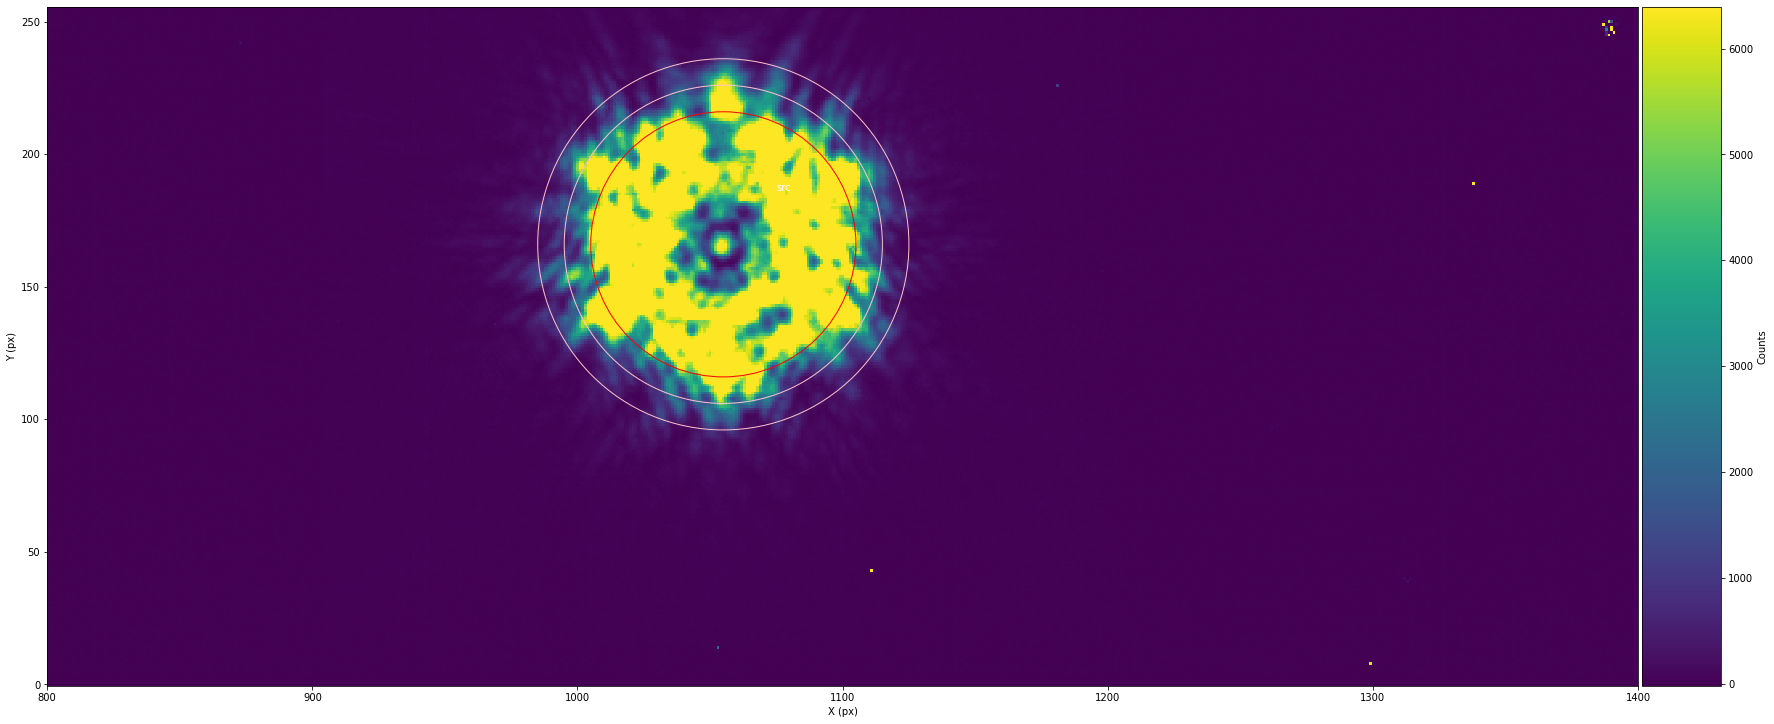

In [21]:
#Assignimg a object phot
phot = phot_pipeline.phot(paramFile="/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_WLP8_SYS_NRCA3_ROEBA_phot_pipeline.yaml") #create a photometric object
phot.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20), xLim = [800,1400]) #Plot the source and background subtraction area

In [22]:
phot.get_allimg_cen(recenter=True, useMultiprocessing=True) #recenter the centroids each time. 
phot.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                   | 0/378 [00:00<?, ?it/s]2022-04-13 01:15:35,321 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-04-13 01:15:35,524 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  0%|                                           | 1/378 [00:00<03:39,  1.72it/s]2022-04-13 01:15:35,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "



 60%|████████████████████████▌                | 227/378 [00:07<00:05, 29.14it/s]2022-04-13 01:15:43,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 86%|███████████████████████████████████▎     | 326/378 [00:10<00:01, 32.93it/s]2022-04-13 01:15:45,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 87%|███████████████████████████████████▊     | 330/378 [00:11<00:01, 30.99it/s]2022-04-13 01:15:46,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message

Tshirt Calculated Net Aperture Sum MAD (ppm): 290.97062682701846
Tshirt Calculated Net Aperture Sum std (ppm): 235.22001034267487
Median Relative Errors Net Aperture Sum (ppm): 186.7286316757589


<ErrorbarContainer object of 3 artists>

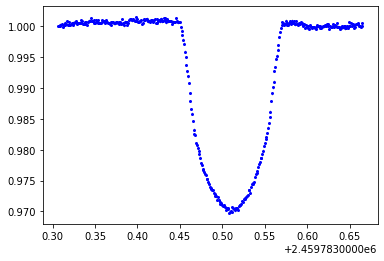

In [23]:
#Tshirt: net aperture
Flux, Flux_error = phot.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt = Flux['Flux 0']/Flux['Flux 0'][0] #normalized net aperture sum
std_tshirt = np.std(normalized_flux_tshirt[0:20]) #calculated standard deviation
relative_error_tshirt = (Flux_error['Error 0']/Flux['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt[0:seg01_len] - np.median(normalized_flux_tshirt[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt)*10**6))
plt.errorbar(Flux['Time (JD)'],normalized_flux_tshirt,yerr=relative_error_tshirt,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

# <mark>$\textbf{Plotting Results: Altered}$</mark>
Initial pipeline results with altered aperture sizes. In this particular simulation, there is an edge effect (the observation is cut off on the top and bottom). We want to see how observations that turn out this way in real life can effect the results the pipline returns. 

TSOPHOT reference files are ASDF format. An object called ‘radii’ in a TSOPHOT file defines the radii that the step needs. This object is a list of one or more dictionaries. Each such dictionary has four keys: ‘pupil’, ‘radius’, ‘radius_inner’, and ‘radius_outer’. The particular one of these dictionaries to use is selected by comparing meta.instrument.pupil with the value corresponding to ‘pupil’ in each dictionary. If an exact match is found, that dictionary will be used. If no match is found, the first dictionary with ‘pupil’: ‘ANY’ will be selected. The radii will be taken from the values of keys ‘radius’, ‘radius_inner’, and ‘radius_outer’.


NOTE: You must run these sections in order because it requires re-running stage 3 (will take a few minutes). 

# Sweep Test
Calculate the Noise Statistics for a "Sweep" of Aperture Sizes.
Loops through a series of source sizes and background sizes in a grid search.

* Step 1: Assign a photometry object with 'procFiles' limited to the first segment of the raw data. We are interested in looking at the baseline (not the transit) for statistical measurments.
* Step 2: Perform the Sweep. The important part is finiding the best source aperaute size. Therefore, the background start and backgroun end are kept at a constant interval of 20. 
* Step 3: Find the minimum MAD. 
* Step 4: Perform photometry on the best radii configuration. 

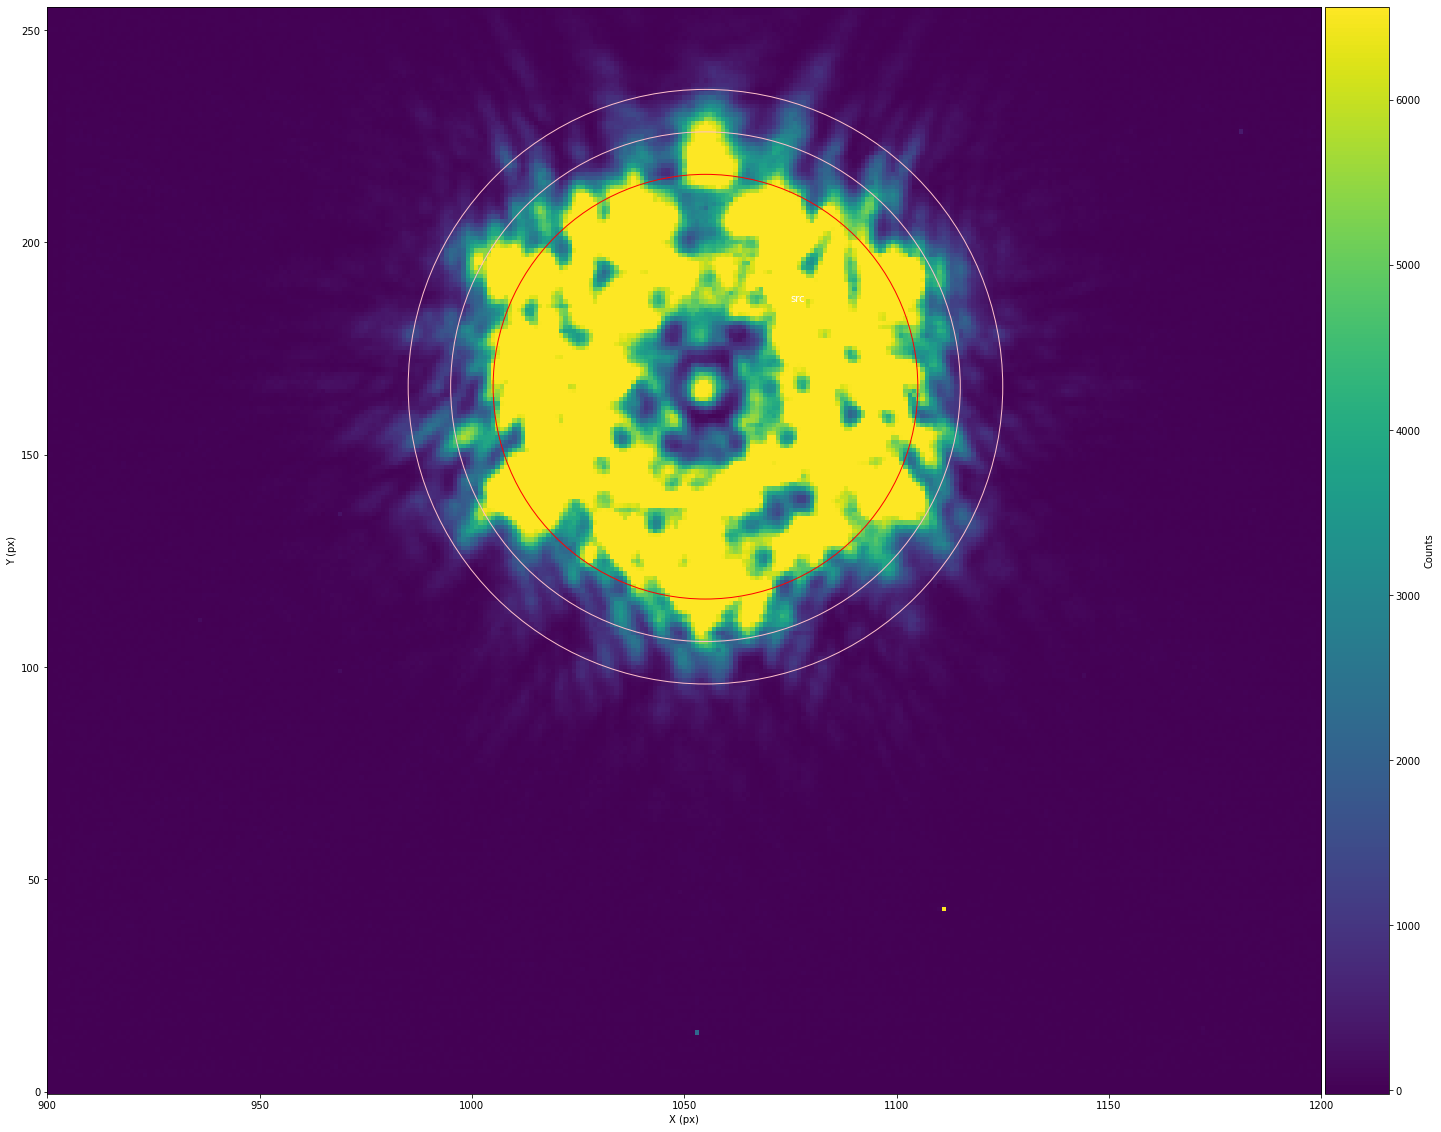

In [4]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_WLP8_SYS_NRCA3_ROEBA_phot_pipeline.yaml') #create a photometric object
alteredParam = deepcopy(phot.param)
alteredParam['procFiles'] ='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/splintegrate/jw01366002001_01101_00001-seg001*.fits'

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP39b_SYS_sweep' #provide a new name for centroid realignment

#Assignimg a object new phot_sweep
phot_sweep = phot_pipeline.phot(directParam=alteredParam) #create new photometric object
phot_sweep.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200]) #Plot the source and background subtraction area

In [25]:
phot_sweep.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot_sweep.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                   | 0/105 [00:00<?, ?it/s]2022-04-13 01:17:13,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-04-13 01:17:13,608 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  1%|▍                                          | 1/105 [00:00<01:09,  1.50it/s]2022-04-13 01:17:13,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "



## Coarse Sweep

In [26]:
sweep_analysis_coarse = analysis.aperture_size_sweep(phot_sweep,stepSize=10,srcRange=[5,150],backRange=[5,150],minBackground=10)

2022-04-13 01:17:28,413 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:528: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yStamp_proposed = np.array(onePos[1] + np.array([-1,1]) * boxsize,dtype=np.int)

2022-04-13 01:17:28,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:529: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. D

src: 5, back st: 5, back end: 15


  0%|                                                   | 0/105 [00:00<?, ?it/s]2022-04-13 01:17:29,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  1%|▍                                          | 1/105 [00:00<00:56,  1.84it/s]2022-04-13 01:17:30,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  7%|██▊                                        | 7/105 [00:00<00:07, 13.47it/s]2022-04-13 01:17:30,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message

src: 5, back st: 5, back end: 25


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.44it/s]
2022-04-13 01:17:35,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:35,232 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 280.28it/s]
2022-04-13 01:17:36,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:36,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.09it/s]
2022-04-13 01:17:36,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:36,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 267.11it/s]
2022-04-13 01:17:37,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:37,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.74it/s]
2022-04-13 01:17:38,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:38,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.45it/s]
2022-04-13 01:17:39,694 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:39,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.34it/s]
2022-04-13 01:17:40,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:40,637 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.25it/s]
2022-04-13 01:17:41,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:41,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.23it/s]
2022-04-13 01:17:42,456 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:42,487 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.90it/s]
2022-04-13 01:17:43,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:43,389 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.27it/s]
2022-04-13 01:17:44,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:44,300 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.92it/s]
2022-04-13 01:17:45,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:45,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.06it/s]
2022-04-13 01:17:46,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:46,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 25


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.07it/s]
2022-04-13 01:17:47,089 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:47,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.34it/s]
2022-04-13 01:17:47,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:48,007 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.04it/s]
2022-04-13 01:17:48,850 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:48,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 262.07it/s]
2022-04-13 01:17:49,767 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:49,797 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.86it/s]
2022-04-13 01:17:50,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:50,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 262.58it/s]
2022-04-13 01:17:51,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:51,645 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.55it/s]
2022-04-13 01:17:52,552 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:52,607 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.69it/s]
2022-04-13 01:17:53,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:53,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.48it/s]
2022-04-13 01:17:54,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:54,417 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.17it/s]
2022-04-13 01:17:55,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:55,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.75it/s]
2022-04-13 01:17:56,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:56,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.08it/s]
2022-04-13 01:17:57,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:57,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 15, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.71it/s]
2022-04-13 01:17:58,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:58,099 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.03it/s]
2022-04-13 01:17:58,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:59,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 259.31it/s]
2022-04-13 01:17:59,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:17:59,935 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.22it/s]
2022-04-13 01:18:00,794 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:00,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.39it/s]
2022-04-13 01:18:01,719 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:01,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.30it/s]
2022-04-13 01:18:02,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:02,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.80it/s]
2022-04-13 01:18:03,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:03,575 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.21it/s]
2022-04-13 01:18:04,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:04,481 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.29it/s]
2022-04-13 01:18:05,362 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:05,392 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.27it/s]
2022-04-13 01:18:06,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:06,313 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.85it/s]
2022-04-13 01:18:07,226 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:07,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.86it/s]
2022-04-13 01:18:08,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:08,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 25, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.43it/s]
2022-04-13 01:18:09,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:09,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 131.67it/s]
2022-04-13 01:18:10,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:10,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 55


100%|████████████████████████████████████████| 105/105 [00:01<00:00, 104.41it/s]
2022-04-13 01:18:11,861 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:11,907 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 65


100%|████████████████████████████████████████| 105/105 [00:01<00:00, 102.24it/s]
2022-04-13 01:18:13,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:13,746 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.32it/s]
2022-04-13 01:18:14,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:14,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.14it/s]
2022-04-13 01:18:15,466 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:15,500 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.54it/s]
2022-04-13 01:18:16,370 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:16,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.15it/s]
2022-04-13 01:18:17,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:17,295 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.45it/s]
2022-04-13 01:18:18,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:18,198 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.49it/s]
2022-04-13 01:18:19,127 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:19,158 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.87it/s]
2022-04-13 01:18:20,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:20,060 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 35, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.31it/s]
2022-04-13 01:18:20,949 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:20,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.75it/s]
2022-04-13 01:18:21,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:21,880 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.21it/s]
2022-04-13 01:18:22,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:22,782 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.59it/s]
2022-04-13 01:18:23,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:23,695 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.63it/s]
2022-04-13 01:18:24,487 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:24,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.32it/s]
2022-04-13 01:18:25,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:25,359 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.82it/s]
2022-04-13 01:18:26,189 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:26,220 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.46it/s]
2022-04-13 01:18:27,094 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:27,127 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.66it/s]
2022-04-13 01:18:27,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:28,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.31it/s]
2022-04-13 01:18:28,934 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:28,965 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 45, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.53it/s]
2022-04-13 01:18:29,893 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:29,935 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.91it/s]
2022-04-13 01:18:30,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:30,826 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.02it/s]
2022-04-13 01:18:31,685 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:31,719 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.37it/s]
2022-04-13 01:18:32,565 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:32,598 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.01it/s]
2022-04-13 01:18:33,427 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:33,460 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.34it/s]
2022-04-13 01:18:34,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:34,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.24it/s]
2022-04-13 01:18:35,117 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:35,158 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.58it/s]
2022-04-13 01:18:35,964 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:36,020 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.43it/s]
2022-04-13 01:18:36,862 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:36,914 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.03it/s]
2022-04-13 01:18:37,815 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:37,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-13 01:18:38,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:38,762 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.45it/s]
2022-04-13 01:18:39,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:39,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.76it/s]
2022-04-13 01:18:40,493 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:40,545 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.26it/s]
2022-04-13 01:18:41,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:41,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.87it/s]
2022-04-13 01:18:42,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:42,346 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.30it/s]
2022-04-13 01:18:43,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:43,291 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.55it/s]
2022-04-13 01:18:44,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:44,204 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.03it/s]
2022-04-13 01:18:45,075 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:45,112 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.80it/s]
2022-04-13 01:18:45,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:46,013 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.96it/s]
2022-04-13 01:18:46,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:46,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.53it/s]
2022-04-13 01:18:47,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:47,801 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.04it/s]
2022-04-13 01:18:48,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:48,684 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.27it/s]
2022-04-13 01:18:49,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:49,566 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.43it/s]
2022-04-13 01:18:50,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:50,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.32it/s]
2022-04-13 01:18:51,300 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:51,333 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.62it/s]
2022-04-13 01:18:52,209 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:52,243 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.16it/s]
2022-04-13 01:18:53,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:53,129 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.24it/s]
2022-04-13 01:18:53,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:53,996 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.22it/s]
2022-04-13 01:18:54,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:54,903 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.07it/s]
2022-04-13 01:18:55,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:55,800 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.82it/s]
2022-04-13 01:18:56,665 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:56,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.09it/s]
2022-04-13 01:18:57,565 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:57,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.68it/s]
2022-04-13 01:18:58,448 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:58,491 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.41it/s]
2022-04-13 01:18:59,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:18:59,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.39it/s]
2022-04-13 01:19:00,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:00,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.53it/s]
2022-04-13 01:19:01,122 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:01,170 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.66it/s]
2022-04-13 01:19:02,047 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:02,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.88it/s]
2022-04-13 01:19:02,931 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:02,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.20it/s]
2022-04-13 01:19:03,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:03,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.04it/s]
2022-04-13 01:19:04,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:04,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.06it/s]
2022-04-13 01:19:05,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:05,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.89it/s]
2022-04-13 01:19:06,498 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:06,539 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.04it/s]
2022-04-13 01:19:07,438 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:07,471 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.53it/s]
2022-04-13 01:19:08,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:08,389 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.87it/s]
2022-04-13 01:19:09,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:09,261 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.75it/s]
2022-04-13 01:19:10,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:10,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 25


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.37it/s]
2022-04-13 01:19:10,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:11,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.10it/s]
2022-04-13 01:19:11,908 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:11,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.21it/s]
2022-04-13 01:19:12,775 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:12,809 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.00it/s]
2022-04-13 01:19:13,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:13,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.28it/s]
2022-04-13 01:19:14,551 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:14,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.31it/s]
2022-04-13 01:19:15,400 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:15,455 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.09it/s]
2022-04-13 01:19:16,311 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:16,345 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.99it/s]
2022-04-13 01:19:17,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:17,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.19it/s]
2022-04-13 01:19:18,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:18,157 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.46it/s]
2022-04-13 01:19:18,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:19,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.13it/s]
2022-04-13 01:19:19,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:19,930 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.64it/s]
2022-04-13 01:19:20,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:20,833 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 15, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.52it/s]
2022-04-13 01:19:21,695 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:21,750 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.61it/s]
2022-04-13 01:19:22,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:22,639 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.04it/s]
2022-04-13 01:19:23,476 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:23,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.14it/s]
2022-04-13 01:19:24,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:24,367 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.76it/s]
2022-04-13 01:19:25,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:25,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.56it/s]
2022-04-13 01:19:26,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:26,132 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.32it/s]
2022-04-13 01:19:26,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:27,000 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.72it/s]
2022-04-13 01:19:27,883 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:27,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.41it/s]
2022-04-13 01:19:28,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:28,778 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.73it/s]
2022-04-13 01:19:29,618 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:29,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.57it/s]
2022-04-13 01:19:30,528 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:30,562 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.73it/s]
2022-04-13 01:19:31,428 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:31,459 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 25, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.30it/s]
2022-04-13 01:19:32,375 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:32,407 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.01it/s]
2022-04-13 01:19:33,208 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:33,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.14it/s]
2022-04-13 01:19:34,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:34,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.71it/s]
2022-04-13 01:19:34,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:35,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.79it/s]
2022-04-13 01:19:35,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:35,907 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.45it/s]
2022-04-13 01:19:36,773 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:36,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.06it/s]
2022-04-13 01:19:37,668 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:37,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.14it/s]
2022-04-13 01:19:38,565 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:38,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.70it/s]
2022-04-13 01:19:39,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:39,493 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.34it/s]
2022-04-13 01:19:40,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:40,381 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-13 01:19:41,267 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:41,306 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 35, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.41it/s]
2022-04-13 01:19:42,190 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:42,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.59it/s]
2022-04-13 01:19:43,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:43,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.10it/s]
2022-04-13 01:19:44,366 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:44,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 259.23it/s]
2022-04-13 01:19:45,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:45,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.21it/s]
2022-04-13 01:19:46,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:46,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.63it/s]
2022-04-13 01:19:47,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:47,113 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.27it/s]
2022-04-13 01:19:47,930 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:47,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.52it/s]
2022-04-13 01:19:48,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:48,856 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.64it/s]
2022-04-13 01:19:49,756 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:49,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.99it/s]
2022-04-13 01:19:50,637 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:50,690 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 45, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.11it/s]
2022-04-13 01:19:51,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:51,571 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.78it/s]
2022-04-13 01:19:52,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:52,447 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.34it/s]
2022-04-13 01:19:53,324 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:53,356 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.20it/s]
2022-04-13 01:19:54,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:54,263 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.59it/s]
2022-04-13 01:19:55,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:55,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.44it/s]
2022-04-13 01:19:56,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:56,054 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.33it/s]
2022-04-13 01:19:56,870 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:56,925 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.10it/s]
2022-04-13 01:19:57,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:57,841 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.34it/s]
2022-04-13 01:19:58,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:58,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.41it/s]
2022-04-13 01:19:59,648 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:19:59,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.50it/s]
2022-04-13 01:20:00,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:00,575 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.53it/s]
2022-04-13 01:20:01,421 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:01,451 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.48it/s]
2022-04-13 01:20:02,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:02,370 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.41it/s]
2022-04-13 01:20:03,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:03,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.81it/s]
2022-04-13 01:20:04,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:04,211 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.37it/s]
2022-04-13 01:20:05,106 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:05,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.97it/s]
2022-04-13 01:20:06,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:06,076 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.74it/s]
2022-04-13 01:20:06,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:06,976 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.33it/s]
2022-04-13 01:20:07,855 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:07,896 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.53it/s]
2022-04-13 01:20:08,856 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:08,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.69it/s]
2022-04-13 01:20:09,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:09,830 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.34it/s]
2022-04-13 01:20:10,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:10,734 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.37it/s]
2022-04-13 01:20:11,632 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:11,671 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.53it/s]
2022-04-13 01:20:12,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:12,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.91it/s]
2022-04-13 01:20:13,511 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:13,545 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.16it/s]
2022-04-13 01:20:14,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:14,434 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.95it/s]
2022-04-13 01:20:15,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:15,347 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.80it/s]
2022-04-13 01:20:16,211 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:16,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.63it/s]
2022-04-13 01:20:17,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:17,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.04it/s]
2022-04-13 01:20:18,081 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:18,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.75it/s]
2022-04-13 01:20:18,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:19,043 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.27it/s]
2022-04-13 01:20:19,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:19,913 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.07it/s]
2022-04-13 01:20:20,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:20,786 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.81it/s]
2022-04-13 01:20:21,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:21,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.08it/s]
2022-04-13 01:20:22,592 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:22,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.45it/s]
2022-04-13 01:20:23,512 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:23,548 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.55it/s]
2022-04-13 01:20:24,385 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:24,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.97it/s]
2022-04-13 01:20:25,296 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:25,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.12it/s]
2022-04-13 01:20:26,209 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:26,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.72it/s]
2022-04-13 01:20:27,128 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:27,172 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.55it/s]
2022-04-13 01:20:28,005 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:28,055 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.26it/s]
2022-04-13 01:20:28,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:28,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.98it/s]
2022-04-13 01:20:29,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:29,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.79it/s]
2022-04-13 01:20:30,778 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:30,813 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.90it/s]
2022-04-13 01:20:31,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:31,728 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 15, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.55it/s]
2022-04-13 01:20:32,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:32,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 35


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.02it/s]
2022-04-13 01:20:33,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:33,559 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-13 01:20:34,449 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:34,490 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.83it/s]
2022-04-13 01:20:35,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:35,384 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 65


100%|████████████████████████████████████████| 105/105 [00:01<00:00, 101.43it/s]
2022-04-13 01:20:36,865 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:36,897 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 135.15it/s]
2022-04-13 01:20:38,398 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:38,428 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.80it/s]
2022-04-13 01:20:39,245 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:39,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.49it/s]
2022-04-13 01:20:40,155 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:40,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.29it/s]
2022-04-13 01:20:41,092 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:41,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.47it/s]
2022-04-13 01:20:42,049 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:42,081 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.52it/s]
2022-04-13 01:20:42,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:42,997 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.25it/s]
2022-04-13 01:20:43,841 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:43,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 25, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.72it/s]
2022-04-13 01:20:44,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:44,798 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.12it/s]
2022-04-13 01:20:45,600 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:45,652 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.22it/s]
2022-04-13 01:20:46,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:46,531 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.48it/s]
2022-04-13 01:20:47,386 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:47,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.22it/s]
2022-04-13 01:20:48,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:48,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.33it/s]
2022-04-13 01:20:49,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:49,191 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.02it/s]
2022-04-13 01:20:50,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:50,062 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.25it/s]
2022-04-13 01:20:50,926 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:50,980 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.34it/s]
2022-04-13 01:20:51,855 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:51,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.80it/s]
2022-04-13 01:20:52,767 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:52,801 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.77it/s]
2022-04-13 01:20:53,682 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:53,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 35, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.83it/s]
2022-04-13 01:20:54,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:54,659 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.21it/s]
2022-04-13 01:20:55,482 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:55,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.50it/s]
2022-04-13 01:20:56,363 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:56,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.36it/s]
2022-04-13 01:20:57,250 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:57,280 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.84it/s]
2022-04-13 01:20:58,121 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:58,165 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.33it/s]
2022-04-13 01:20:59,021 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:59,069 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.73it/s]
2022-04-13 01:20:59,939 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:20:59,972 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.77it/s]
2022-04-13 01:21:00,826 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:00,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.44it/s]
2022-04-13 01:21:01,710 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:01,743 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.28it/s]
2022-04-13 01:21:02,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:02,626 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 45, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.92it/s]
2022-04-13 01:21:03,513 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:03,551 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.34it/s]
2022-04-13 01:21:04,452 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:04,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.35it/s]
2022-04-13 01:21:05,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:05,380 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.69it/s]
2022-04-13 01:21:06,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:06,278 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.52it/s]
2022-04-13 01:21:07,109 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:07,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.33it/s]
2022-04-13 01:21:07,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:08,008 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.68it/s]
2022-04-13 01:21:08,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:08,878 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.42it/s]
2022-04-13 01:21:09,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:09,775 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.30it/s]
2022-04-13 01:21:10,649 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:10,679 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.40it/s]
2022-04-13 01:21:11,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:11,594 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.30it/s]
2022-04-13 01:21:12,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:12,463 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.08it/s]
2022-04-13 01:21:13,338 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:13,370 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.41it/s]
2022-04-13 01:21:14,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:14,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.60it/s]
2022-04-13 01:21:15,100 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:15,147 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.24it/s]
2022-04-13 01:21:16,011 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:16,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.72it/s]
2022-04-13 01:21:16,919 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:16,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.85it/s]
2022-04-13 01:21:17,862 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:17,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.66it/s]
2022-04-13 01:21:18,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:18,790 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.15it/s]
2022-04-13 01:21:19,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:19,691 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.43it/s]
2022-04-13 01:21:20,535 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:20,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.54it/s]
2022-04-13 01:21:21,390 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:21,437 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.39it/s]
2022-04-13 01:21:22,333 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:22,367 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.30it/s]
2022-04-13 01:21:23,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:23,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.28it/s]
2022-04-13 01:21:24,103 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:24,137 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.98it/s]
2022-04-13 01:21:25,008 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:25,050 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.55it/s]
2022-04-13 01:21:25,885 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:25,924 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.21it/s]
2022-04-13 01:21:26,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:26,772 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.95it/s]
2022-04-13 01:21:27,697 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:27,728 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.40it/s]
2022-04-13 01:21:28,573 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:28,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.05it/s]
2022-04-13 01:21:29,508 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:29,541 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.26it/s]
2022-04-13 01:21:30,395 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:30,449 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.83it/s]
2022-04-13 01:21:31,306 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:31,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.57it/s]
2022-04-13 01:21:32,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:32,267 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.99it/s]
2022-04-13 01:21:33,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:33,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.24it/s]
2022-04-13 01:21:33,994 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:34,038 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.31it/s]
2022-04-13 01:21:34,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:34,967 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.31it/s]
2022-04-13 01:21:35,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:35,877 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.95it/s]
2022-04-13 01:21:36,766 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:36,802 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.91it/s]
2022-04-13 01:21:37,645 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:37,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.39it/s]
2022-04-13 01:21:38,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:38,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.60it/s]
2022-04-13 01:21:39,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:39,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.15it/s]
2022-04-13 01:21:40,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:40,435 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.69it/s]
2022-04-13 01:21:41,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:41,342 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.43it/s]
2022-04-13 01:21:42,247 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:42,283 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.61it/s]
2022-04-13 01:21:43,197 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:43,231 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 25, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.20it/s]
2022-04-13 01:21:44,147 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:44,180 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 45


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.24it/s]
2022-04-13 01:21:44,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:45,035 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.82it/s]
2022-04-13 01:21:45,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:45,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.79it/s]
2022-04-13 01:21:46,777 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:46,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.72it/s]
2022-04-13 01:21:47,631 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:47,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.62it/s]
2022-04-13 01:21:48,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:48,638 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.67it/s]
2022-04-13 01:21:49,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:49,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.71it/s]
2022-04-13 01:21:50,373 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:50,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.12it/s]
2022-04-13 01:21:51,234 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:51,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.73it/s]
2022-04-13 01:21:52,102 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:52,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.39it/s]
2022-04-13 01:21:52,994 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:53,050 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 35, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.76it/s]
2022-04-13 01:21:53,937 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:53,969 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.62it/s]
2022-04-13 01:21:54,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:54,832 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.94it/s]
2022-04-13 01:21:55,706 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:55,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.95it/s]
2022-04-13 01:21:56,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:56,627 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.38it/s]
2022-04-13 01:21:57,475 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:57,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.15it/s]
2022-04-13 01:21:58,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:58,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.63it/s]
2022-04-13 01:21:59,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:21:59,300 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.34it/s]
2022-04-13 01:22:00,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:00,217 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.36it/s]
2022-04-13 01:22:01,085 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:01,114 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.90it/s]
2022-04-13 01:22:02,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:02,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 45, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.06it/s]
2022-04-13 01:22:02,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:02,959 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.08it/s]
2022-04-13 01:22:03,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:03,813 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.68it/s]
2022-04-13 01:22:04,668 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:04,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.74it/s]
2022-04-13 01:22:05,539 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:05,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.11it/s]
2022-04-13 01:22:06,416 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:06,465 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.17it/s]
2022-04-13 01:22:07,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:07,424 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.62it/s]
2022-04-13 01:22:08,313 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:08,360 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.81it/s]
2022-04-13 01:22:09,407 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:09,445 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.44it/s]
2022-04-13 01:22:10,363 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:10,417 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.23it/s]
2022-04-13 01:22:11,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:11,382 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.82it/s]
2022-04-13 01:22:12,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:12,349 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.12it/s]
2022-04-13 01:22:13,188 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:13,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.91it/s]
2022-04-13 01:22:14,151 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:14,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.52it/s]
2022-04-13 01:22:15,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:15,124 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.83it/s]
2022-04-13 01:22:16,036 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:16,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.18it/s]
2022-04-13 01:22:16,985 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:17,023 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.06it/s]
2022-04-13 01:22:17,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:17,905 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.46it/s]
2022-04-13 01:22:18,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:18,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.28it/s]
2022-04-13 01:22:19,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:19,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.20it/s]
2022-04-13 01:22:20,589 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:20,639 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.65it/s]
2022-04-13 01:22:21,564 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:21,602 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.24it/s]
2022-04-13 01:22:22,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:22,575 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.91it/s]
2022-04-13 01:22:23,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:23,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.83it/s]
2022-04-13 01:22:24,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:24,500 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.64it/s]
2022-04-13 01:22:25,403 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:25,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.83it/s]
2022-04-13 01:22:26,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:26,376 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.64it/s]
2022-04-13 01:22:27,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:27,309 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.58it/s]
2022-04-13 01:22:28,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:28,223 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.07it/s]
2022-04-13 01:22:29,106 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:29,140 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.92it/s]
2022-04-13 01:22:30,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:30,066 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.47it/s]
2022-04-13 01:22:31,009 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:31,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.14it/s]
2022-04-13 01:22:31,907 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:31,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.43it/s]
2022-04-13 01:22:32,831 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:32,870 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 95, back end: 125


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 77.35it/s]
2022-04-13 01:22:34,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:34,722 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.99it/s]
2022-04-13 01:22:35,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:35,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.39it/s]
2022-04-13 01:22:36,502 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:36,572 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.82it/s]
2022-04-13 01:22:37,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:37,491 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.92it/s]
2022-04-13 01:22:38,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:38,433 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.44it/s]
2022-04-13 01:22:39,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:39,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.84it/s]
2022-04-13 01:22:40,256 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:40,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.33it/s]
2022-04-13 01:22:41,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:41,202 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.62it/s]
2022-04-13 01:22:42,111 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:42,163 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.13it/s]
2022-04-13 01:22:43,021 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:43,068 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.13it/s]
2022-04-13 01:22:43,973 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:44,009 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.17it/s]
2022-04-13 01:22:44,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:44,924 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 35, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.88it/s]
2022-04-13 01:22:45,802 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:45,844 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 55


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.84it/s]
2022-04-13 01:22:46,703 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:46,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.21it/s]
2022-04-13 01:22:47,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:47,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.93it/s]
2022-04-13 01:22:48,421 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:48,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.19it/s]
2022-04-13 01:22:49,305 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:49,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.46it/s]
2022-04-13 01:22:50,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:50,230 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.56it/s]
2022-04-13 01:22:51,114 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:51,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.34it/s]
2022-04-13 01:22:51,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:52,034 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.61it/s]
2022-04-13 01:22:52,867 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:52,909 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.04it/s]
2022-04-13 01:22:53,769 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:53,804 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 45, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.28it/s]
2022-04-13 01:22:54,679 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:54,727 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.86it/s]
2022-04-13 01:22:55,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:55,637 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.09it/s]
2022-04-13 01:22:56,473 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:56,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.16it/s]
2022-04-13 01:22:57,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:57,390 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.33it/s]
2022-04-13 01:22:58,261 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:58,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.00it/s]
2022-04-13 01:22:59,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:22:59,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.82it/s]
2022-04-13 01:23:00,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:00,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.14it/s]
2022-04-13 01:23:01,019 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:01,056 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.26it/s]
2022-04-13 01:23:01,967 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:02,005 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.49it/s]
2022-04-13 01:23:02,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:02,914 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.41it/s]
2022-04-13 01:23:03,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:03,799 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.35it/s]
2022-04-13 01:23:04,659 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:04,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.43it/s]
2022-04-13 01:23:05,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:05,621 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.47it/s]
2022-04-13 01:23:06,492 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:06,537 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.96it/s]
2022-04-13 01:23:07,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:07,485 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.17it/s]
2022-04-13 01:23:08,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:08,450 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.50it/s]
2022-04-13 01:23:09,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:09,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.35it/s]
2022-04-13 01:23:10,296 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:10,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.63it/s]
2022-04-13 01:23:11,223 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:11,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.48it/s]
2022-04-13 01:23:12,165 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:12,203 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.92it/s]
2022-04-13 01:23:13,090 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:13,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.06it/s]
2022-04-13 01:23:14,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:14,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.04it/s]
2022-04-13 01:23:14,958 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:15,021 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.13it/s]
2022-04-13 01:23:15,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:15,916 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.82it/s]
2022-04-13 01:23:16,807 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:16,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.52it/s]
2022-04-13 01:23:17,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:17,758 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.34it/s]
2022-04-13 01:23:18,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:18,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.83it/s]
2022-04-13 01:23:19,500 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:19,555 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.03it/s]
2022-04-13 01:23:20,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:20,465 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.30it/s]
2022-04-13 01:23:21,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:21,362 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.37it/s]
2022-04-13 01:23:22,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:22,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.39it/s]
2022-04-13 01:23:23,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:23,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.31it/s]
2022-04-13 01:23:24,019 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:24,053 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.47it/s]
2022-04-13 01:23:24,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:24,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.42it/s]
2022-04-13 01:23:25,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:25,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.25it/s]
2022-04-13 01:23:26,866 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:26,912 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.50it/s]
2022-04-13 01:23:27,818 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:27,860 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.44it/s]
2022-04-13 01:23:28,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:28,818 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.80it/s]
2022-04-13 01:23:29,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:29,773 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.03it/s]
2022-04-13 01:23:30,681 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:30,721 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.25it/s]
2022-04-13 01:23:31,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:31,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.06it/s]
2022-04-13 01:23:32,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:32,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.49it/s]
2022-04-13 01:23:33,453 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:33,490 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.29it/s]
2022-04-13 01:23:34,377 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:34,431 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.56it/s]
2022-04-13 01:23:35,329 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:35,372 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 45, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.01it/s]
2022-04-13 01:23:36,305 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:36,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 65


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.89it/s]
2022-04-13 01:23:37,222 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:37,261 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.94it/s]
2022-04-13 01:23:38,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:38,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.34it/s]
2022-04-13 01:23:39,059 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:39,099 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.72it/s]
2022-04-13 01:23:39,985 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:40,023 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.75it/s]
2022-04-13 01:23:40,857 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:40,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.56it/s]
2022-04-13 01:23:41,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:41,809 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.19it/s]
2022-04-13 01:23:42,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:42,767 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.80it/s]
2022-04-13 01:23:43,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:43,688 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 55, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.12it/s]
2022-04-13 01:23:44,595 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:44,642 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.02it/s]
2022-04-13 01:23:45,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:45,578 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.29it/s]
2022-04-13 01:23:46,476 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:46,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.17it/s]
2022-04-13 01:23:47,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:47,443 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.10it/s]
2022-04-13 01:23:48,317 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:48,363 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.11it/s]
2022-04-13 01:23:49,245 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:49,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.63it/s]
2022-04-13 01:23:50,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:50,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.29it/s]
2022-04-13 01:23:51,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:51,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.97it/s]
2022-04-13 01:23:52,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:52,153 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.72it/s]
2022-04-13 01:23:53,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:53,052 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.29it/s]
2022-04-13 01:23:53,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:53,968 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.54it/s]
2022-04-13 01:23:54,849 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:54,889 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.74it/s]
2022-04-13 01:23:55,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:55,829 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.28it/s]
2022-04-13 01:23:56,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:56,750 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.05it/s]
2022-04-13 01:23:57,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:57,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.45it/s]
2022-04-13 01:23:58,659 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:58,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.59it/s]
2022-04-13 01:23:59,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:23:59,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.74it/s]
2022-04-13 01:24:00,496 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:00,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.07it/s]
2022-04-13 01:24:01,462 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:01,504 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.94it/s]
2022-04-13 01:24:02,373 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:02,407 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.19it/s]
2022-04-13 01:24:03,311 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:03,352 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.73it/s]
2022-04-13 01:24:04,273 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:04,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.73it/s]
2022-04-13 01:24:05,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:05,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.93it/s]
2022-04-13 01:24:06,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:06,110 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.00it/s]
2022-04-13 01:24:06,961 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:07,008 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.87it/s]
2022-04-13 01:24:07,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:07,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.77it/s]
2022-04-13 01:24:08,831 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:08,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.93it/s]
2022-04-13 01:24:09,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:09,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.63it/s]
2022-04-13 01:24:10,728 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:10,770 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.12it/s]
2022-04-13 01:24:11,639 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:11,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.53it/s]
2022-04-13 01:24:12,553 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:12,607 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.23it/s]
2022-04-13 01:24:13,446 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:13,489 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.27it/s]
2022-04-13 01:24:14,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:14,425 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.66it/s]
2022-04-13 01:24:15,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:15,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.46it/s]
2022-04-13 01:24:16,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:16,332 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.20it/s]
2022-04-13 01:24:17,309 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:17,345 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 55, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.06it/s]
2022-04-13 01:24:18,243 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:18,286 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.54it/s]
2022-04-13 01:24:19,142 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:19,187 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.88it/s]
2022-04-13 01:24:20,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:20,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.87it/s]
2022-04-13 01:24:20,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:20,968 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.76it/s]
2022-04-13 01:24:21,859 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:21,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.58it/s]
2022-04-13 01:24:22,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:22,864 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.57it/s]
2022-04-13 01:24:23,796 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:23,842 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.14it/s]
2022-04-13 01:24:24,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:24,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 65, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.67it/s]
2022-04-13 01:24:25,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:25,732 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.42it/s]
2022-04-13 01:24:26,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:26,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.83it/s]
2022-04-13 01:24:27,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:27,590 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.38it/s]
2022-04-13 01:24:28,465 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:28,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.17it/s]
2022-04-13 01:24:29,425 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:29,471 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.89it/s]
2022-04-13 01:24:30,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:30,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 135


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 70.69it/s]
2022-04-13 01:24:32,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:32,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.90it/s]
2022-04-13 01:24:33,306 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:33,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.73it/s]
2022-04-13 01:24:34,230 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:34,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.10it/s]
2022-04-13 01:24:35,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:35,201 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.84it/s]
2022-04-13 01:24:36,045 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:36,080 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.01it/s]
2022-04-13 01:24:36,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:37,036 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.59it/s]
2022-04-13 01:24:37,927 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:37,983 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.43it/s]
2022-04-13 01:24:38,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:38,909 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.46it/s]
2022-04-13 01:24:39,817 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:39,851 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.01it/s]
2022-04-13 01:24:40,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:40,770 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.91it/s]
2022-04-13 01:24:41,653 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:41,690 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.06it/s]
2022-04-13 01:24:42,556 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:42,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.35it/s]
2022-04-13 01:24:43,503 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:43,538 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.32it/s]
2022-04-13 01:24:44,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:44,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.52it/s]
2022-04-13 01:24:45,274 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:45,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.63it/s]
2022-04-13 01:24:46,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:46,273 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-13 01:24:47,131 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:47,166 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.90it/s]
2022-04-13 01:24:48,060 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:48,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.63it/s]
2022-04-13 01:24:49,048 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:49,084 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.09it/s]
2022-04-13 01:24:49,975 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:50,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-13 01:24:50,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:50,953 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.94it/s]
2022-04-13 01:24:51,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:51,855 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 65, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.91it/s]
2022-04-13 01:24:52,739 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:52,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.46it/s]
2022-04-13 01:24:53,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:53,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.19it/s]
2022-04-13 01:24:54,507 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:54,546 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.98it/s]
2022-04-13 01:24:55,418 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:55,459 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.45it/s]
2022-04-13 01:24:56,324 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:56,358 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.60it/s]
2022-04-13 01:24:57,239 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:57,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.97it/s]
2022-04-13 01:24:58,151 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:58,195 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 75, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.35it/s]
2022-04-13 01:24:59,053 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:24:59,097 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.26it/s]
2022-04-13 01:24:59,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:00,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.15it/s]
2022-04-13 01:25:00,943 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:00,987 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.00it/s]
2022-04-13 01:25:01,850 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:01,892 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.02it/s]
2022-04-13 01:25:02,755 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:02,800 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.03it/s]
2022-04-13 01:25:03,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:03,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.65it/s]
2022-04-13 01:25:04,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:04,657 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.07it/s]
2022-04-13 01:25:05,529 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:05,582 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.61it/s]
2022-04-13 01:25:06,408 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:06,449 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.21it/s]
2022-04-13 01:25:07,321 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:07,361 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.72it/s]
2022-04-13 01:25:08,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:08,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.19it/s]
2022-04-13 01:25:09,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:09,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.75it/s]
2022-04-13 01:25:10,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:10,231 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.39it/s]
2022-04-13 01:25:11,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:11,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.04it/s]
2022-04-13 01:25:12,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:12,084 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.92it/s]
2022-04-13 01:25:12,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:13,018 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.68it/s]
2022-04-13 01:25:13,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:13,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.59it/s]
2022-04-13 01:25:14,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:14,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.69it/s]
2022-04-13 01:25:15,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:15,763 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.87it/s]
2022-04-13 01:25:16,651 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:16,705 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.72it/s]
2022-04-13 01:25:17,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:17,666 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 75, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.75it/s]
2022-04-13 01:25:18,588 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:18,631 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.72it/s]
2022-04-13 01:25:19,470 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:19,507 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.72it/s]
2022-04-13 01:25:20,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:20,397 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.14it/s]
2022-04-13 01:25:21,255 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:21,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.40it/s]
2022-04-13 01:25:22,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:22,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.52it/s]
2022-04-13 01:25:23,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:23,189 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 85, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.75it/s]
2022-04-13 01:25:24,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:24,095 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.91it/s]
2022-04-13 01:25:24,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:25,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.37it/s]
2022-04-13 01:25:25,872 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:25,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.98it/s]
2022-04-13 01:25:26,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:26,882 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.69it/s]
2022-04-13 01:25:27,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:27,819 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.38it/s]
2022-04-13 01:25:28,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:28,768 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.02it/s]
2022-04-13 01:25:29,632 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:29,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.14it/s]
2022-04-13 01:25:30,592 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:30,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.79it/s]
2022-04-13 01:25:31,539 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:31,594 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.10it/s]
2022-04-13 01:25:32,482 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:32,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.77it/s]
2022-04-13 01:25:33,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:33,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-13 01:25:34,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:34,403 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.02it/s]
2022-04-13 01:25:35,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:35,351 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.89it/s]
2022-04-13 01:25:36,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:36,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.31it/s]
2022-04-13 01:25:37,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:37,244 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 85, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.39it/s]
2022-04-13 01:25:38,119 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:38,157 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.08it/s]
2022-04-13 01:25:39,049 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:39,093 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.82it/s]
2022-04-13 01:25:39,967 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:40,003 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 95, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.26it/s]
2022-04-13 01:25:40,864 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:40,899 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 95, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.39it/s]
2022-04-13 01:25:41,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:41,888 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 95, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.62it/s]
2022-04-13 01:25:42,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:42,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.39it/s]
2022-04-13 01:25:43,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:43,805 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.46it/s]
2022-04-13 01:25:44,700 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:44,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.57it/s]
2022-04-13 01:25:45,646 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:45,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.31it/s]
2022-04-13 01:25:46,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:46,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.94it/s]
2022-04-13 01:25:47,525 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:47,574 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.57it/s]
2022-04-13 01:25:48,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:48,488 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.55it/s]
2022-04-13 01:25:49,424 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:49,466 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.82it/s]
2022-04-13 01:25:50,416 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:50,469 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.08it/s]
2022-04-13 01:25:51,427 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:51,463 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 95, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.06it/s]
2022-04-13 01:25:52,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:52,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.38it/s]
2022-04-13 01:25:53,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:53,334 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 105, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.30it/s]
2022-04-13 01:25:54,236 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:54,276 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 105, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.50it/s]
2022-04-13 01:25:55,165 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:55,204 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 105, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.90it/s]
2022-04-13 01:25:56,124 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:56,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.45it/s]
2022-04-13 01:25:57,085 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:57,135 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.51it/s]
2022-04-13 01:25:58,030 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:58,068 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.26it/s]
2022-04-13 01:25:58,967 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:59,006 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.84it/s]
2022-04-13 01:25:59,879 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:25:59,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.45it/s]
2022-04-13 01:26:00,854 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:00,911 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 105, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.55it/s]
2022-04-13 01:26:01,816 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:01,854 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 115, back end: 125


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.89it/s]
2022-04-13 01:26:02,752 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:02,796 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 115, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.89it/s]
2022-04-13 01:26:03,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:03,742 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 115, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.05it/s]
2022-04-13 01:26:04,660 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:04,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.48it/s]
2022-04-13 01:26:05,627 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:05,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.54it/s]
2022-04-13 01:26:06,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:06,660 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 115, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.98it/s]
2022-04-13 01:26:07,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:07,603 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 125, back st: 125, back end: 135


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.96it/s]
2022-04-13 01:26:08,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:08,556 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 125, back st: 125, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.96it/s]
2022-04-13 01:26:09,461 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:09,512 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 125, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.24it/s]
2022-04-13 01:26:10,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:10,491 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 135, back st: 135, back end: 145


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.86it/s]
2022-04-13 01:26:11,460 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-13 01:26:11,505 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



Writing table to /home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP39b_SYS_sweep_aperture_sizing_NRCA3_WASP39b_SYS_2022_07_22_src_5_150_step_10_back_5_150_step_10.csv
Min Stdev results:
src back_st back_end  stdev  theo_err mad_arr
--- ------- -------- ------- -------- -------
5.0    25.0     75.0 -5.7803  -5.4273 -3.8452


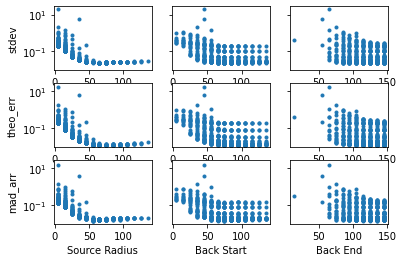

In [27]:
analysis.plot_apsizes('/home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP39b_SYS_sweep_aperture_sizing_NRCA3_WASP39b_SYS_2022_07_22_src_5_150_step_10_back_5_150_step_10.csv')

In [39]:
sweep_coarse_results = pd.read_csv('/home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP39b_SYS_sweep_aperture_sizing_NRCA3_WASP39b_SYS_2022_07_22_src_5_150_step_10_back_5_150_step_10.csv')

MAD_min_idx = abs(sweep_coarse_results[['mad_arr']]).idxmin()
print("Min MAD Results " + str(sweep_coarse_results[['mad_arr']].idxmin()))
print(sweep_coarse_results.iloc[MAD_min_idx])

print("THEO_ERR = "+str((0.0127/100)*10**6))
print("STDEV = "+str((0.0247/100)*10**6))
print("MAD*1.48 = "+str((0.0132/100)*1.48*10**6))

Min MAD Results mad_arr    31
dtype: int64
      src  back_st  back_end   stdev  theo_err  mad_arr
415  55.0     75.0     115.0  0.0247    0.0127   0.0132
THEO_ERR = 127.0
STDEV = 247.0
MAD*1.48 = 195.36


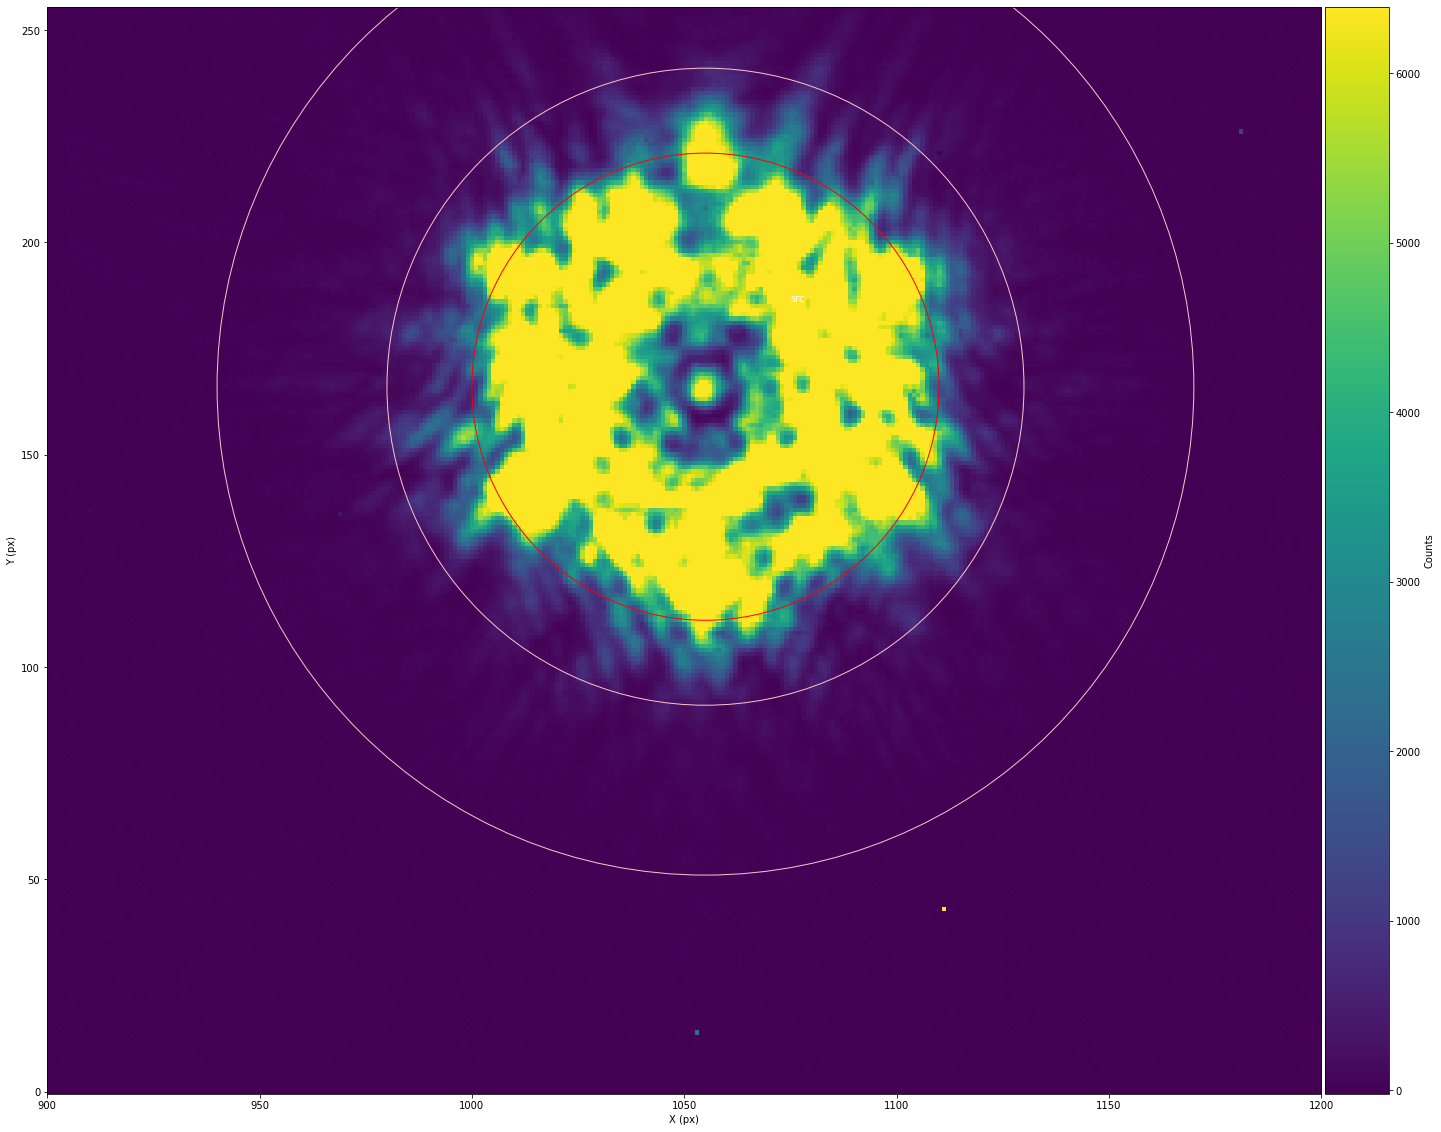

In [32]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_SYS/ROEBA/WASP39b_WLP8_SYS_NRCA3_ROEBA_phot_pipeline.yaml') #create a photometric object
alteredParam = deepcopy(phot.param)
alteredParam['backEnd'] = 115 #Changing the outer radius
alteredParam['apRadius'] = 55 #Changing the source radius
alteredParam['backStart'] = 75 #Changing the inner radius
alteredParam['bkgMethod'] ='mean'

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP39b_SYS_coarse_best' #provide a new name for centroid realignment

#Assignimg a object new phot_sweep
phot_coarse_best = phot_pipeline.phot(directParam=alteredParam) #create new photometric object
phot_coarse_best.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200]) #Plot the source and background subtraction area

In [33]:
phot_coarse_best.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot_coarse_best.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                   | 0/378 [00:00<?, ?it/s]2022-04-13 01:39:42,190 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-04-13 01:39:42,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  0%|                                           | 1/378 [00:00<03:45,  1.67it/s]2022-04-13 01:39:42,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "



 60%|████████████████████████▌                | 227/378 [00:08<00:05, 26.17it/s]2022-04-13 01:39:50,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 86%|███████████████████████████████████▏     | 324/378 [00:11<00:02, 26.56it/s]2022-04-13 01:39:53,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 87%|███████████████████████████████████▊     | 330/378 [00:11<00:01, 27.38it/s]2022-04-13 01:39:53,336 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message

Tshirt Calculated Net Aperture Sum MAD (ppm): 195.7471759171181
Tshirt Calculated Net Aperture Sum std (ppm): 189.5630412002244
Median Relative Errors Net Aperture Sum (ppm): 126.86337672036723


<ErrorbarContainer object of 3 artists>

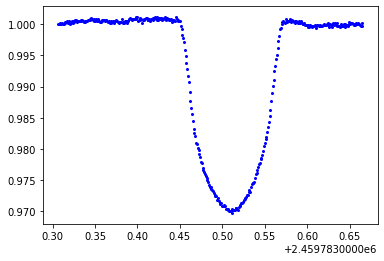

In [34]:
#Tshirt: net aperture
Flux_best, Flux_error_best = phot_coarse_best.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt_best = Flux_best['Flux 0']/Flux_best['Flux 0'][0] #normalized net aperture sum
std_tshirt_best = np.std(normalized_flux_tshirt_best[0:20]) #calculated standard deviation
relative_error_tshirt_best = (Flux_error_best['Error 0']/Flux_best['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt_best[0:seg01_len] - np.median(normalized_flux_tshirt_best[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt_best*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt_best)*10**6))

plt.errorbar(Flux_best['Time (JD)'],normalized_flux_tshirt_best,yerr=relative_error_tshirt_best,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

## Fine Sweep

In [ ]:
sweep_analysis_fine = analysis.aperture_size_sweep(phot_sweep,stepSize=1,srcRange=[50,60],backRange=[70,120],minBackground=2)

src: 50, back st: 70, back end: 72


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 167.26it/s]
2022-04-20 00:24:45,862 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:45,913 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.33it/s]
2022-04-20 00:24:46,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:46,760 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.74it/s]
2022-04-20 00:24:47,540 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:47,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.48it/s]
2022-04-20 00:24:48,365 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:48,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.48it/s]
2022-04-20 00:24:49,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:49,198 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.17it/s]
2022-04-20 00:24:49,980 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:50,025 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.76it/s]
2022-04-20 00:24:50,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:50,775 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.83it/s]
2022-04-20 00:24:51,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:51,602 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 175.32it/s]
2022-04-20 00:24:52,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:52,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.87it/s]
2022-04-20 00:24:53,439 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:53,474 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.30it/s]
2022-04-20 00:24:54,308 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:54,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.72it/s]
2022-04-20 00:24:55,128 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:55,176 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.55it/s]
2022-04-20 00:24:55,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:56,028 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.05it/s]
2022-04-20 00:24:56,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:56,802 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.90it/s]
2022-04-20 00:24:57,588 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:57,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.81it/s]
2022-04-20 00:24:58,404 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:58,455 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.98it/s]
2022-04-20 00:24:59,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:24:59,264 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.98it/s]
2022-04-20 00:25:00,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:00,115 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.96it/s]
2022-04-20 00:25:00,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:00,997 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.46it/s]
2022-04-20 00:25:01,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:01,767 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.39it/s]
2022-04-20 00:25:02,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:02,624 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.40it/s]
2022-04-20 00:25:03,481 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:03,513 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.64it/s]
2022-04-20 00:25:04,301 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:04,336 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.51it/s]
2022-04-20 00:25:05,096 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:05,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.29it/s]
2022-04-20 00:25:06,025 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:06,060 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.80it/s]
2022-04-20 00:25:06,806 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:06,865 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.34it/s]
2022-04-20 00:25:07,741 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:07,782 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.76it/s]
2022-04-20 00:25:08,508 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:08,562 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.26it/s]
2022-04-20 00:25:09,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:09,383 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.64it/s]
2022-04-20 00:25:10,113 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:10,156 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.59it/s]
2022-04-20 00:25:10,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:10,999 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.09it/s]
2022-04-20 00:25:11,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:11,782 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.27it/s]
2022-04-20 00:25:12,653 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:12,692 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.11it/s]
2022-04-20 00:25:13,394 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:13,450 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.27it/s]
2022-04-20 00:25:14,242 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:14,285 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.82it/s]
2022-04-20 00:25:15,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:15,115 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.34it/s]
2022-04-20 00:25:15,932 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:15,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.24it/s]
2022-04-20 00:25:16,732 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:16,763 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.76it/s]
2022-04-20 00:25:17,513 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:17,546 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.60it/s]
2022-04-20 00:25:18,311 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:18,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.09it/s]
2022-04-20 00:25:19,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:19,226 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.60it/s]
2022-04-20 00:25:20,007 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:20,043 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.98it/s]
2022-04-20 00:25:20,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:20,836 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.46it/s]
2022-04-20 00:25:21,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:21,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.17it/s]
2022-04-20 00:25:22,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:22,397 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.94it/s]
2022-04-20 00:25:23,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:23,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.31it/s]
2022-04-20 00:25:24,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:24,132 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 70, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.34it/s]
2022-04-20 00:25:24,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:24,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.41it/s]
2022-04-20 00:25:25,651 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:25,703 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.84it/s]
2022-04-20 00:25:26,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:26,521 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.17it/s]
2022-04-20 00:25:27,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:27,399 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.80it/s]
2022-04-20 00:25:28,192 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:28,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.24it/s]
2022-04-20 00:25:29,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:29,080 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.50it/s]
2022-04-20 00:25:29,969 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:30,002 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.51it/s]
2022-04-20 00:25:30,833 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:30,883 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.22it/s]
2022-04-20 00:25:31,734 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:31,776 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.03it/s]
2022-04-20 00:25:32,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:32,589 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.97it/s]
2022-04-20 00:25:33,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:33,487 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.92it/s]
2022-04-20 00:25:34,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:34,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.67it/s]
2022-04-20 00:25:34,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:35,032 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.61it/s]
2022-04-20 00:25:35,777 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:35,821 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.74it/s]
2022-04-20 00:25:36,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:36,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.45it/s]
2022-04-20 00:25:37,385 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:37,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.00it/s]
2022-04-20 00:25:38,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:38,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.56it/s]
2022-04-20 00:25:38,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:38,962 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.11it/s]
2022-04-20 00:25:39,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:39,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.61it/s]
2022-04-20 00:25:40,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:40,583 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.28it/s]
2022-04-20 00:25:41,365 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:41,414 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.53it/s]
2022-04-20 00:25:42,212 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:42,261 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.32it/s]
2022-04-20 00:25:43,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:43,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.14it/s]
2022-04-20 00:25:43,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:43,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.61it/s]
2022-04-20 00:25:44,697 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:44,749 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.22it/s]
2022-04-20 00:25:45,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:45,486 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.67it/s]
2022-04-20 00:25:46,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:46,288 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.37it/s]
2022-04-20 00:25:46,990 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:47,057 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.83it/s]
2022-04-20 00:25:47,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:47,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.72it/s]
2022-04-20 00:25:48,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:48,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.11it/s]
2022-04-20 00:25:49,374 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:49,409 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.00it/s]
2022-04-20 00:25:50,197 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:50,238 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.72it/s]
2022-04-20 00:25:51,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:51,050 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.47it/s]
2022-04-20 00:25:51,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:51,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.87it/s]
2022-04-20 00:25:52,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:52,578 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.55it/s]
2022-04-20 00:25:53,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:53,380 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.63it/s]
2022-04-20 00:25:54,175 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:54,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.68it/s]
2022-04-20 00:25:54,956 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:55,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.00it/s]
2022-04-20 00:25:55,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:55,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.30it/s]
2022-04-20 00:25:56,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:56,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.01it/s]
2022-04-20 00:25:57,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:57,376 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.01it/s]
2022-04-20 00:25:58,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:58,220 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.63it/s]
2022-04-20 00:25:58,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:58,997 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.30it/s]
2022-04-20 00:25:59,779 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:25:59,828 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.89it/s]
2022-04-20 00:26:00,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:00,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.59it/s]
2022-04-20 00:26:01,520 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:01,574 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.89it/s]
2022-04-20 00:26:02,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:02,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 71, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.48it/s]
2022-04-20 00:26:03,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:03,228 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.34it/s]
2022-04-20 00:26:04,036 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:04,071 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.38it/s]
2022-04-20 00:26:04,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:04,942 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.81it/s]
2022-04-20 00:26:05,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:05,718 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.36it/s]
2022-04-20 00:26:06,587 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:06,623 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.49it/s]
2022-04-20 00:26:07,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:07,408 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.83it/s]
2022-04-20 00:26:08,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:08,204 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.17it/s]
2022-04-20 00:26:08,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:08,975 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.31it/s]
2022-04-20 00:26:09,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:09,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.69it/s]
2022-04-20 00:26:10,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:10,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.89it/s]
2022-04-20 00:26:11,482 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:11,521 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.54it/s]
2022-04-20 00:26:12,276 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:12,319 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.73it/s]
2022-04-20 00:26:13,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:13,097 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.47it/s]
2022-04-20 00:26:13,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:13,865 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.64it/s]
2022-04-20 00:26:14,599 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:14,641 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.28it/s]
2022-04-20 00:26:15,427 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:15,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.21it/s]
2022-04-20 00:26:16,163 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:16,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.06it/s]
2022-04-20 00:26:16,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:16,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.42it/s]
2022-04-20 00:26:17,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:17,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.99it/s]
2022-04-20 00:26:18,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:18,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.77it/s]
2022-04-20 00:26:19,286 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:19,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.74it/s]
2022-04-20 00:26:20,075 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:20,110 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.40it/s]
2022-04-20 00:26:20,902 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:20,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.57it/s]
2022-04-20 00:26:21,767 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:21,818 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.54it/s]
2022-04-20 00:26:22,575 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:22,616 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.84it/s]
2022-04-20 00:26:23,454 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:23,494 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.10it/s]
2022-04-20 00:26:24,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:24,300 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.35it/s]
2022-04-20 00:26:25,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:25,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.33it/s]
2022-04-20 00:26:25,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:26,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.17it/s]
2022-04-20 00:26:26,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:26,819 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.45it/s]
2022-04-20 00:26:27,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:27,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.70it/s]
2022-04-20 00:26:28,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:28,767 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.17it/s]
2022-04-20 00:26:29,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:29,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.04it/s]
2022-04-20 00:26:30,363 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:30,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.42it/s]
2022-04-20 00:26:31,186 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:31,226 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.17it/s]
2022-04-20 00:26:32,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:32,064 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.60it/s]
2022-04-20 00:26:32,802 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:32,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.16it/s]
2022-04-20 00:26:33,631 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:33,675 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.18it/s]
2022-04-20 00:26:34,404 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:34,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.81it/s]
2022-04-20 00:26:35,224 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:35,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.02it/s]
2022-04-20 00:26:36,012 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:36,055 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.39it/s]
2022-04-20 00:26:36,872 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:36,913 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.67it/s]
2022-04-20 00:26:37,652 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:37,696 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.95it/s]
2022-04-20 00:26:38,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:38,571 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.61it/s]
2022-04-20 00:26:39,306 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:39,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.46it/s]
2022-04-20 00:26:40,133 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:40,183 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 72, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.26it/s]
2022-04-20 00:26:40,947 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:40,983 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.88it/s]
2022-04-20 00:26:41,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:41,833 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.91it/s]
2022-04-20 00:26:42,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:42,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.68it/s]
2022-04-20 00:26:43,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:43,507 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.03it/s]
2022-04-20 00:26:44,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:44,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.66it/s]
2022-04-20 00:26:45,181 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:45,228 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.57it/s]
2022-04-20 00:26:45,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:46,031 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.81it/s]
2022-04-20 00:26:46,849 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:46,882 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 262.22it/s]
2022-04-20 00:26:47,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:47,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.70it/s]
2022-04-20 00:26:48,468 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:48,512 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 259.79it/s]
2022-04-20 00:26:49,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:49,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.78it/s]
2022-04-20 00:26:50,059 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:50,093 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.81it/s]
2022-04-20 00:26:50,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:50,878 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.38it/s]
2022-04-20 00:26:51,627 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:51,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.70it/s]
2022-04-20 00:26:52,484 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:52,526 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.17it/s]
2022-04-20 00:26:53,431 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:53,472 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 162.91it/s]
2022-04-20 00:26:54,468 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:54,505 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 159.74it/s]
2022-04-20 00:26:55,492 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:55,541 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.09it/s]
2022-04-20 00:26:56,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:56,572 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 161.88it/s]
2022-04-20 00:26:57,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:57,615 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.93it/s]
2022-04-20 00:26:58,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:58,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.58it/s]
2022-04-20 00:26:59,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:26:59,588 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 143.04it/s]
2022-04-20 00:27:00,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:00,721 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.65it/s]
2022-04-20 00:27:01,642 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:01,695 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 174.10it/s]
2022-04-20 00:27:02,656 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:02,701 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.03it/s]
2022-04-20 00:27:03,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:03,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 143.56it/s]
2022-04-20 00:27:04,823 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:04,879 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.78it/s]
2022-04-20 00:27:05,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:06,006 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.03it/s]
2022-04-20 00:27:06,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:06,884 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.95it/s]
2022-04-20 00:27:07,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:07,897 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.37it/s]
2022-04-20 00:27:08,831 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:08,873 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 163.60it/s]
2022-04-20 00:27:09,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:09,928 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.49it/s]
2022-04-20 00:27:10,849 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:10,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.32it/s]
2022-04-20 00:27:11,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:11,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 152.55it/s]
2022-04-20 00:27:12,887 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:12,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 166.21it/s]
2022-04-20 00:27:13,900 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:13,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.16it/s]
2022-04-20 00:27:14,902 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:14,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.36it/s]
2022-04-20 00:27:15,808 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:15,852 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 170.86it/s]
2022-04-20 00:27:16,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:16,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.84it/s]
2022-04-20 00:27:17,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:17,738 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.66it/s]
2022-04-20 00:27:18,646 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:18,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 140.96it/s]
2022-04-20 00:27:19,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:19,803 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 154.00it/s]
2022-04-20 00:27:20,795 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:20,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 170.70it/s]
2022-04-20 00:27:21,847 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:21,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.51it/s]
2022-04-20 00:27:22,768 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:22,822 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 73, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.54it/s]
2022-04-20 00:27:23,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:23,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.35it/s]
2022-04-20 00:27:24,767 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:24,805 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.72it/s]
2022-04-20 00:27:25,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:25,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.57it/s]
2022-04-20 00:27:26,802 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:26,854 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 157.27it/s]
2022-04-20 00:27:27,911 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:27,968 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.86it/s]
2022-04-20 00:27:28,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:28,924 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 158.20it/s]
2022-04-20 00:27:29,931 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:29,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 166.66it/s]
2022-04-20 00:27:30,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:31,008 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 142.60it/s]
2022-04-20 00:27:32,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:32,120 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 157.20it/s]
2022-04-20 00:27:33,143 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:33,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 167.90it/s]
2022-04-20 00:27:34,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:34,196 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.36it/s]
2022-04-20 00:27:35,210 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:35,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 159.00it/s]
2022-04-20 00:27:36,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:36,361 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 117.66it/s]
2022-04-20 00:27:37,600 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:37,654 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 165.84it/s]
2022-04-20 00:27:38,643 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:38,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 147.16it/s]
2022-04-20 00:27:39,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:39,868 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 177.52it/s]
2022-04-20 00:27:40,798 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:40,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 156.82it/s]
2022-04-20 00:27:41,879 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:41,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.96it/s]
2022-04-20 00:27:42,827 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:42,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 123.11it/s]
2022-04-20 00:27:44,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:44,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.96it/s]
2022-04-20 00:27:45,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:45,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 153.21it/s]
2022-04-20 00:27:46,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:46,203 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.81it/s]
2022-04-20 00:27:47,052 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:47,096 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.98it/s]
2022-04-20 00:27:48,152 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:48,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.93it/s]
2022-04-20 00:27:49,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:49,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.63it/s]
2022-04-20 00:27:49,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:49,962 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.68it/s]
2022-04-20 00:27:50,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:50,884 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.22it/s]
2022-04-20 00:27:51,740 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:51,791 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.18it/s]
2022-04-20 00:27:52,629 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:52,660 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.67it/s]
2022-04-20 00:27:53,493 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:53,531 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.33it/s]
2022-04-20 00:27:54,414 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:54,447 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.42it/s]
2022-04-20 00:27:55,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:55,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.95it/s]
2022-04-20 00:27:56,047 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:56,091 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.45it/s]
2022-04-20 00:27:56,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:56,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.09it/s]
2022-04-20 00:27:57,700 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:57,754 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.62it/s]
2022-04-20 00:27:58,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:58,592 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.71it/s]
2022-04-20 00:27:59,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:27:59,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.01it/s]
2022-04-20 00:28:00,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:00,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.39it/s]
2022-04-20 00:28:00,946 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:00,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.22it/s]
2022-04-20 00:28:01,778 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:01,826 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.83it/s]
2022-04-20 00:28:02,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:02,626 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.87it/s]
2022-04-20 00:28:03,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:03,451 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.57it/s]
2022-04-20 00:28:04,188 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:04,218 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.84it/s]
2022-04-20 00:28:04,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:05,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 74, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.40it/s]
2022-04-20 00:28:05,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:05,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.17it/s]
2022-04-20 00:28:06,569 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:06,621 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.45it/s]
2022-04-20 00:28:07,359 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:07,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.92it/s]
2022-04-20 00:28:08,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:08,489 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.50it/s]
2022-04-20 00:28:09,279 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:09,311 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.45it/s]
2022-04-20 00:28:10,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:10,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.77it/s]
2022-04-20 00:28:10,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:10,942 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.14it/s]
2022-04-20 00:28:11,719 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:11,783 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.83it/s]
2022-04-20 00:28:12,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:12,625 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.56it/s]
2022-04-20 00:28:13,452 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:13,504 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.27it/s]
2022-04-20 00:28:14,296 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:14,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.30it/s]
2022-04-20 00:28:15,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:15,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.28it/s]
2022-04-20 00:28:15,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:15,978 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.51it/s]
2022-04-20 00:28:16,755 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:16,791 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.86it/s]
2022-04-20 00:28:17,632 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:17,670 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.38it/s]
2022-04-20 00:28:18,456 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:18,507 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.21it/s]
2022-04-20 00:28:19,301 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:19,336 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.10it/s]
2022-04-20 00:28:20,132 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:20,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.38it/s]
2022-04-20 00:28:20,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:20,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.03it/s]
2022-04-20 00:28:21,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:21,748 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.53it/s]
2022-04-20 00:28:22,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:22,579 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.50it/s]
2022-04-20 00:28:23,328 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:23,360 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.12it/s]
2022-04-20 00:28:24,144 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:24,177 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.74it/s]
2022-04-20 00:28:24,992 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:25,029 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.35it/s]
2022-04-20 00:28:25,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:25,876 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.81it/s]
2022-04-20 00:28:26,602 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:26,640 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.63it/s]
2022-04-20 00:28:27,465 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:27,508 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.68it/s]
2022-04-20 00:28:28,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:28,334 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.82it/s]
2022-04-20 00:28:29,117 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:29,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.03it/s]
2022-04-20 00:28:29,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:29,963 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.25it/s]
2022-04-20 00:28:30,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:30,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.71it/s]
2022-04-20 00:28:31,659 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:31,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.71it/s]
2022-04-20 00:28:32,490 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:32,519 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.99it/s]
2022-04-20 00:28:33,253 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:33,286 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.63it/s]
2022-04-20 00:28:34,121 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:34,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.78it/s]
2022-04-20 00:28:34,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:34,971 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.10it/s]
2022-04-20 00:28:35,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:35,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.07it/s]
2022-04-20 00:28:36,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:36,744 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.21it/s]
2022-04-20 00:28:37,548 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:37,583 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.01it/s]
2022-04-20 00:28:38,389 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:38,428 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.57it/s]
2022-04-20 00:28:39,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:39,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.95it/s]
2022-04-20 00:28:40,094 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:40,149 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.92it/s]
2022-04-20 00:28:41,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:41,055 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 75, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.97it/s]
2022-04-20 00:28:41,807 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:41,843 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.94it/s]
2022-04-20 00:28:42,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:42,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.54it/s]
2022-04-20 00:28:43,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:43,559 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.33it/s]
2022-04-20 00:28:44,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:44,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.37it/s]
2022-04-20 00:28:45,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:45,198 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.13it/s]
2022-04-20 00:28:45,922 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:45,981 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.82it/s]
2022-04-20 00:28:46,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:46,835 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.09it/s]
2022-04-20 00:28:47,565 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:47,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.73it/s]
2022-04-20 00:28:48,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:48,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.60it/s]
2022-04-20 00:28:49,251 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:49,288 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.20it/s]
2022-04-20 00:28:50,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:50,148 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.26it/s]
2022-04-20 00:28:50,910 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:50,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.69it/s]
2022-04-20 00:28:51,742 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:51,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.91it/s]
2022-04-20 00:28:52,638 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:52,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.09it/s]
2022-04-20 00:28:53,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:53,453 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.45it/s]
2022-04-20 00:28:54,325 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:54,359 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.61it/s]
2022-04-20 00:28:55,107 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:55,159 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.81it/s]
2022-04-20 00:28:55,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:56,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.17it/s]
2022-04-20 00:28:56,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:56,818 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.59it/s]
2022-04-20 00:28:57,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:57,628 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.24it/s]
2022-04-20 00:28:58,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:58,430 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.07it/s]
2022-04-20 00:28:59,308 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:28:59,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.65it/s]
2022-04-20 00:29:00,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:00,188 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.34it/s]
2022-04-20 00:29:01,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:01,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.21it/s]
2022-04-20 00:29:01,791 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:01,837 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.31it/s]
2022-04-20 00:29:02,636 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:02,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.75it/s]
2022-04-20 00:29:03,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:03,497 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.99it/s]
2022-04-20 00:29:04,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:04,411 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.01it/s]
2022-04-20 00:29:05,192 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:05,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.66it/s]
2022-04-20 00:29:05,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:06,029 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.06it/s]
2022-04-20 00:29:06,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:06,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.09it/s]
2022-04-20 00:29:07,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:07,762 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.98it/s]
2022-04-20 00:29:08,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:08,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.18it/s]
2022-04-20 00:29:09,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:09,556 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.67it/s]
2022-04-20 00:29:10,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:10,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.74it/s]
2022-04-20 00:29:11,236 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:11,276 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.21it/s]
2022-04-20 00:29:12,102 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:12,136 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.11it/s]
2022-04-20 00:29:13,090 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:13,133 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.31it/s]
2022-04-20 00:29:13,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:13,961 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.13it/s]
2022-04-20 00:29:14,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:14,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.05it/s]
2022-04-20 00:29:15,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:15,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.74it/s]
2022-04-20 00:29:16,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:16,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 76, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.69it/s]
2022-04-20 00:29:17,361 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:17,416 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.42it/s]
2022-04-20 00:29:18,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:18,256 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.60it/s]
2022-04-20 00:29:19,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:19,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.38it/s]
2022-04-20 00:29:20,005 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:20,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.23it/s]
2022-04-20 00:29:20,855 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:20,900 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.74it/s]
2022-04-20 00:29:21,690 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:21,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 84


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 96.57it/s]
2022-04-20 00:29:23,145 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:23,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.99it/s]
2022-04-20 00:29:24,004 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:24,044 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.29it/s]
2022-04-20 00:29:24,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:25,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.26it/s]
2022-04-20 00:29:25,778 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:25,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.26it/s]
2022-04-20 00:29:26,773 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:26,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.30it/s]
2022-04-20 00:29:27,608 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:27,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.70it/s]
2022-04-20 00:29:28,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:28,565 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.48it/s]
2022-04-20 00:29:29,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:29,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.91it/s]
2022-04-20 00:29:30,279 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:30,317 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.83it/s]
2022-04-20 00:29:31,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:31,126 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.32it/s]
2022-04-20 00:29:31,919 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:31,951 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.52it/s]
2022-04-20 00:29:32,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:32,787 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.20it/s]
2022-04-20 00:29:33,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:33,625 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.25it/s]
2022-04-20 00:29:34,508 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:34,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.14it/s]
2022-04-20 00:29:35,328 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:35,362 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.76it/s]
2022-04-20 00:29:36,287 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:36,330 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.72it/s]
2022-04-20 00:29:37,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:37,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.71it/s]
2022-04-20 00:29:38,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:38,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.15it/s]
2022-04-20 00:29:38,975 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:39,014 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.08it/s]
2022-04-20 00:29:39,860 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:39,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.01it/s]
2022-04-20 00:29:40,705 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:40,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.27it/s]
2022-04-20 00:29:41,588 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:41,643 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.76it/s]
2022-04-20 00:29:42,427 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:42,472 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.18it/s]
2022-04-20 00:29:43,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:43,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.42it/s]
2022-04-20 00:29:44,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:44,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.05it/s]
2022-04-20 00:29:45,075 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:45,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.21it/s]
2022-04-20 00:29:45,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:45,920 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 158.80it/s]
2022-04-20 00:29:46,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:46,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.54it/s]
2022-04-20 00:29:47,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:47,900 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.91it/s]
2022-04-20 00:29:48,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:48,820 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.21it/s]
2022-04-20 00:29:49,595 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:49,626 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.39it/s]
2022-04-20 00:29:50,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:50,568 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.43it/s]
2022-04-20 00:29:51,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:51,480 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.06it/s]
2022-04-20 00:29:52,369 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:52,422 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.29it/s]
2022-04-20 00:29:53,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:53,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 77, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.44it/s]
2022-04-20 00:29:54,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:54,191 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.10it/s]
2022-04-20 00:29:54,970 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:55,004 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.56it/s]
2022-04-20 00:29:55,857 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:55,896 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.82it/s]
2022-04-20 00:29:56,679 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:56,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.83it/s]
2022-04-20 00:29:57,600 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:57,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.07it/s]
2022-04-20 00:29:58,407 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:58,453 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.33it/s]
2022-04-20 00:29:59,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:29:59,451 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.85it/s]
2022-04-20 00:30:00,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:00,378 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.41it/s]
2022-04-20 00:30:01,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:01,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.10it/s]
2022-04-20 00:30:02,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:02,181 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.69it/s]
2022-04-20 00:30:03,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:03,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.37it/s]
2022-04-20 00:30:03,938 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:03,989 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.53it/s]
2022-04-20 00:30:04,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:04,937 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.06it/s]
2022-04-20 00:30:05,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:05,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.50it/s]
2022-04-20 00:30:06,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:06,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.57it/s]
2022-04-20 00:30:07,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:07,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.53it/s]
2022-04-20 00:30:08,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:08,554 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.88it/s]
2022-04-20 00:30:09,370 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:09,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.15it/s]
2022-04-20 00:30:10,303 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:10,336 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 134.79it/s]
2022-04-20 00:30:11,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:11,500 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.91it/s]
2022-04-20 00:30:12,288 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:12,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.22it/s]
2022-04-20 00:30:13,175 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:13,216 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.32it/s]
2022-04-20 00:30:13,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:14,040 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.11it/s]
2022-04-20 00:30:14,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:14,957 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.28it/s]
2022-04-20 00:30:15,719 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:15,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.35it/s]
2022-04-20 00:30:16,713 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:16,766 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.31it/s]
2022-04-20 00:30:17,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:17,538 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.93it/s]
2022-04-20 00:30:18,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:18,395 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.51it/s]
2022-04-20 00:30:19,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:19,225 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.53it/s]
2022-04-20 00:30:20,103 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:20,141 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.60it/s]
2022-04-20 00:30:20,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:21,006 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.18it/s]
2022-04-20 00:30:21,856 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:21,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.97it/s]
2022-04-20 00:30:22,813 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:22,852 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.30it/s]
2022-04-20 00:30:23,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:23,759 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.16it/s]
2022-04-20 00:30:24,598 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:24,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.94it/s]
2022-04-20 00:30:25,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:25,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.00it/s]
2022-04-20 00:30:26,368 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:26,417 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.34it/s]
2022-04-20 00:30:27,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:27,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.08it/s]
2022-04-20 00:30:28,103 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:28,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.59it/s]
2022-04-20 00:30:29,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:29,065 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 78, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.28it/s]
2022-04-20 00:30:29,862 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:29,899 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.74it/s]
2022-04-20 00:30:30,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:30,834 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.08it/s]
2022-04-20 00:30:31,605 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:31,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.33it/s]
2022-04-20 00:30:32,536 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:32,587 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.57it/s]
2022-04-20 00:30:33,417 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:33,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.88it/s]
2022-04-20 00:30:34,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:34,378 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.00it/s]
2022-04-20 00:30:35,180 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:35,223 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.55it/s]
2022-04-20 00:30:36,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:36,085 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.83it/s]
2022-04-20 00:30:36,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:36,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.14it/s]
2022-04-20 00:30:37,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:37,815 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.09it/s]
2022-04-20 00:30:38,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:38,644 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.35it/s]
2022-04-20 00:30:39,517 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:39,549 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 92


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 72.13it/s]
2022-04-20 00:30:41,416 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:41,454 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.68it/s]
2022-04-20 00:30:42,342 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:42,397 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.03it/s]
2022-04-20 00:30:43,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:43,233 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.41it/s]
2022-04-20 00:30:44,155 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:44,189 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.74it/s]
2022-04-20 00:30:45,061 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:45,108 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.85it/s]
2022-04-20 00:30:45,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:45,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 156.56it/s]
2022-04-20 00:30:46,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:46,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.80it/s]
2022-04-20 00:30:47,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:47,761 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.87it/s]
2022-04-20 00:30:48,692 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:48,728 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.49it/s]
2022-04-20 00:30:49,507 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:49,562 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.19it/s]
2022-04-20 00:30:50,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:50,445 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.26it/s]
2022-04-20 00:30:51,263 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:51,303 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.98it/s]
2022-04-20 00:30:52,192 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:52,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.34it/s]
2022-04-20 00:30:53,019 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:53,062 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.31it/s]
2022-04-20 00:30:54,090 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:54,149 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.41it/s]
2022-04-20 00:30:54,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:55,034 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 114.03it/s]
2022-04-20 00:30:56,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:56,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 154.99it/s]
2022-04-20 00:30:57,439 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:57,473 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 137.73it/s]
2022-04-20 00:30:58,589 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:58,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.64it/s]
2022-04-20 00:30:59,459 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:30:59,490 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 139.18it/s]
2022-04-20 00:31:00,657 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:00,692 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 118.41it/s]
2022-04-20 00:31:01,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:01,980 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.75it/s]
2022-04-20 00:31:02,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:02,857 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.70it/s]
2022-04-20 00:31:03,779 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:03,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.07it/s]
2022-04-20 00:31:04,653 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:04,693 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.19it/s]
2022-04-20 00:31:05,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:05,677 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.86it/s]
2022-04-20 00:31:06,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:06,565 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 79, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 165.34it/s]
2022-04-20 00:31:07,540 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:07,585 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.77it/s]
2022-04-20 00:31:08,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:08,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 172.64it/s]
2022-04-20 00:31:09,362 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:09,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.25it/s]
2022-04-20 00:31:10,155 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:10,188 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 177.74it/s]
2022-04-20 00:31:11,134 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:11,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.17it/s]
2022-04-20 00:31:12,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:12,057 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.89it/s]
2022-04-20 00:31:12,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:12,966 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.62it/s]
2022-04-20 00:31:13,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:13,851 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.78it/s]
2022-04-20 00:31:14,785 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:14,820 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.92it/s]
2022-04-20 00:31:15,645 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:15,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 159.63it/s]
2022-04-20 00:31:16,749 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:16,793 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.87it/s]
2022-04-20 00:31:17,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:17,636 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 175.92it/s]
2022-04-20 00:31:18,603 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:18,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 266.81it/s]
2022-04-20 00:31:19,397 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:19,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 154.05it/s]
2022-04-20 00:31:20,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:20,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.79it/s]
2022-04-20 00:31:21,335 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:21,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 152.76it/s]
2022-04-20 00:31:22,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:22,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.08it/s]
2022-04-20 00:31:23,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:23,344 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 142.18it/s]
2022-04-20 00:31:24,459 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:24,503 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.21it/s]
2022-04-20 00:31:25,286 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:25,333 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.53it/s]
2022-04-20 00:31:26,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:26,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.97it/s]
2022-04-20 00:31:27,107 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:27,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.70it/s]
2022-04-20 00:31:28,122 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:28,170 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.87it/s]
2022-04-20 00:31:29,014 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:29,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.32it/s]
2022-04-20 00:31:29,921 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:29,974 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.16it/s]
2022-04-20 00:31:30,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:30,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 165.32it/s]
2022-04-20 00:31:31,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:31,911 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.35it/s]
2022-04-20 00:31:32,863 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:32,905 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 154.75it/s]
2022-04-20 00:31:33,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:34,015 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.45it/s]
2022-04-20 00:31:34,850 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:34,887 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 177.72it/s]
2022-04-20 00:31:35,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:35,885 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.35it/s]
2022-04-20 00:31:36,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:36,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 136.29it/s]
2022-04-20 00:31:37,893 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:37,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 133.99it/s]
2022-04-20 00:31:39,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:39,109 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 116.89it/s]
2022-04-20 00:31:40,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:40,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 117.67it/s]
2022-04-20 00:31:41,641 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:41,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 144.09it/s]
2022-04-20 00:31:42,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:42,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 144.63it/s]
2022-04-20 00:31:43,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:43,936 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 80, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 123.06it/s]
2022-04-20 00:31:45,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:45,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.40it/s]
2022-04-20 00:31:46,047 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:46,102 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.19it/s]
2022-04-20 00:31:47,086 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:47,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.64it/s]
2022-04-20 00:31:47,900 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:47,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.75it/s]
2022-04-20 00:31:48,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:48,925 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.40it/s]
2022-04-20 00:31:49,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:49,800 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.63it/s]
2022-04-20 00:31:50,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:50,755 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.30it/s]
2022-04-20 00:31:51,585 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:51,622 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 145.06it/s]
2022-04-20 00:31:52,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:52,819 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.64it/s]
2022-04-20 00:31:53,644 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:53,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.34it/s]
2022-04-20 00:31:54,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:54,667 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.49it/s]
2022-04-20 00:31:55,598 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:55,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.89it/s]
2022-04-20 00:31:56,365 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:56,422 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.65it/s]
2022-04-20 00:31:57,225 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:57,275 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.24it/s]
2022-04-20 00:31:58,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:58,113 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.43it/s]
2022-04-20 00:31:59,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:59,085 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.63it/s]
2022-04-20 00:31:59,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:31:59,891 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.12it/s]
2022-04-20 00:32:00,706 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:00,743 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.59it/s]
2022-04-20 00:32:01,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:01,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.49it/s]
2022-04-20 00:32:02,441 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:02,495 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.54it/s]
2022-04-20 00:32:03,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:03,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.55it/s]
2022-04-20 00:32:04,197 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:04,238 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.88it/s]
2022-04-20 00:32:04,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:05,042 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.53it/s]
2022-04-20 00:32:05,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:05,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.54it/s]
2022-04-20 00:32:06,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:06,812 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.32it/s]
2022-04-20 00:32:07,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:07,733 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.70it/s]
2022-04-20 00:32:08,471 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:08,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.60it/s]
2022-04-20 00:32:09,335 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:09,384 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.20it/s]
2022-04-20 00:32:10,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:10,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.65it/s]
2022-04-20 00:32:10,990 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:11,044 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.46it/s]
2022-04-20 00:32:11,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:11,980 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.04it/s]
2022-04-20 00:32:12,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:12,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.42it/s]
2022-04-20 00:32:13,715 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:13,756 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.65it/s]
2022-04-20 00:32:14,612 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:14,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.85it/s]
2022-04-20 00:32:15,430 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:15,465 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.29it/s]
2022-04-20 00:32:16,289 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:16,346 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.76it/s]
2022-04-20 00:32:17,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:17,170 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 81, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.31it/s]
2022-04-20 00:32:18,115 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:18,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 268.17it/s]
2022-04-20 00:32:18,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:18,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.42it/s]
2022-04-20 00:32:19,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:19,842 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.02it/s]
2022-04-20 00:32:20,585 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:20,639 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.34it/s]
2022-04-20 00:32:21,419 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:21,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.77it/s]
2022-04-20 00:32:22,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:22,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-20 00:32:23,101 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:23,140 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.99it/s]
2022-04-20 00:32:23,888 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:23,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.85it/s]
2022-04-20 00:32:24,716 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:24,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.15it/s]
2022-04-20 00:32:25,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:25,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.74it/s]
2022-04-20 00:32:26,419 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:26,462 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.13it/s]
2022-04-20 00:32:27,243 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:27,308 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.53it/s]
2022-04-20 00:32:28,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:28,239 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.90it/s]
2022-04-20 00:32:28,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:29,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.86it/s]
2022-04-20 00:32:29,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:30,014 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.07it/s]
2022-04-20 00:32:30,779 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:30,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.34it/s]
2022-04-20 00:32:31,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:31,742 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.36it/s]
2022-04-20 00:32:32,506 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:32,550 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.61it/s]
2022-04-20 00:32:33,403 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:33,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.87it/s]
2022-04-20 00:32:34,230 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:34,275 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.63it/s]
2022-04-20 00:32:35,121 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:35,156 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.09it/s]
2022-04-20 00:32:35,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:35,988 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.63it/s]
2022-04-20 00:32:36,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:36,949 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.02it/s]
2022-04-20 00:32:37,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:37,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.37it/s]
2022-04-20 00:32:38,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:38,730 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.57it/s]
2022-04-20 00:32:39,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:39,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.32it/s]
2022-04-20 00:32:40,549 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:40,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.12it/s]
2022-04-20 00:32:41,435 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:41,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.14it/s]
2022-04-20 00:32:42,303 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:42,357 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.83it/s]
2022-04-20 00:32:43,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:43,285 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.42it/s]
2022-04-20 00:32:44,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:44,223 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.92it/s]
2022-04-20 00:32:45,035 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:45,078 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.48it/s]
2022-04-20 00:32:45,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:45,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.85it/s]
2022-04-20 00:32:46,728 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:46,756 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.46it/s]
2022-04-20 00:32:47,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:47,645 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.25it/s]
2022-04-20 00:32:48,376 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:48,407 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 82, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.40it/s]
2022-04-20 00:32:49,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:49,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.82it/s]
2022-04-20 00:32:50,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:50,108 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.12it/s]
2022-04-20 00:32:50,958 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:51,012 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.48it/s]
2022-04-20 00:32:51,843 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:51,878 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.33it/s]
2022-04-20 00:32:52,672 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:52,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 269.14it/s]
2022-04-20 00:32:53,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:53,512 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.05it/s]
2022-04-20 00:32:54,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:54,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.15it/s]
2022-04-20 00:32:55,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:55,158 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.26it/s]
2022-04-20 00:32:55,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:55,961 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 266.60it/s]
2022-04-20 00:32:56,712 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:56,748 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.95it/s]
2022-04-20 00:32:57,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:57,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.18it/s]
2022-04-20 00:32:58,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:58,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.34it/s]
2022-04-20 00:32:59,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:32:59,316 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.51it/s]
2022-04-20 00:33:00,066 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:00,103 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.29it/s]
2022-04-20 00:33:01,046 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:01,098 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.64it/s]
2022-04-20 00:33:01,862 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:01,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.13it/s]
2022-04-20 00:33:02,687 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:02,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.83it/s]
2022-04-20 00:33:03,444 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:03,494 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.79it/s]
2022-04-20 00:33:04,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:04,324 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.72it/s]
2022-04-20 00:33:05,063 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:05,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.37it/s]
2022-04-20 00:33:05,993 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:06,046 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.03it/s]
2022-04-20 00:33:06,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:06,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.66it/s]
2022-04-20 00:33:07,702 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:07,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.45it/s]
2022-04-20 00:33:08,501 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:08,557 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.03it/s]
2022-04-20 00:33:09,334 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:09,386 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.02it/s]
2022-04-20 00:33:10,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:10,224 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.50it/s]
2022-04-20 00:33:11,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:11,048 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.78it/s]
2022-04-20 00:33:11,806 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:11,844 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.81it/s]
2022-04-20 00:33:12,691 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:12,730 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.67it/s]
2022-04-20 00:33:13,500 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:13,543 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.10it/s]
2022-04-20 00:33:14,298 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:14,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.62it/s]
2022-04-20 00:33:15,090 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:15,124 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.12it/s]
2022-04-20 00:33:15,952 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:15,994 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.85it/s]
2022-04-20 00:33:16,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:16,803 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.99it/s]
2022-04-20 00:33:17,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:17,668 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 83, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.96it/s]
2022-04-20 00:33:18,421 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:18,466 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.96it/s]
2022-04-20 00:33:19,322 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:19,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.08it/s]
2022-04-20 00:33:20,139 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:20,187 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.50it/s]
2022-04-20 00:33:21,025 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:21,069 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.91it/s]
2022-04-20 00:33:21,817 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:21,872 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.66it/s]
2022-04-20 00:33:22,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:22,810 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.78it/s]
2022-04-20 00:33:23,566 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:23,620 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.58it/s]
2022-04-20 00:33:24,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:24,425 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.84it/s]
2022-04-20 00:33:25,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:25,230 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.06it/s]
2022-04-20 00:33:26,046 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:26,091 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.97it/s]
2022-04-20 00:33:26,821 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:26,875 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.49it/s]
2022-04-20 00:33:27,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:27,743 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.51it/s]
2022-04-20 00:33:28,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:28,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.73it/s]
2022-04-20 00:33:29,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:29,461 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.35it/s]
2022-04-20 00:33:30,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:30,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.73it/s]
2022-04-20 00:33:31,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:31,127 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.61it/s]
2022-04-20 00:33:31,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:32,021 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.49it/s]
2022-04-20 00:33:32,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:32,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.24it/s]
2022-04-20 00:33:33,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:33,672 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.62it/s]
2022-04-20 00:33:34,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:34,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.15it/s]
2022-04-20 00:33:35,314 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:35,343 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.21it/s]
2022-04-20 00:33:36,116 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:36,173 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.49it/s]
2022-04-20 00:33:36,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:37,016 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.02it/s]
2022-04-20 00:33:37,788 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:37,830 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.33it/s]
2022-04-20 00:33:38,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:38,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.21it/s]
2022-04-20 00:33:39,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:39,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.04it/s]
2022-04-20 00:33:40,266 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:40,311 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.48it/s]
2022-04-20 00:33:41,096 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:41,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.71it/s]
2022-04-20 00:33:41,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:41,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.93it/s]
2022-04-20 00:33:42,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:42,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.57it/s]
2022-04-20 00:33:43,681 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:43,715 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.01it/s]
2022-04-20 00:33:44,491 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:44,526 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.95it/s]
2022-04-20 00:33:45,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:45,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.54it/s]
2022-04-20 00:33:46,048 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:46,099 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 84, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.34it/s]
2022-04-20 00:33:46,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:46,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.38it/s]
2022-04-20 00:33:47,707 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:47,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.63it/s]
2022-04-20 00:33:48,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:48,585 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.19it/s]
2022-04-20 00:33:49,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:49,371 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.29it/s]
2022-04-20 00:33:50,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:50,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.55it/s]
2022-04-20 00:33:51,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:51,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.18it/s]
2022-04-20 00:33:51,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:51,965 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.82it/s]
2022-04-20 00:33:52,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:52,761 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.09it/s]
2022-04-20 00:33:53,577 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:53,614 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 263.02it/s]
2022-04-20 00:33:54,345 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:54,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.45it/s]
2022-04-20 00:33:55,234 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:55,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.22it/s]
2022-04-20 00:33:56,023 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:56,073 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.71it/s]
2022-04-20 00:33:56,863 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:56,897 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.17it/s]
2022-04-20 00:33:57,662 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:57,706 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.76it/s]
2022-04-20 00:33:58,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:58,618 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.84it/s]
2022-04-20 00:33:59,435 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:33:59,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.83it/s]
2022-04-20 00:34:00,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:00,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.64it/s]
2022-04-20 00:34:01,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:01,367 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.41it/s]
2022-04-20 00:34:02,231 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:02,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.37it/s]
2022-04-20 00:34:03,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:03,158 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.03it/s]
2022-04-20 00:34:03,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:03,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.14it/s]
2022-04-20 00:34:04,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:04,756 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.88it/s]
2022-04-20 00:34:05,617 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:05,663 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.03it/s]
2022-04-20 00:34:06,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:06,513 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.51it/s]
2022-04-20 00:34:07,275 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:07,326 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.22it/s]
2022-04-20 00:34:08,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:08,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.19it/s]
2022-04-20 00:34:08,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:08,911 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.48it/s]
2022-04-20 00:34:09,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:09,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.72it/s]
2022-04-20 00:34:10,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:10,612 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.23it/s]
2022-04-20 00:34:11,471 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:11,515 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.60it/s]
2022-04-20 00:34:12,286 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:12,324 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.57it/s]
2022-04-20 00:34:13,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:13,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.36it/s]
2022-04-20 00:34:14,156 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:14,190 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 85, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.21it/s]
2022-04-20 00:34:15,001 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:15,037 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.65it/s]
2022-04-20 00:34:15,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:15,868 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.26it/s]
2022-04-20 00:34:16,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:16,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.99it/s]
2022-04-20 00:34:17,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:17,499 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 137.80it/s]
2022-04-20 00:34:18,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:18,644 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.89it/s]
2022-04-20 00:34:19,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:19,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 131.54it/s]
2022-04-20 00:34:20,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:20,692 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.29it/s]
2022-04-20 00:34:21,465 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:21,515 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.60it/s]
2022-04-20 00:34:22,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:22,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.21it/s]
2022-04-20 00:34:23,108 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:23,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.10it/s]
2022-04-20 00:34:23,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:24,002 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.24it/s]
2022-04-20 00:34:24,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:24,800 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.18it/s]
2022-04-20 00:34:25,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:25,657 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.67it/s]
2022-04-20 00:34:26,442 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:26,489 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.54it/s]
2022-04-20 00:34:27,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:27,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.55it/s]
2022-04-20 00:34:28,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:28,188 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.18it/s]
2022-04-20 00:34:28,992 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:29,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.17it/s]
2022-04-20 00:34:29,808 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:29,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.32it/s]
2022-04-20 00:34:30,674 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:30,710 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.14it/s]
2022-04-20 00:34:31,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:31,496 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.01it/s]
2022-04-20 00:34:32,342 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:32,385 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.71it/s]
2022-04-20 00:34:33,173 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:33,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.21it/s]
2022-04-20 00:34:34,014 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:34,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.21it/s]
2022-04-20 00:34:34,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:34,867 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.85it/s]
2022-04-20 00:34:35,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:35,735 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.23it/s]
2022-04-20 00:34:36,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:36,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.41it/s]
2022-04-20 00:34:37,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:37,416 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.43it/s]
2022-04-20 00:34:38,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:38,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.42it/s]
2022-04-20 00:34:39,066 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:39,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.22it/s]
2022-04-20 00:34:39,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:39,946 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.71it/s]
2022-04-20 00:34:40,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:40,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.83it/s]
2022-04-20 00:34:41,575 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:41,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 86, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.06it/s]
2022-04-20 00:34:42,512 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:42,560 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.21it/s]
2022-04-20 00:34:43,310 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:43,342 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.52it/s]
2022-04-20 00:34:44,080 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:44,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.73it/s]
2022-04-20 00:34:44,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:44,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.49it/s]
2022-04-20 00:34:45,756 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:45,788 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.88it/s]
2022-04-20 00:34:46,580 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:46,615 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.68it/s]
2022-04-20 00:34:47,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:47,403 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.75it/s]
2022-04-20 00:34:48,141 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:48,177 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.25it/s]
2022-04-20 00:34:49,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:49,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.80it/s]
2022-04-20 00:34:49,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:49,935 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.86it/s]
2022-04-20 00:34:50,760 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:50,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.96it/s]
2022-04-20 00:34:51,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:51,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.32it/s]
2022-04-20 00:34:52,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:52,520 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.40it/s]
2022-04-20 00:34:53,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:53,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.93it/s]
2022-04-20 00:34:54,108 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:54,141 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.48it/s]
2022-04-20 00:34:54,938 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:54,987 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.93it/s]
2022-04-20 00:34:55,745 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:55,776 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.47it/s]
2022-04-20 00:34:56,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:56,628 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.09it/s]
2022-04-20 00:34:57,424 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:57,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.54it/s]
2022-04-20 00:34:58,259 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:58,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.26it/s]
2022-04-20 00:34:59,081 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:59,133 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.91it/s]
2022-04-20 00:34:59,916 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:34:59,953 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.33it/s]
2022-04-20 00:35:00,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:00,819 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.54it/s]
2022-04-20 00:35:01,589 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:01,649 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.21it/s]
2022-04-20 00:35:02,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:02,578 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.68it/s]
2022-04-20 00:35:03,366 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:03,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.27it/s]
2022-04-20 00:35:04,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:04,221 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.96it/s]
2022-04-20 00:35:04,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:05,007 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.13it/s]
2022-04-20 00:35:05,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:05,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.34it/s]
2022-04-20 00:35:06,652 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:06,710 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.73it/s]
2022-04-20 00:35:07,536 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:07,587 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 87, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.44it/s]
2022-04-20 00:35:08,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:08,429 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.59it/s]
2022-04-20 00:35:09,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:09,249 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.19it/s]
2022-04-20 00:35:09,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:10,044 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.03it/s]
2022-04-20 00:35:10,865 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:10,916 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.88it/s]
2022-04-20 00:35:11,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:11,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.12it/s]
2022-04-20 00:35:12,565 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:12,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.81it/s]
2022-04-20 00:35:13,389 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:13,424 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.97it/s]
2022-04-20 00:35:14,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:14,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.67it/s]
2022-04-20 00:35:15,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:15,063 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.91it/s]
2022-04-20 00:35:15,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:15,893 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.77it/s]
2022-04-20 00:35:16,688 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:16,727 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.98it/s]
2022-04-20 00:35:17,530 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:17,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.28it/s]
2022-04-20 00:35:18,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:18,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.20it/s]
2022-04-20 00:35:19,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:19,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.62it/s]
2022-04-20 00:35:20,025 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:20,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.85it/s]
2022-04-20 00:35:20,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:20,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.63it/s]
2022-04-20 00:35:21,768 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:21,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.70it/s]
2022-04-20 00:35:22,650 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:22,702 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.68it/s]
2022-04-20 00:35:23,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:23,534 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.16it/s]
2022-04-20 00:35:24,303 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:24,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.50it/s]
2022-04-20 00:35:25,099 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:25,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.44it/s]
2022-04-20 00:35:25,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:25,990 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.12it/s]
2022-04-20 00:35:26,828 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:26,878 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.46it/s]
2022-04-20 00:35:27,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:27,759 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.01it/s]
2022-04-20 00:35:28,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:28,665 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.37it/s]
2022-04-20 00:35:29,485 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:29,517 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.37it/s]
2022-04-20 00:35:30,287 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:30,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.59it/s]
2022-04-20 00:35:31,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:31,212 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.88it/s]
2022-04-20 00:35:32,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:32,082 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.89it/s]
2022-04-20 00:35:32,876 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:32,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 88, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.15it/s]
2022-04-20 00:35:33,735 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:33,777 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.39it/s]
2022-04-20 00:35:34,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:34,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.66it/s]
2022-04-20 00:35:35,387 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:35,425 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.71it/s]
2022-04-20 00:35:36,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:36,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.02it/s]
2022-04-20 00:35:37,059 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:37,093 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.38it/s]
2022-04-20 00:35:37,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:37,886 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.63it/s]
2022-04-20 00:35:38,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:38,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.65it/s]
2022-04-20 00:35:39,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:39,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.24it/s]
2022-04-20 00:35:40,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:40,463 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.45it/s]
2022-04-20 00:35:41,291 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:41,326 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.39it/s]
2022-04-20 00:35:42,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:42,149 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.09it/s]
2022-04-20 00:35:42,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:43,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.44it/s]
2022-04-20 00:35:43,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:43,841 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.92it/s]
2022-04-20 00:35:44,671 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:44,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.20it/s]
2022-04-20 00:35:45,475 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:45,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.80it/s]
2022-04-20 00:35:46,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:46,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.23it/s]
2022-04-20 00:35:47,137 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:47,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.92it/s]
2022-04-20 00:35:47,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:48,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.10it/s]
2022-04-20 00:35:48,773 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:48,826 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.97it/s]
2022-04-20 00:35:49,673 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:49,718 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.15it/s]
2022-04-20 00:35:50,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:50,527 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.42it/s]
2022-04-20 00:35:51,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:51,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.57it/s]
2022-04-20 00:35:52,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:52,228 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.44it/s]
2022-04-20 00:35:53,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:53,089 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.74it/s]
2022-04-20 00:35:53,876 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:53,926 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.96it/s]
2022-04-20 00:35:54,694 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:54,746 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.81it/s]
2022-04-20 00:35:55,539 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:55,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.48it/s]
2022-04-20 00:35:56,384 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:56,433 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.78it/s]
2022-04-20 00:35:57,226 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:57,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 89, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.41it/s]
2022-04-20 00:35:58,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:58,137 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.75it/s]
2022-04-20 00:35:58,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:58,947 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.89it/s]
2022-04-20 00:35:59,735 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:35:59,781 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.61it/s]
2022-04-20 00:36:00,556 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:00,603 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.31it/s]
2022-04-20 00:36:01,355 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:01,407 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.02it/s]
2022-04-20 00:36:02,203 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:02,255 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.32it/s]
2022-04-20 00:36:03,070 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:03,111 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.71it/s]
2022-04-20 00:36:03,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:03,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.66it/s]
2022-04-20 00:36:04,710 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:04,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.77it/s]
2022-04-20 00:36:05,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:05,568 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.73it/s]
2022-04-20 00:36:06,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:06,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.49it/s]
2022-04-20 00:36:07,171 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:07,223 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.53it/s]
2022-04-20 00:36:08,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:08,065 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.41it/s]
2022-04-20 00:36:08,887 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:08,929 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.89it/s]
2022-04-20 00:36:09,742 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:09,785 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.11it/s]
2022-04-20 00:36:10,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:10,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.28it/s]
2022-04-20 00:36:11,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:11,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.54it/s]
2022-04-20 00:36:12,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:12,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.92it/s]
2022-04-20 00:36:13,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:13,095 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.63it/s]
2022-04-20 00:36:14,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:14,283 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.03it/s]
2022-04-20 00:36:15,034 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:15,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.17it/s]
2022-04-20 00:36:15,870 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:15,909 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.18it/s]
2022-04-20 00:36:16,708 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:16,758 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.04it/s]
2022-04-20 00:36:17,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:17,595 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.15it/s]
2022-04-20 00:36:18,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:18,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.61it/s]
2022-04-20 00:36:19,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:19,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.93it/s]
2022-04-20 00:36:20,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:20,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.27it/s]
2022-04-20 00:36:20,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:20,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 90, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.11it/s]
2022-04-20 00:36:21,726 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:21,764 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.56it/s]
2022-04-20 00:36:22,617 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:22,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.15it/s]
2022-04-20 00:36:23,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:23,544 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.23it/s]
2022-04-20 00:36:24,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:24,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.29it/s]
2022-04-20 00:36:25,180 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:25,216 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.64it/s]
2022-04-20 00:36:26,036 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:26,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 265.32it/s]
2022-04-20 00:36:26,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:26,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.17it/s]
2022-04-20 00:36:27,672 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:27,725 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.56it/s]
2022-04-20 00:36:28,461 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:28,512 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.83it/s]
2022-04-20 00:36:29,287 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:29,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.17it/s]
2022-04-20 00:36:30,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:30,220 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.65it/s]
2022-04-20 00:36:30,960 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:30,997 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.69it/s]
2022-04-20 00:36:31,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:31,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.83it/s]
2022-04-20 00:36:32,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:32,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.96it/s]
2022-04-20 00:36:33,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:33,353 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.93it/s]
2022-04-20 00:36:34,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:34,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.42it/s]
2022-04-20 00:36:34,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:34,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.38it/s]
2022-04-20 00:36:35,711 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:35,746 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.07it/s]
2022-04-20 00:36:36,580 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:36,619 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.86it/s]
2022-04-20 00:36:37,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:37,436 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.74it/s]
2022-04-20 00:36:38,251 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:38,289 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.40it/s]
2022-04-20 00:36:39,111 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:39,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.08it/s]
2022-04-20 00:36:39,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:39,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.56it/s]
2022-04-20 00:36:40,740 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:40,772 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.00it/s]
2022-04-20 00:36:41,557 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:41,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.65it/s]
2022-04-20 00:36:42,397 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:42,442 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.19it/s]
2022-04-20 00:36:43,239 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:43,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 91, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.20it/s]
2022-04-20 00:36:44,039 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:44,074 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.59it/s]
2022-04-20 00:36:44,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:44,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.41it/s]
2022-04-20 00:36:45,705 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:45,743 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.00it/s]
2022-04-20 00:36:46,491 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:46,535 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.16it/s]
2022-04-20 00:36:47,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:47,374 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.98it/s]
2022-04-20 00:36:48,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:48,228 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.21it/s]
2022-04-20 00:36:49,089 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:49,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.67it/s]
2022-04-20 00:36:49,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:49,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.74it/s]
2022-04-20 00:36:50,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:50,834 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.91it/s]
2022-04-20 00:36:51,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:51,634 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.90it/s]
2022-04-20 00:36:52,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:52,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.82it/s]
2022-04-20 00:36:53,212 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:53,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.97it/s]
2022-04-20 00:36:54,011 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:54,059 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.58it/s]
2022-04-20 00:36:54,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:54,835 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.84it/s]
2022-04-20 00:36:55,646 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:55,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.15it/s]
2022-04-20 00:36:56,486 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:56,519 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.31it/s]
2022-04-20 00:36:57,302 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:57,345 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.64it/s]
2022-04-20 00:36:58,096 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:58,132 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.73it/s]
2022-04-20 00:36:58,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:58,990 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.45it/s]
2022-04-20 00:36:59,785 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:36:59,830 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.67it/s]
2022-04-20 00:37:00,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:00,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.91it/s]
2022-04-20 00:37:01,490 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:01,530 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.29it/s]
2022-04-20 00:37:02,316 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:02,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.21it/s]
2022-04-20 00:37:03,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:03,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.23it/s]
2022-04-20 00:37:03,911 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:03,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.48it/s]
2022-04-20 00:37:04,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:04,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 92, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.12it/s]
2022-04-20 00:37:05,555 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:05,589 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.97it/s]
2022-04-20 00:37:06,390 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:06,444 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 147.56it/s]
2022-04-20 00:37:07,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:07,555 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.39it/s]
2022-04-20 00:37:08,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:08,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.98it/s]
2022-04-20 00:37:09,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:09,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.83it/s]
2022-04-20 00:37:09,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:10,030 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.88it/s]
2022-04-20 00:37:10,838 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:10,867 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.56it/s]
2022-04-20 00:37:11,624 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:11,668 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.55it/s]
2022-04-20 00:37:12,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:12,576 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.54it/s]
2022-04-20 00:37:13,392 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:13,447 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.78it/s]
2022-04-20 00:37:14,225 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:14,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.71it/s]
2022-04-20 00:37:15,047 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:15,100 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.26it/s]
2022-04-20 00:37:16,028 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:16,076 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.53it/s]
2022-04-20 00:37:16,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:16,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.78it/s]
2022-04-20 00:37:17,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:17,810 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.58it/s]
2022-04-20 00:37:18,583 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:18,620 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.44it/s]
2022-04-20 00:37:19,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:19,544 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.96it/s]
2022-04-20 00:37:20,344 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:20,380 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.22it/s]
2022-04-20 00:37:21,177 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:21,231 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.87it/s]
2022-04-20 00:37:22,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:22,060 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.33it/s]
2022-04-20 00:37:22,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:22,896 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.60it/s]
2022-04-20 00:37:23,681 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:23,725 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.84it/s]
2022-04-20 00:37:24,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:24,583 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.37it/s]
2022-04-20 00:37:25,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:25,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.69it/s]
2022-04-20 00:37:26,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:26,217 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 93, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.58it/s]
2022-04-20 00:37:26,993 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:27,052 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.38it/s]
2022-04-20 00:37:27,865 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:27,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 268.26it/s]
2022-04-20 00:37:28,640 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:28,678 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.04it/s]
2022-04-20 00:37:29,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:29,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.76it/s]
2022-04-20 00:37:30,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:30,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.73it/s]
2022-04-20 00:37:31,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:31,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.40it/s]
2022-04-20 00:37:32,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:32,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.92it/s]
2022-04-20 00:37:32,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:32,994 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.62it/s]
2022-04-20 00:37:33,785 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:33,821 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.96it/s]
2022-04-20 00:37:34,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:34,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.55it/s]
2022-04-20 00:37:35,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:35,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.57it/s]
2022-04-20 00:37:36,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:36,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.44it/s]
2022-04-20 00:37:37,083 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:37,136 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.88it/s]
2022-04-20 00:37:37,992 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:38,027 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.98it/s]
2022-04-20 00:37:38,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:38,828 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.20it/s]
2022-04-20 00:37:39,670 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:39,706 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.42it/s]
2022-04-20 00:37:40,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:40,489 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.14it/s]
2022-04-20 00:37:41,324 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:41,356 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.47it/s]
2022-04-20 00:37:42,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:42,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.05it/s]
2022-04-20 00:37:43,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:43,050 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.20it/s]
2022-04-20 00:37:43,807 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:43,850 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.57it/s]
2022-04-20 00:37:44,916 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:44,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.63it/s]
2022-04-20 00:37:45,702 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:45,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.28it/s]
2022-04-20 00:37:46,481 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:46,510 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 94, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.12it/s]
2022-04-20 00:37:47,237 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:47,272 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.30it/s]
2022-04-20 00:37:48,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:48,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.27it/s]
2022-04-20 00:37:48,887 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:48,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.77it/s]
2022-04-20 00:37:49,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:49,893 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.03it/s]
2022-04-20 00:37:50,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:50,678 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.84it/s]
2022-04-20 00:37:51,493 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:51,539 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.20it/s]
2022-04-20 00:37:52,338 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:52,376 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.99it/s]
2022-04-20 00:37:53,107 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:53,141 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.93it/s]
2022-04-20 00:37:53,870 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:53,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.22it/s]
2022-04-20 00:37:54,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:54,760 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.53it/s]
2022-04-20 00:37:55,480 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:55,519 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.48it/s]
2022-04-20 00:37:56,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:56,383 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.15it/s]
2022-04-20 00:37:57,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:57,211 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.07it/s]
2022-04-20 00:37:58,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:58,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.03it/s]
2022-04-20 00:37:58,888 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:58,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.03it/s]
2022-04-20 00:37:59,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:37:59,769 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.65it/s]
2022-04-20 00:38:00,519 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:00,554 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.82it/s]
2022-04-20 00:38:01,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:01,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.77it/s]
2022-04-20 00:38:02,252 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:02,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.98it/s]
2022-04-20 00:38:03,025 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:03,076 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.60it/s]
2022-04-20 00:38:03,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:03,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.13it/s]
2022-04-20 00:38:04,662 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:04,720 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.13it/s]
2022-04-20 00:38:05,557 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:05,593 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 95, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.90it/s]
2022-04-20 00:38:06,448 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:06,485 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.95it/s]
2022-04-20 00:38:07,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:07,330 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.63it/s]
2022-04-20 00:38:08,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:08,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.22it/s]
2022-04-20 00:38:08,974 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:09,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.66it/s]
2022-04-20 00:38:09,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:09,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.00it/s]
2022-04-20 00:38:10,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:10,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.14it/s]
2022-04-20 00:38:11,387 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:11,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.53it/s]
2022-04-20 00:38:12,222 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:12,254 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.69it/s]
2022-04-20 00:38:13,039 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:13,086 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.74it/s]
2022-04-20 00:38:13,928 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:13,962 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.28it/s]
2022-04-20 00:38:14,808 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:14,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.31it/s]
2022-04-20 00:38:15,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:15,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.24it/s]
2022-04-20 00:38:16,396 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:16,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.92it/s]
2022-04-20 00:38:17,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:17,246 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.47it/s]
2022-04-20 00:38:18,059 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:18,095 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.09it/s]
2022-04-20 00:38:18,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:18,942 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.81it/s]
2022-04-20 00:38:19,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:19,799 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.54it/s]
2022-04-20 00:38:20,622 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:20,676 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.21it/s]
2022-04-20 00:38:21,514 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:21,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.39it/s]
2022-04-20 00:38:22,400 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:22,435 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.23it/s]
2022-04-20 00:38:23,301 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:23,340 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.97it/s]
2022-04-20 00:38:24,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:24,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 96, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.96it/s]
2022-04-20 00:38:24,983 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:25,020 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.24it/s]
2022-04-20 00:38:25,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:25,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.65it/s]
2022-04-20 00:38:26,657 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:26,709 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.27it/s]
2022-04-20 00:38:27,453 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:27,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.38it/s]
2022-04-20 00:38:28,298 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:28,342 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.30it/s]
2022-04-20 00:38:29,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:29,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.06it/s]
2022-04-20 00:38:30,001 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:30,053 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.37it/s]
2022-04-20 00:38:30,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:30,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.43it/s]
2022-04-20 00:38:31,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:31,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.29it/s]
2022-04-20 00:38:32,473 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:32,508 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.03it/s]
2022-04-20 00:38:33,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:33,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.79it/s]
2022-04-20 00:38:34,188 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:34,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.85it/s]
2022-04-20 00:38:35,006 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:35,040 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.77it/s]
2022-04-20 00:38:35,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:35,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.34it/s]
2022-04-20 00:38:36,645 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:36,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.45it/s]
2022-04-20 00:38:37,530 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:37,564 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.63it/s]
2022-04-20 00:38:38,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:38,435 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.83it/s]
2022-04-20 00:38:39,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:39,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.32it/s]
2022-04-20 00:38:40,111 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:40,157 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.22it/s]
2022-04-20 00:38:40,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:40,972 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.46it/s]
2022-04-20 00:38:41,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:41,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 97, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.67it/s]
2022-04-20 00:38:42,658 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:42,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.73it/s]
2022-04-20 00:38:43,555 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:43,607 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.10it/s]
2022-04-20 00:38:44,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:44,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.99it/s]
2022-04-20 00:38:45,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:45,190 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.31it/s]
2022-04-20 00:38:45,976 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:46,016 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.06it/s]
2022-04-20 00:38:46,849 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:46,884 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.51it/s]
2022-04-20 00:38:47,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:47,726 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.79it/s]
2022-04-20 00:38:48,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:48,570 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.53it/s]
2022-04-20 00:38:49,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:49,407 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.94it/s]
2022-04-20 00:38:50,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:50,256 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.62it/s]
2022-04-20 00:38:50,997 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:51,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.89it/s]
2022-04-20 00:38:51,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:51,869 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.55it/s]
2022-04-20 00:38:52,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:52,732 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.25it/s]
2022-04-20 00:38:53,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:53,527 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.78it/s]
2022-04-20 00:38:54,307 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:54,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.13it/s]
2022-04-20 00:38:55,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:55,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.74it/s]
2022-04-20 00:38:55,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:56,012 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.85it/s]
2022-04-20 00:38:56,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:56,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.02it/s]
2022-04-20 00:38:57,627 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:57,659 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 118


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 90.42it/s]
2022-04-20 00:38:59,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:38:59,178 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 98, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.36it/s]
2022-04-20 00:38:59,972 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:00,008 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.08it/s]
2022-04-20 00:39:00,793 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:00,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.13it/s]
2022-04-20 00:39:01,577 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:01,606 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.70it/s]
2022-04-20 00:39:02,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:02,514 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.82it/s]
2022-04-20 00:39:03,284 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:03,328 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.90it/s]
2022-04-20 00:39:04,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:04,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.24it/s]
2022-04-20 00:39:04,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:04,977 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.83it/s]
2022-04-20 00:39:05,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:05,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.98it/s]
2022-04-20 00:39:06,622 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:06,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.77it/s]
2022-04-20 00:39:07,513 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:07,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.15it/s]
2022-04-20 00:39:08,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:08,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.38it/s]
2022-04-20 00:39:09,163 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:09,198 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.43it/s]
2022-04-20 00:39:09,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:10,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.69it/s]
2022-04-20 00:39:10,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:10,940 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.08it/s]
2022-04-20 00:39:11,734 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:11,779 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.17it/s]
2022-04-20 00:39:12,529 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:12,576 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.91it/s]
2022-04-20 00:39:13,378 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:13,432 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.68it/s]
2022-04-20 00:39:14,340 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:14,396 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.78it/s]
2022-04-20 00:39:15,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:15,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 99, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.25it/s]
2022-04-20 00:39:16,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:16,083 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.00it/s]
2022-04-20 00:39:16,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:16,924 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.00it/s]
2022-04-20 00:39:17,691 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:17,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.32it/s]
2022-04-20 00:39:18,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:18,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.80it/s]
2022-04-20 00:39:19,273 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:19,323 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.03it/s]
2022-04-20 00:39:20,145 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:20,204 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.56it/s]
2022-04-20 00:39:21,077 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:21,112 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.57it/s]
2022-04-20 00:39:21,868 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:21,903 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.45it/s]
2022-04-20 00:39:22,681 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:22,730 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.16it/s]
2022-04-20 00:39:23,503 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:23,556 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.16it/s]
2022-04-20 00:39:24,331 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:24,376 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.03it/s]
2022-04-20 00:39:25,230 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:25,266 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.69it/s]
2022-04-20 00:39:26,145 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:26,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.16it/s]
2022-04-20 00:39:26,998 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:27,029 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.00it/s]
2022-04-20 00:39:27,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:27,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.87it/s]
2022-04-20 00:39:28,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:28,645 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.47it/s]
2022-04-20 00:39:29,389 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:29,420 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.55it/s]
2022-04-20 00:39:30,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:30,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 100, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.28it/s]
2022-04-20 00:39:31,034 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:31,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.17it/s]
2022-04-20 00:39:31,856 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:31,900 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.11it/s]
2022-04-20 00:39:32,656 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:32,694 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.66it/s]
2022-04-20 00:39:33,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:33,504 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.39it/s]
2022-04-20 00:39:34,387 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:34,422 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.62it/s]
2022-04-20 00:39:35,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:35,199 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.43it/s]
2022-04-20 00:39:36,023 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:36,058 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.02it/s]
2022-04-20 00:39:36,835 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:36,888 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.88it/s]
2022-04-20 00:39:37,679 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:37,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.38it/s]
2022-04-20 00:39:38,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:38,560 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.19it/s]
2022-04-20 00:39:39,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:39,389 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.36it/s]
2022-04-20 00:39:40,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:40,244 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.19it/s]
2022-04-20 00:39:41,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:41,064 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.49it/s]
2022-04-20 00:39:41,835 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:41,869 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.22it/s]
2022-04-20 00:39:42,648 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:42,678 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.52it/s]
2022-04-20 00:39:43,487 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:43,532 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.94it/s]
2022-04-20 00:39:44,361 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:44,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 101, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.29it/s]
2022-04-20 00:39:45,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:45,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.77it/s]
2022-04-20 00:39:46,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:46,109 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.28it/s]
2022-04-20 00:39:46,937 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:46,992 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.36it/s]
2022-04-20 00:39:47,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:47,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.47it/s]
2022-04-20 00:39:48,637 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:48,689 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.28it/s]
2022-04-20 00:39:49,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:49,517 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.20it/s]
2022-04-20 00:39:50,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:50,430 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.16it/s]
2022-04-20 00:39:51,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:51,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.71it/s]
2022-04-20 00:39:52,037 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:52,070 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.95it/s]
2022-04-20 00:39:52,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:52,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.15it/s]
2022-04-20 00:39:53,678 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:53,720 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.96it/s]
2022-04-20 00:39:54,504 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:54,538 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.87it/s]
2022-04-20 00:39:55,336 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:55,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.23it/s]
2022-04-20 00:39:56,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:56,202 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.85it/s]
2022-04-20 00:39:56,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:57,016 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.88it/s]
2022-04-20 00:39:57,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:57,798 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 102, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.63it/s]
2022-04-20 00:39:58,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:58,620 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.45it/s]
2022-04-20 00:39:59,399 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:39:59,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.70it/s]
2022-04-20 00:40:00,256 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:00,310 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.28it/s]
2022-04-20 00:40:01,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:01,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.99it/s]
2022-04-20 00:40:02,004 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:02,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.45it/s]
2022-04-20 00:40:02,818 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:02,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.68it/s]
2022-04-20 00:40:03,756 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:03,798 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.74it/s]
2022-04-20 00:40:04,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:04,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.82it/s]
2022-04-20 00:40:05,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:05,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.47it/s]
2022-04-20 00:40:06,280 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:06,328 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.28it/s]
2022-04-20 00:40:07,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:07,251 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.39it/s]
2022-04-20 00:40:07,998 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:08,048 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.18it/s]
2022-04-20 00:40:08,867 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:08,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.65it/s]
2022-04-20 00:40:09,677 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:09,716 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.16it/s]
2022-04-20 00:40:10,573 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:10,620 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 103, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.51it/s]
2022-04-20 00:40:11,363 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:11,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.29it/s]
2022-04-20 00:40:12,226 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:12,280 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.84it/s]
2022-04-20 00:40:13,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:13,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.57it/s]
2022-04-20 00:40:13,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:13,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.07it/s]
2022-04-20 00:40:14,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:14,818 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.70it/s]
2022-04-20 00:40:15,592 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:15,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.36it/s]
2022-04-20 00:40:16,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:16,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.13it/s]
2022-04-20 00:40:17,226 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:17,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.28it/s]
2022-04-20 00:40:18,081 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:18,118 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.00it/s]
2022-04-20 00:40:18,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:19,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.41it/s]
2022-04-20 00:40:19,816 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:19,851 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.97it/s]
2022-04-20 00:40:20,692 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:20,730 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.97it/s]
2022-04-20 00:40:21,617 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:21,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.50it/s]
2022-04-20 00:40:22,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:22,486 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 104, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.31it/s]
2022-04-20 00:40:23,302 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:23,332 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.32it/s]
2022-04-20 00:40:24,130 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:24,173 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.65it/s]
2022-04-20 00:40:24,971 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:25,009 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.23it/s]
2022-04-20 00:40:25,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:25,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.46it/s]
2022-04-20 00:40:26,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:26,768 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.82it/s]
2022-04-20 00:40:27,548 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:27,587 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.53it/s]
2022-04-20 00:40:28,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:28,482 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.14it/s]
2022-04-20 00:40:29,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:29,324 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.58it/s]
2022-04-20 00:40:30,139 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:30,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.86it/s]
2022-04-20 00:40:30,967 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:31,020 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.54it/s]
2022-04-20 00:40:31,795 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:31,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.70it/s]
2022-04-20 00:40:32,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:32,623 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.06it/s]
2022-04-20 00:40:33,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:33,502 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 105, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.23it/s]
2022-04-20 00:40:34,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:34,308 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.76it/s]
2022-04-20 00:40:35,085 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:35,138 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.71it/s]
2022-04-20 00:40:35,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:35,939 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.73it/s]
2022-04-20 00:40:36,816 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:36,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-20 00:40:37,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:37,673 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.91it/s]
2022-04-20 00:40:38,493 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:38,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.50it/s]
2022-04-20 00:40:39,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:39,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.09it/s]
2022-04-20 00:40:40,200 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:40,233 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.15it/s]
2022-04-20 00:40:40,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:41,024 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.36it/s]
2022-04-20 00:40:41,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:41,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.05it/s]
2022-04-20 00:40:42,703 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:42,742 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.62it/s]
2022-04-20 00:40:43,643 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:43,673 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 106, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.66it/s]
2022-04-20 00:40:44,440 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:44,478 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.18it/s]
2022-04-20 00:40:45,361 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:45,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.99it/s]
2022-04-20 00:40:46,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:46,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.10it/s]
2022-04-20 00:40:47,036 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:47,070 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.10it/s]
2022-04-20 00:40:47,852 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:47,888 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.94it/s]
2022-04-20 00:40:48,734 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:48,773 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.23it/s]
2022-04-20 00:40:49,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:49,586 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.04it/s]
2022-04-20 00:40:50,375 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:50,426 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.40it/s]
2022-04-20 00:40:51,164 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:51,210 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.43it/s]
2022-04-20 00:40:52,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:52,071 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.15it/s]
2022-04-20 00:40:52,807 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:52,861 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 107, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.21it/s]
2022-04-20 00:40:53,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:53,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.61it/s]
2022-04-20 00:40:54,521 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:54,557 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.69it/s]
2022-04-20 00:40:55,351 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:55,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.03it/s]
2022-04-20 00:40:56,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:56,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.57it/s]
2022-04-20 00:40:57,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:57,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.74it/s]
2022-04-20 00:40:57,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:57,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.95it/s]
2022-04-20 00:40:58,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:58,761 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.65it/s]
2022-04-20 00:40:59,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:40:59,557 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.19it/s]
2022-04-20 00:41:00,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:00,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.37it/s]
2022-04-20 00:41:01,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:01,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 108, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.94it/s]
2022-04-20 00:41:02,189 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:02,226 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.58it/s]
2022-04-20 00:41:02,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:02,988 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.76it/s]
2022-04-20 00:41:03,796 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:03,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.86it/s]
2022-04-20 00:41:04,641 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:04,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.98it/s]
2022-04-20 00:41:05,498 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:05,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.93it/s]
2022-04-20 00:41:06,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:06,384 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.56it/s]
2022-04-20 00:41:07,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:07,208 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.62it/s]
2022-04-20 00:41:07,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:08,026 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.14it/s]
2022-04-20 00:41:08,885 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:08,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 109, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.94it/s]
2022-04-20 00:41:09,715 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:09,750 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.21it/s]
2022-04-20 00:41:10,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:10,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.22it/s]
2022-04-20 00:41:11,416 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:11,445 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.69it/s]
2022-04-20 00:41:12,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:12,246 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.64it/s]
2022-04-20 00:41:12,972 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:13,005 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.12it/s]
2022-04-20 00:41:13,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:13,850 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.57it/s]
2022-04-20 00:41:14,644 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:14,685 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.73it/s]
2022-04-20 00:41:15,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:15,498 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 110, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.29it/s]
2022-04-20 00:41:16,302 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:16,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.19it/s]
2022-04-20 00:41:17,136 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:17,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.79it/s]
2022-04-20 00:41:17,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:17,963 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.10it/s]
2022-04-20 00:41:18,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:18,832 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.99it/s]
2022-04-20 00:41:19,652 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:19,686 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.37it/s]
2022-04-20 00:41:20,476 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:20,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.40it/s]
2022-04-20 00:41:21,313 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:21,344 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 111, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.16it/s]
2022-04-20 00:41:22,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:22,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.22it/s]
2022-04-20 00:41:22,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:23,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.35it/s]
2022-04-20 00:41:23,827 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:23,867 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.25it/s]
2022-04-20 00:41:24,738 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:24,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.32it/s]
2022-04-20 00:41:25,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:25,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.85it/s]
2022-04-20 00:41:26,412 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:26,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 112, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.89it/s]
2022-04-20 00:41:27,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:27,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 113, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.08it/s]
2022-04-20 00:41:28,159 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:28,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 113, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.37it/s]
2022-04-20 00:41:29,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:29,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 113, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.17it/s]
2022-04-20 00:41:29,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:29,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 113, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.21it/s]
2022-04-20 00:41:30,779 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:30,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 113, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.83it/s]
2022-04-20 00:41:31,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:31,614 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 114, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.18it/s]
2022-04-20 00:41:32,418 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:32,460 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 114, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.45it/s]
2022-04-20 00:41:33,236 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:33,298 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 114, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.41it/s]
2022-04-20 00:41:34,112 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:34,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 114, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.43it/s]
2022-04-20 00:41:34,966 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:35,003 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 115, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.87it/s]
2022-04-20 00:41:35,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:35,861 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 115, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.66it/s]
2022-04-20 00:41:36,647 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:36,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 115, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.73it/s]
2022-04-20 00:41:37,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:37,614 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 116, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.27it/s]
2022-04-20 00:41:38,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:38,423 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 116, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.93it/s]
2022-04-20 00:41:39,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:39,310 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 50, back st: 117, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.32it/s]
2022-04-20 00:41:40,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:40,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 72


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.22it/s]
2022-04-20 00:41:40,972 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:41,025 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.59it/s]
2022-04-20 00:41:41,788 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:41,826 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.83it/s]
2022-04-20 00:41:42,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:42,727 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.05it/s]
2022-04-20 00:41:43,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:43,501 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.86it/s]
2022-04-20 00:41:44,378 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:44,429 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.84it/s]
2022-04-20 00:41:45,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:45,292 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.74it/s]
2022-04-20 00:41:46,204 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:46,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.24it/s]
2022-04-20 00:41:47,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:47,062 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.10it/s]
2022-04-20 00:41:47,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:47,905 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.81it/s]
2022-04-20 00:41:48,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:48,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.82it/s]
2022-04-20 00:41:49,554 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:49,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.30it/s]
2022-04-20 00:41:50,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:50,395 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.83it/s]
2022-04-20 00:41:51,212 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:51,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.53it/s]
2022-04-20 00:41:51,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:52,042 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.85it/s]
2022-04-20 00:41:52,827 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:52,858 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.71it/s]
2022-04-20 00:41:53,580 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:53,618 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.26it/s]
2022-04-20 00:41:54,383 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:54,437 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.30it/s]
2022-04-20 00:41:55,237 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:55,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.15it/s]
2022-04-20 00:41:56,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:56,080 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.97it/s]
2022-04-20 00:41:56,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:56,925 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.62it/s]
2022-04-20 00:41:57,730 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:57,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.70it/s]
2022-04-20 00:41:58,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:58,628 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.91it/s]
2022-04-20 00:41:59,470 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:41:59,523 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.34it/s]
2022-04-20 00:42:00,310 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:00,358 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.10it/s]
2022-04-20 00:42:01,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:01,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.49it/s]
2022-04-20 00:42:01,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:01,989 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.03it/s]
2022-04-20 00:42:02,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:02,829 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.27it/s]
2022-04-20 00:42:03,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:03,675 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.10it/s]
2022-04-20 00:42:04,447 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:04,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.65it/s]
2022-04-20 00:42:05,284 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:05,336 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.61it/s]
2022-04-20 00:42:06,136 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:06,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.07it/s]
2022-04-20 00:42:07,007 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:07,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.64it/s]
2022-04-20 00:42:07,824 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:07,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.10it/s]
2022-04-20 00:42:08,637 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:08,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.82it/s]
2022-04-20 00:42:09,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:09,471 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-20 00:42:10,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:10,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.66it/s]
2022-04-20 00:42:11,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:11,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.15it/s]
2022-04-20 00:42:11,891 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:11,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.08it/s]
2022-04-20 00:42:12,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:12,767 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.03it/s]
2022-04-20 00:42:13,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:13,584 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.76it/s]
2022-04-20 00:42:14,377 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:14,408 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.82it/s]
2022-04-20 00:42:15,200 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:15,235 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.06it/s]
2022-04-20 00:42:15,964 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:16,015 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.68it/s]
2022-04-20 00:42:16,859 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:16,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.23it/s]
2022-04-20 00:42:17,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:17,755 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.39it/s]
2022-04-20 00:42:18,608 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:18,644 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.56it/s]
2022-04-20 00:42:19,389 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:19,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 70, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.83it/s]
2022-04-20 00:42:20,300 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:20,346 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.39it/s]
2022-04-20 00:42:21,138 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:21,180 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.46it/s]
2022-04-20 00:42:22,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:22,048 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.29it/s]
2022-04-20 00:42:22,831 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:22,870 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.18it/s]
2022-04-20 00:42:23,617 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:23,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 77


100%|████████████████████████████████████████| 105/105 [00:01<00:00, 102.56it/s]
2022-04-20 00:42:25,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:25,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.56it/s]
2022-04-20 00:42:25,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:25,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 146.22it/s]
2022-04-20 00:42:26,949 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:26,988 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.81it/s]
2022-04-20 00:42:27,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:27,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.48it/s]
2022-04-20 00:42:28,637 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:28,666 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.07it/s]
2022-04-20 00:42:29,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:29,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.08it/s]
2022-04-20 00:42:30,366 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:30,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.79it/s]
2022-04-20 00:42:31,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:31,238 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.38it/s]
2022-04-20 00:42:32,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:32,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.52it/s]
2022-04-20 00:42:32,849 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:32,908 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.30it/s]
2022-04-20 00:42:33,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:33,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.91it/s]
2022-04-20 00:42:34,519 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:34,556 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.54it/s]
2022-04-20 00:42:35,330 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:35,360 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.40it/s]
2022-04-20 00:42:36,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:36,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.96it/s]
2022-04-20 00:42:37,046 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:37,096 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.59it/s]
2022-04-20 00:42:37,902 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:37,968 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.40it/s]
2022-04-20 00:42:38,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:38,818 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.20it/s]
2022-04-20 00:42:39,571 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:39,624 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.35it/s]
2022-04-20 00:42:40,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:40,438 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.63it/s]
2022-04-20 00:42:41,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:41,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.20it/s]
2022-04-20 00:42:41,971 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:42,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.62it/s]
2022-04-20 00:42:42,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:42,844 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.61it/s]
2022-04-20 00:42:43,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:43,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.00it/s]
2022-04-20 00:42:44,447 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:44,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.51it/s]
2022-04-20 00:42:45,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:45,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.83it/s]
2022-04-20 00:42:46,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:46,146 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.08it/s]
2022-04-20 00:42:46,950 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:46,992 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.85it/s]
2022-04-20 00:42:47,755 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:47,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.13it/s]
2022-04-20 00:42:48,609 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:48,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.58it/s]
2022-04-20 00:42:49,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:49,501 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.01it/s]
2022-04-20 00:42:50,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:50,302 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.24it/s]
2022-04-20 00:42:51,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:51,117 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.18it/s]
2022-04-20 00:42:51,910 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:51,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.37it/s]
2022-04-20 00:42:52,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:52,834 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.68it/s]
2022-04-20 00:42:53,613 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:53,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.41it/s]
2022-04-20 00:42:54,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:54,487 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.61it/s]
2022-04-20 00:42:55,278 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:55,327 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.69it/s]
2022-04-20 00:42:56,163 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:56,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.50it/s]
2022-04-20 00:42:57,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:57,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.57it/s]
2022-04-20 00:42:57,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:57,909 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.48it/s]
2022-04-20 00:42:58,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:58,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.97it/s]
2022-04-20 00:42:59,487 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:42:59,518 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 71, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.95it/s]
2022-04-20 00:43:00,309 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:00,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.64it/s]
2022-04-20 00:43:01,139 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:01,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.46it/s]
2022-04-20 00:43:01,955 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:01,999 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.47it/s]
2022-04-20 00:43:02,814 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:02,866 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.63it/s]
2022-04-20 00:43:03,657 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:03,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.62it/s]
2022-04-20 00:43:04,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:04,531 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.82it/s]
2022-04-20 00:43:05,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:05,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.95it/s]
2022-04-20 00:43:06,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:06,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.19it/s]
2022-04-20 00:43:06,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:06,981 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.66it/s]
2022-04-20 00:43:07,838 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:07,878 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.89it/s]
2022-04-20 00:43:08,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:08,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.91it/s]
2022-04-20 00:43:09,549 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:09,593 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.99it/s]
2022-04-20 00:43:10,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:10,443 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.84it/s]
2022-04-20 00:43:11,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:11,288 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.41it/s]
2022-04-20 00:43:12,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:12,085 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.95it/s]
2022-04-20 00:43:12,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:12,967 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.03it/s]
2022-04-20 00:43:13,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:13,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.65it/s]
2022-04-20 00:43:14,622 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:14,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.34it/s]
2022-04-20 00:43:15,474 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:15,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.71it/s]
2022-04-20 00:43:16,282 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:16,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.57it/s]
2022-04-20 00:43:17,127 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:17,173 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.14it/s]
2022-04-20 00:43:17,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:17,983 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.98it/s]
2022-04-20 00:43:18,752 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:18,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.06it/s]
2022-04-20 00:43:19,613 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:19,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.82it/s]
2022-04-20 00:43:20,417 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:20,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.11it/s]
2022-04-20 00:43:21,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:21,327 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.84it/s]
2022-04-20 00:43:22,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:22,112 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.75it/s]
2022-04-20 00:43:22,913 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:22,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.00it/s]
2022-04-20 00:43:23,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:23,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.41it/s]
2022-04-20 00:43:24,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:24,682 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.47it/s]
2022-04-20 00:43:25,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:25,494 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.28it/s]
2022-04-20 00:43:26,342 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:26,381 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.92it/s]
2022-04-20 00:43:27,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:27,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.25it/s]
2022-04-20 00:43:28,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:28,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.46it/s]
2022-04-20 00:43:28,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:28,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.38it/s]
2022-04-20 00:43:29,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:29,803 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.63it/s]
2022-04-20 00:43:30,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:30,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.98it/s]
2022-04-20 00:43:31,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:31,499 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.44it/s]
2022-04-20 00:43:32,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:32,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.55it/s]
2022-04-20 00:43:33,221 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:33,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.19it/s]
2022-04-20 00:43:34,101 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:34,134 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.79it/s]
2022-04-20 00:43:34,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:34,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.63it/s]
2022-04-20 00:43:35,690 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:35,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.93it/s]
2022-04-20 00:43:36,558 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:36,608 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.96it/s]
2022-04-20 00:43:37,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:37,468 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.60it/s]
2022-04-20 00:43:38,298 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:38,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 72, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.21it/s]
2022-04-20 00:43:39,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:39,182 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.43it/s]
2022-04-20 00:43:39,997 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:40,042 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 265.72it/s]
2022-04-20 00:43:40,738 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:40,778 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.05it/s]
2022-04-20 00:43:41,598 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:41,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.71it/s]
2022-04-20 00:43:42,428 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:42,481 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.94it/s]
2022-04-20 00:43:43,317 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:43,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.86it/s]
2022-04-20 00:43:44,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:44,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.90it/s]
2022-04-20 00:43:44,975 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:45,012 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.48it/s]
2022-04-20 00:43:45,755 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:45,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.98it/s]
2022-04-20 00:43:46,653 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:46,686 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 269.09it/s]
2022-04-20 00:43:47,384 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:47,421 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.67it/s]
2022-04-20 00:43:48,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:48,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.08it/s]
2022-04-20 00:43:48,973 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:49,024 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.39it/s]
2022-04-20 00:43:49,824 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:49,877 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.76it/s]
2022-04-20 00:43:50,672 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:50,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.01it/s]
2022-04-20 00:43:51,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:51,542 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.88it/s]
2022-04-20 00:43:52,324 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:52,359 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.70it/s]
2022-04-20 00:43:53,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:53,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.73it/s]
2022-04-20 00:43:53,983 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:54,037 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.76it/s]
2022-04-20 00:43:54,813 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:54,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.37it/s]
2022-04-20 00:43:55,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:55,664 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.05it/s]
2022-04-20 00:43:56,511 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:56,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-20 00:43:57,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:57,397 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.96it/s]
2022-04-20 00:43:58,266 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:58,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.32it/s]
2022-04-20 00:43:59,121 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:43:59,159 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.51it/s]
2022-04-20 00:43:59,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:00,030 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.00it/s]
2022-04-20 00:44:00,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:00,889 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.63it/s]
2022-04-20 00:44:01,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:01,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.17it/s]
2022-04-20 00:44:02,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:02,468 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.87it/s]
2022-04-20 00:44:03,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:03,307 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.99it/s]
2022-04-20 00:44:04,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:04,141 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.60it/s]
2022-04-20 00:44:04,947 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:05,000 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.61it/s]
2022-04-20 00:44:05,731 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:05,782 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.75it/s]
2022-04-20 00:44:06,575 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:06,616 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.44it/s]
2022-04-20 00:44:07,366 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:07,413 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.00it/s]
2022-04-20 00:44:08,255 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:08,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.49it/s]
2022-04-20 00:44:09,025 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:09,078 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.13it/s]
2022-04-20 00:44:09,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:09,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.49it/s]
2022-04-20 00:44:10,695 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:10,747 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.78it/s]
2022-04-20 00:44:11,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:11,738 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.87it/s]
2022-04-20 00:44:12,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:12,551 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.49it/s]
2022-04-20 00:44:13,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:13,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.18it/s]
2022-04-20 00:44:14,181 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:14,233 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.85it/s]
2022-04-20 00:44:15,192 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:15,230 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.25it/s]
2022-04-20 00:44:16,049 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:16,102 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 73, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.95it/s]
2022-04-20 00:44:16,864 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:16,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.53it/s]
2022-04-20 00:44:17,706 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:17,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.23it/s]
2022-04-20 00:44:18,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:18,528 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.01it/s]
2022-04-20 00:44:19,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:19,350 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.03it/s]
2022-04-20 00:44:20,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:20,353 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.05it/s]
2022-04-20 00:44:21,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:21,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.87it/s]
2022-04-20 00:44:21,922 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:21,967 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.81it/s]
2022-04-20 00:44:22,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:22,788 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.79it/s]
2022-04-20 00:44:23,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:23,618 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.95it/s]
2022-04-20 00:44:24,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:24,414 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.96it/s]
2022-04-20 00:44:25,221 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:25,256 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.57it/s]
2022-04-20 00:44:25,994 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:26,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.23it/s]
2022-04-20 00:44:26,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:26,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.30it/s]
2022-04-20 00:44:27,670 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:27,722 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.54it/s]
2022-04-20 00:44:28,439 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:28,479 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.78it/s]
2022-04-20 00:44:29,216 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:29,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.33it/s]
2022-04-20 00:44:29,955 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:30,002 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.29it/s]
2022-04-20 00:44:30,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:30,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.36it/s]
2022-04-20 00:44:31,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:31,619 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.63it/s]
2022-04-20 00:44:32,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:32,469 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.32it/s]
2022-04-20 00:44:33,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:33,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.24it/s]
2022-04-20 00:44:33,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:34,020 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.08it/s]
2022-04-20 00:44:34,796 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:34,852 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.72it/s]
2022-04-20 00:44:35,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:35,690 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.60it/s]
2022-04-20 00:44:36,449 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:36,498 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.36it/s]
2022-04-20 00:44:37,288 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:37,340 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.04it/s]
2022-04-20 00:44:38,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:38,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.24it/s]
2022-04-20 00:44:38,919 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:38,975 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.18it/s]
2022-04-20 00:44:39,745 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:39,783 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.42it/s]
2022-04-20 00:44:40,603 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:40,638 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.18it/s]
2022-04-20 00:44:41,404 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:41,434 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.12it/s]
2022-04-20 00:44:42,202 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:42,237 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.38it/s]
2022-04-20 00:44:43,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:43,057 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.40it/s]
2022-04-20 00:44:43,860 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:43,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.59it/s]
2022-04-20 00:44:44,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:44,726 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.92it/s]
2022-04-20 00:44:45,550 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:45,594 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.07it/s]
2022-04-20 00:44:46,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:46,455 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.85it/s]
2022-04-20 00:44:47,199 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:47,242 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.55it/s]
2022-04-20 00:44:47,992 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:48,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.16it/s]
2022-04-20 00:44:48,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:48,855 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.71it/s]
2022-04-20 00:44:49,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:49,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.44it/s]
2022-04-20 00:44:50,558 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:50,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.19it/s]
2022-04-20 00:44:51,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:51,395 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.13it/s]
2022-04-20 00:44:52,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:52,246 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 74, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.01it/s]
2022-04-20 00:44:52,993 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:53,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.84it/s]
2022-04-20 00:44:53,781 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:53,820 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.11it/s]
2022-04-20 00:44:54,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:54,646 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.56it/s]
2022-04-20 00:44:55,386 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:55,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.84it/s]
2022-04-20 00:44:56,238 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:56,275 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.00it/s]
2022-04-20 00:44:57,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:57,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.31it/s]
2022-04-20 00:44:57,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:57,914 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.60it/s]
2022-04-20 00:44:58,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:58,773 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.88it/s]
2022-04-20 00:44:59,566 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:44:59,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.45it/s]
2022-04-20 00:45:00,385 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:00,436 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.63it/s]
2022-04-20 00:45:01,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:01,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.36it/s]
2022-04-20 00:45:02,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:02,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.00it/s]
2022-04-20 00:45:02,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:02,875 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.55it/s]
2022-04-20 00:45:03,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:03,745 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.02it/s]
2022-04-20 00:45:04,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:04,598 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.84it/s]
2022-04-20 00:45:05,355 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:05,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.40it/s]
2022-04-20 00:45:06,225 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:06,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.83it/s]
2022-04-20 00:45:07,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:07,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.84it/s]
2022-04-20 00:45:07,958 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:08,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.51it/s]
2022-04-20 00:45:08,759 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:08,803 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.13it/s]
2022-04-20 00:45:09,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:09,719 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.13it/s]
2022-04-20 00:45:10,462 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:10,496 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.55it/s]
2022-04-20 00:45:11,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:11,323 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.24it/s]
2022-04-20 00:45:12,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:12,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-20 00:45:12,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:12,936 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.34it/s]
2022-04-20 00:45:13,654 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:13,699 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.74it/s]
2022-04-20 00:45:14,500 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:14,535 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.30it/s]
2022-04-20 00:45:15,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:15,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.58it/s]
2022-04-20 00:45:16,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:16,273 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.01it/s]
2022-04-20 00:45:17,031 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:17,070 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.62it/s]
2022-04-20 00:45:17,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:17,969 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.95it/s]
2022-04-20 00:45:18,726 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:18,764 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.28it/s]
2022-04-20 00:45:19,589 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:19,627 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.73it/s]
2022-04-20 00:45:20,396 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:20,434 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.44it/s]
2022-04-20 00:45:21,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:21,293 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.85it/s]
2022-04-20 00:45:22,067 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:22,103 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.22it/s]
2022-04-20 00:45:22,950 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:22,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.13it/s]
2022-04-20 00:45:23,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:23,857 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.07it/s]
2022-04-20 00:45:24,747 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:24,777 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.66it/s]
2022-04-20 00:45:25,519 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:25,572 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.69it/s]
2022-04-20 00:45:26,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:26,446 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.98it/s]
2022-04-20 00:45:27,237 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:27,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.73it/s]
2022-04-20 00:45:28,140 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:28,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 75, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.48it/s]
2022-04-20 00:45:28,956 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:29,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.77it/s]
2022-04-20 00:45:29,857 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:29,902 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.88it/s]
2022-04-20 00:45:30,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:30,722 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.94it/s]
2022-04-20 00:45:31,525 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:31,556 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.33it/s]
2022-04-20 00:45:32,325 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:32,359 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.70it/s]
2022-04-20 00:45:33,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:33,183 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.59it/s]
2022-04-20 00:45:33,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:33,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.55it/s]
2022-04-20 00:45:34,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:34,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.46it/s]
2022-04-20 00:45:35,464 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:35,522 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.86it/s]
2022-04-20 00:45:36,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:36,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.80it/s]
2022-04-20 00:45:37,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:37,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.73it/s]
2022-04-20 00:45:38,050 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:38,086 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.66it/s]
2022-04-20 00:45:38,834 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:38,864 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.09it/s]
2022-04-20 00:45:39,658 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:39,705 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.53it/s]
2022-04-20 00:45:40,524 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:40,571 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.01it/s]
2022-04-20 00:45:41,326 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:41,385 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.73it/s]
2022-04-20 00:45:42,140 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:42,187 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.44it/s]
2022-04-20 00:45:43,007 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:43,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.80it/s]
2022-04-20 00:45:43,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:43,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.27it/s]
2022-04-20 00:45:44,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:44,649 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.87it/s]
2022-04-20 00:45:45,376 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:45,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.72it/s]
2022-04-20 00:45:46,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:46,333 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.71it/s]
2022-04-20 00:45:47,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:47,129 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.20it/s]
2022-04-20 00:45:47,913 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:47,953 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.50it/s]
2022-04-20 00:45:48,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:48,756 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.00it/s]
2022-04-20 00:45:49,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:49,832 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.76it/s]
2022-04-20 00:45:50,645 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:50,677 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.84it/s]
2022-04-20 00:45:51,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:51,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.17it/s]
2022-04-20 00:45:52,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:52,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.18it/s]
2022-04-20 00:45:53,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:53,105 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.57it/s]
2022-04-20 00:45:53,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:53,942 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.96it/s]
2022-04-20 00:45:54,726 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:54,764 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.06it/s]
2022-04-20 00:45:55,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:55,587 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.96it/s]
2022-04-20 00:45:56,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:56,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.83it/s]
2022-04-20 00:45:57,227 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:57,260 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.19it/s]
2022-04-20 00:45:58,086 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:58,125 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.94it/s]
2022-04-20 00:45:59,018 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:59,061 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.90it/s]
2022-04-20 00:45:59,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:45:59,850 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.70it/s]
2022-04-20 00:46:00,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:00,669 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.75it/s]
2022-04-20 00:46:01,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:01,523 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.00it/s]
2022-04-20 00:46:02,369 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:02,405 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.55it/s]
2022-04-20 00:46:03,170 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:03,221 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 76, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.99it/s]
2022-04-20 00:46:04,083 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:04,114 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.68it/s]
2022-04-20 00:46:04,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:04,918 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.34it/s]
2022-04-20 00:46:05,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:05,776 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.65it/s]
2022-04-20 00:46:06,525 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:06,579 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.66it/s]
2022-04-20 00:46:07,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:07,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.71it/s]
2022-04-20 00:46:08,167 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:08,218 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.16it/s]
2022-04-20 00:46:08,983 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:09,032 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.89it/s]
2022-04-20 00:46:09,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:09,822 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.50it/s]
2022-04-20 00:46:10,631 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:10,677 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.75it/s]
2022-04-20 00:46:11,439 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:11,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.94it/s]
2022-04-20 00:46:12,258 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:12,291 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.38it/s]
2022-04-20 00:46:13,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:13,082 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.68it/s]
2022-04-20 00:46:13,967 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:14,000 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.18it/s]
2022-04-20 00:46:14,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:14,836 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.91it/s]
2022-04-20 00:46:15,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:15,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.30it/s]
2022-04-20 00:46:16,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:16,482 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.32it/s]
2022-04-20 00:46:17,316 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:17,351 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.23it/s]
2022-04-20 00:46:18,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:18,157 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.82it/s]
2022-04-20 00:46:18,979 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:19,014 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.22it/s]
2022-04-20 00:46:19,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:19,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.22it/s]
2022-04-20 00:46:20,647 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:20,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.76it/s]
2022-04-20 00:46:21,484 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:21,522 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.87it/s]
2022-04-20 00:46:22,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:22,379 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.90it/s]
2022-04-20 00:46:23,204 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:23,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.85it/s]
2022-04-20 00:46:24,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:24,059 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.32it/s]
2022-04-20 00:46:24,828 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:24,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.62it/s]
2022-04-20 00:46:25,640 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:25,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.91it/s]
2022-04-20 00:46:26,471 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:26,506 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.62it/s]
2022-04-20 00:46:27,256 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:27,309 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.51it/s]
2022-04-20 00:46:28,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:28,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.75it/s]
2022-04-20 00:46:28,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:28,984 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.21it/s]
2022-04-20 00:46:29,847 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:29,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.74it/s]
2022-04-20 00:46:30,659 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:30,690 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.88it/s]
2022-04-20 00:46:31,460 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:31,508 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.12it/s]
2022-04-20 00:46:32,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:32,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.77it/s]
2022-04-20 00:46:33,144 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:33,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.07it/s]
2022-04-20 00:46:34,012 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:34,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.10it/s]
2022-04-20 00:46:34,815 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:34,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 162.40it/s]
2022-04-20 00:46:35,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:35,865 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.14it/s]
2022-04-20 00:46:36,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:36,680 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.07it/s]
2022-04-20 00:46:37,480 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:37,536 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 77, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.22it/s]
2022-04-20 00:46:38,302 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:38,362 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.11it/s]
2022-04-20 00:46:39,168 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:39,221 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.99it/s]
2022-04-20 00:46:39,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:40,003 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.58it/s]
2022-04-20 00:46:40,818 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:40,869 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.37it/s]
2022-04-20 00:46:41,617 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:41,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.66it/s]
2022-04-20 00:46:42,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:42,447 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.41it/s]
2022-04-20 00:46:43,223 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:43,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.14it/s]
2022-04-20 00:46:44,088 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:44,123 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.22it/s]
2022-04-20 00:46:44,922 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:44,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.22it/s]
2022-04-20 00:46:45,759 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:45,801 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.37it/s]
2022-04-20 00:46:46,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:46,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.12it/s]
2022-04-20 00:46:47,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:47,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.95it/s]
2022-04-20 00:46:48,202 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:48,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.84it/s]
2022-04-20 00:46:49,042 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:49,095 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.33it/s]
2022-04-20 00:46:49,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:49,920 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.50it/s]
2022-04-20 00:46:50,707 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:50,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.33it/s]
2022-04-20 00:46:51,503 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:51,548 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.73it/s]
2022-04-20 00:46:52,377 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:52,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.76it/s]
2022-04-20 00:46:53,208 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:53,249 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.15it/s]
2022-04-20 00:46:54,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:54,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.92it/s]
2022-04-20 00:46:54,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:55,017 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.34it/s]
2022-04-20 00:46:55,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:55,822 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.97it/s]
2022-04-20 00:46:56,583 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:56,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.80it/s]
2022-04-20 00:46:57,459 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:57,506 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.76it/s]
2022-04-20 00:46:58,251 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:58,295 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.16it/s]
2022-04-20 00:46:59,103 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:59,139 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.75it/s]
2022-04-20 00:46:59,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:46:59,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.23it/s]
2022-04-20 00:47:00,731 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:00,779 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.36it/s]
2022-04-20 00:47:01,577 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:01,615 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.48it/s]
2022-04-20 00:47:02,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:02,436 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 109


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 94.61it/s]
2022-04-20 00:47:03,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:03,965 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.82it/s]
2022-04-20 00:47:04,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:04,843 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.89it/s]
2022-04-20 00:47:05,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:05,659 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.39it/s]
2022-04-20 00:47:06,551 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:06,582 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.03it/s]
2022-04-20 00:47:07,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:07,385 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.22it/s]
2022-04-20 00:47:08,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:08,207 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.73it/s]
2022-04-20 00:47:09,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:09,080 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.55it/s]
2022-04-20 00:47:09,943 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:09,990 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.15it/s]
2022-04-20 00:47:10,762 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:10,799 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.08it/s]
2022-04-20 00:47:11,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:11,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 78, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.19it/s]
2022-04-20 00:47:12,403 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:12,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.53it/s]
2022-04-20 00:47:13,305 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:13,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.11it/s]
2022-04-20 00:47:14,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:14,106 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.40it/s]
2022-04-20 00:47:14,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:14,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.82it/s]
2022-04-20 00:47:15,660 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:15,709 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.62it/s]
2022-04-20 00:47:16,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:16,566 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.80it/s]
2022-04-20 00:47:17,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:17,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.04it/s]
2022-04-20 00:47:18,176 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:18,210 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.44it/s]
2022-04-20 00:47:18,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:19,024 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.75it/s]
2022-04-20 00:47:19,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:19,930 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.30it/s]
2022-04-20 00:47:20,719 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:20,756 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 175.65it/s]
2022-04-20 00:47:21,705 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:21,744 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 116.69it/s]
2022-04-20 00:47:23,030 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:23,065 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.89it/s]
2022-04-20 00:47:23,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:23,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.65it/s]
2022-04-20 00:47:24,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:24,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.43it/s]
2022-04-20 00:47:25,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:25,559 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.73it/s]
2022-04-20 00:47:26,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:26,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.63it/s]
2022-04-20 00:47:27,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:27,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.30it/s]
2022-04-20 00:47:28,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:28,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.50it/s]
2022-04-20 00:47:28,858 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:28,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.96it/s]
2022-04-20 00:47:29,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:29,694 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.53it/s]
2022-04-20 00:47:30,480 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:30,522 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.27it/s]
2022-04-20 00:47:31,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:31,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.90it/s]
2022-04-20 00:47:32,170 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:32,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.44it/s]
2022-04-20 00:47:32,983 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:33,013 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.19it/s]
2022-04-20 00:47:33,752 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:33,786 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.31it/s]
2022-04-20 00:47:34,602 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:34,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.63it/s]
2022-04-20 00:47:35,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:35,415 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.95it/s]
2022-04-20 00:47:36,225 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:36,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.96it/s]
2022-04-20 00:47:37,045 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:37,097 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.62it/s]
2022-04-20 00:47:37,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:37,971 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.25it/s]
2022-04-20 00:47:38,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:38,836 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.69it/s]
2022-04-20 00:47:39,632 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:39,666 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.52it/s]
2022-04-20 00:47:40,519 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:40,559 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.82it/s]
2022-04-20 00:47:41,381 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:41,425 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.07it/s]
2022-04-20 00:47:42,242 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:42,280 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.79it/s]
2022-04-20 00:47:43,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:43,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.55it/s]
2022-04-20 00:47:43,974 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:44,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.13it/s]
2022-04-20 00:47:44,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:44,844 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 79, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.53it/s]
2022-04-20 00:47:45,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:45,720 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.14it/s]
2022-04-20 00:47:46,602 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:46,640 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.62it/s]
2022-04-20 00:47:47,428 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:47,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.76it/s]
2022-04-20 00:47:48,275 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:48,316 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.46it/s]
2022-04-20 00:47:49,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:49,231 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.71it/s]
2022-04-20 00:47:50,014 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:50,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.91it/s]
2022-04-20 00:47:50,814 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:50,850 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.74it/s]
2022-04-20 00:47:51,670 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:51,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.43it/s]
2022-04-20 00:47:52,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:52,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.78it/s]
2022-04-20 00:47:53,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:53,466 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.95it/s]
2022-04-20 00:47:54,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:54,311 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.63it/s]
2022-04-20 00:47:55,138 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:55,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.97it/s]
2022-04-20 00:47:55,879 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:55,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.95it/s]
2022-04-20 00:47:56,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:56,801 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.82it/s]
2022-04-20 00:47:57,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:57,715 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.37it/s]
2022-04-20 00:47:58,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:58,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.11it/s]
2022-04-20 00:47:59,473 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:47:59,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.19it/s]
2022-04-20 00:48:00,440 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:00,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.91it/s]
2022-04-20 00:48:01,278 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:01,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.01it/s]
2022-04-20 00:48:02,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:02,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.71it/s]
2022-04-20 00:48:03,022 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:03,058 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.70it/s]
2022-04-20 00:48:03,921 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:03,955 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.88it/s]
2022-04-20 00:48:04,760 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:04,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.26it/s]
2022-04-20 00:48:05,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:05,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.94it/s]
2022-04-20 00:48:06,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:06,521 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.74it/s]
2022-04-20 00:48:07,342 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:07,386 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.97it/s]
2022-04-20 00:48:08,147 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:08,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.77it/s]
2022-04-20 00:48:09,052 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:09,103 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.79it/s]
2022-04-20 00:48:09,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:09,888 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.18it/s]
2022-04-20 00:48:10,726 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:10,763 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.35it/s]
2022-04-20 00:48:11,553 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:11,608 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.18it/s]
2022-04-20 00:48:12,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:12,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.27it/s]
2022-04-20 00:48:13,298 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:13,329 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.51it/s]
2022-04-20 00:48:14,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:14,191 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.65it/s]
2022-04-20 00:48:14,993 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:15,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.83it/s]
2022-04-20 00:48:15,876 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:15,918 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.65it/s]
2022-04-20 00:48:16,685 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:16,738 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.76it/s]
2022-04-20 00:48:17,650 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:17,681 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 80, back end: 119


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 81.13it/s]
2022-04-20 00:48:19,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:19,358 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.13it/s]
2022-04-20 00:48:20,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:20,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.24it/s]
2022-04-20 00:48:20,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:20,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.88it/s]
2022-04-20 00:48:21,769 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:21,805 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.17it/s]
2022-04-20 00:48:22,616 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:22,670 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.34it/s]
2022-04-20 00:48:23,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:23,463 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.90it/s]
2022-04-20 00:48:24,344 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:24,384 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.91it/s]
2022-04-20 00:48:25,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:25,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.42it/s]
2022-04-20 00:48:26,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:26,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.00it/s]
2022-04-20 00:48:26,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:27,025 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.24it/s]
2022-04-20 00:48:27,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:27,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.52it/s]
2022-04-20 00:48:28,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:28,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.46it/s]
2022-04-20 00:48:29,557 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:29,606 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.75it/s]
2022-04-20 00:48:30,359 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:30,396 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.66it/s]
2022-04-20 00:48:31,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:31,216 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.05it/s]
2022-04-20 00:48:31,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:31,999 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.37it/s]
2022-04-20 00:48:32,879 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:32,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.08it/s]
2022-04-20 00:48:33,762 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:33,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.52it/s]
2022-04-20 00:48:34,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:34,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.22it/s]
2022-04-20 00:48:35,416 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:35,454 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.48it/s]
2022-04-20 00:48:36,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:36,322 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.72it/s]
2022-04-20 00:48:37,100 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:37,135 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.66it/s]
2022-04-20 00:48:38,004 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:38,037 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.46it/s]
2022-04-20 00:48:38,805 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:38,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.26it/s]
2022-04-20 00:48:39,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:39,747 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.91it/s]
2022-04-20 00:48:40,521 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:40,573 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.84it/s]
2022-04-20 00:48:41,476 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:41,520 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.62it/s]
2022-04-20 00:48:42,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:42,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.07it/s]
2022-04-20 00:48:43,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:43,238 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.17it/s]
2022-04-20 00:48:44,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:44,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 151.66it/s]
2022-04-20 00:48:45,197 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:45,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.93it/s]
2022-04-20 00:48:46,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:46,066 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.54it/s]
2022-04-20 00:48:47,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:47,084 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.56it/s]
2022-04-20 00:48:47,908 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:47,963 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.32it/s]
2022-04-20 00:48:48,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:48,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.22it/s]
2022-04-20 00:48:49,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:49,657 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.63it/s]
2022-04-20 00:48:50,548 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:50,583 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 81, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.42it/s]
2022-04-20 00:48:51,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:51,467 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.71it/s]
2022-04-20 00:48:52,303 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:52,334 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.90it/s]
2022-04-20 00:48:53,143 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:53,189 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.02it/s]
2022-04-20 00:48:54,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:54,180 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.81it/s]
2022-04-20 00:48:54,930 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:54,960 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.27it/s]
2022-04-20 00:48:55,816 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:55,861 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.28it/s]
2022-04-20 00:48:56,618 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:56,670 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.79it/s]
2022-04-20 00:48:57,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:57,513 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.76it/s]
2022-04-20 00:48:58,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:58,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.12it/s]
2022-04-20 00:48:59,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:48:59,356 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.43it/s]
2022-04-20 00:49:00,134 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:00,166 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.70it/s]
2022-04-20 00:49:01,094 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:01,139 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.72it/s]
2022-04-20 00:49:01,939 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:01,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.07it/s]
2022-04-20 00:49:02,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:02,876 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.49it/s]
2022-04-20 00:49:03,701 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:03,755 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 174.73it/s]
2022-04-20 00:49:04,683 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:04,721 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.59it/s]
2022-04-20 00:49:05,548 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:05,580 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.70it/s]
2022-04-20 00:49:06,466 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:06,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.50it/s]
2022-04-20 00:49:07,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:07,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.40it/s]
2022-04-20 00:49:08,204 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:08,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.90it/s]
2022-04-20 00:49:09,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:09,076 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.61it/s]
2022-04-20 00:49:09,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:09,949 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.75it/s]
2022-04-20 00:49:10,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:10,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.01it/s]
2022-04-20 00:49:11,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:11,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.02it/s]
2022-04-20 00:49:12,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:12,768 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.69it/s]
2022-04-20 00:49:13,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:13,718 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.56it/s]
2022-04-20 00:49:14,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:14,504 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.22it/s]
2022-04-20 00:49:15,415 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:15,446 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.34it/s]
2022-04-20 00:49:16,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:16,284 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.13it/s]
2022-04-20 00:49:17,141 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:17,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.54it/s]
2022-04-20 00:49:17,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:17,996 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 144.74it/s]
2022-04-20 00:49:19,053 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:19,110 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.09it/s]
2022-04-20 00:49:19,950 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:19,987 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.83it/s]
2022-04-20 00:49:20,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:20,994 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.44it/s]
2022-04-20 00:49:21,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:21,795 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 160.89it/s]
2022-04-20 00:49:22,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:22,879 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 82, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.70it/s]
2022-04-20 00:49:23,785 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:23,841 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 149.83it/s]
2022-04-20 00:49:24,872 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:24,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.84it/s]
2022-04-20 00:49:25,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:25,742 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 155.94it/s]
2022-04-20 00:49:26,745 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:26,782 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.24it/s]
2022-04-20 00:49:27,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:27,652 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.88it/s]
2022-04-20 00:49:28,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:28,523 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.61it/s]
2022-04-20 00:49:29,309 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:29,342 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.50it/s]
2022-04-20 00:49:30,295 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:30,346 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.01it/s]
2022-04-20 00:49:31,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:31,196 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.62it/s]
2022-04-20 00:49:32,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:32,099 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.06it/s]
2022-04-20 00:49:32,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:32,957 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.77it/s]
2022-04-20 00:49:33,870 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:33,926 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.53it/s]
2022-04-20 00:49:34,744 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:34,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.49it/s]
2022-04-20 00:49:35,702 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:35,740 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 98


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 92.28it/s]
2022-04-20 00:49:37,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:37,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.12it/s]
2022-04-20 00:49:38,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:38,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.67it/s]
2022-04-20 00:49:39,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:39,115 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.72it/s]
2022-04-20 00:49:39,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:39,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.93it/s]
2022-04-20 00:49:40,784 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:40,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.24it/s]
2022-04-20 00:49:41,808 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:41,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.52it/s]
2022-04-20 00:49:42,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:42,668 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.89it/s]
2022-04-20 00:49:43,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:43,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.22it/s]
2022-04-20 00:49:44,409 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:44,454 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.49it/s]
2022-04-20 00:49:45,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:45,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.97it/s]
2022-04-20 00:49:46,066 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:46,105 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.36it/s]
2022-04-20 00:49:46,955 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:46,990 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.08it/s]
2022-04-20 00:49:47,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:47,832 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.10it/s]
2022-04-20 00:49:48,615 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:48,646 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.27it/s]
2022-04-20 00:49:49,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:49,505 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.10it/s]
2022-04-20 00:49:50,259 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:50,313 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.40it/s]
2022-04-20 00:49:51,124 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:51,177 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.12it/s]
2022-04-20 00:49:51,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:51,979 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.51it/s]
2022-04-20 00:49:52,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:52,928 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.74it/s]
2022-04-20 00:49:53,760 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:53,796 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.73it/s]
2022-04-20 00:49:54,602 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:54,640 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 83, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.06it/s]
2022-04-20 00:49:55,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:55,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.41it/s]
2022-04-20 00:49:56,241 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:56,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.23it/s]
2022-04-20 00:49:57,102 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:57,133 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.81it/s]
2022-04-20 00:49:57,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:57,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.19it/s]
2022-04-20 00:49:58,735 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:58,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.93it/s]
2022-04-20 00:49:59,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:49:59,606 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.74it/s]
2022-04-20 00:50:00,392 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:00,426 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.94it/s]
2022-04-20 00:50:01,251 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:01,298 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.48it/s]
2022-04-20 00:50:02,063 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:02,102 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.90it/s]
2022-04-20 00:50:02,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:02,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.29it/s]
2022-04-20 00:50:03,704 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:03,760 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.78it/s]
2022-04-20 00:50:04,592 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:04,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.69it/s]
2022-04-20 00:50:05,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:05,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 161.69it/s]
2022-04-20 00:50:06,441 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:06,496 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.66it/s]
2022-04-20 00:50:07,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:07,334 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.04it/s]
2022-04-20 00:50:08,156 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:08,203 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.70it/s]
2022-04-20 00:50:08,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:08,977 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.61it/s]
2022-04-20 00:50:09,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:09,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.32it/s]
2022-04-20 00:50:10,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:10,642 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.50it/s]
2022-04-20 00:50:11,475 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:11,536 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.95it/s]
2022-04-20 00:50:12,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:12,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.93it/s]
2022-04-20 00:50:13,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:13,144 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.42it/s]
2022-04-20 00:50:14,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:14,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.85it/s]
2022-04-20 00:50:14,934 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:14,983 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.99it/s]
2022-04-20 00:50:15,902 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:15,937 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.61it/s]
2022-04-20 00:50:16,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:16,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.88it/s]
2022-04-20 00:50:17,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:17,795 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.90it/s]
2022-04-20 00:50:18,549 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:18,591 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.38it/s]
2022-04-20 00:50:19,419 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:19,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.70it/s]
2022-04-20 00:50:20,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:20,243 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.70it/s]
2022-04-20 00:50:21,074 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:21,108 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.23it/s]
2022-04-20 00:50:21,891 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:21,922 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.08it/s]
2022-04-20 00:50:22,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:22,772 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.99it/s]
2022-04-20 00:50:23,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:23,631 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 84, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.69it/s]
2022-04-20 00:50:24,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:24,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.43it/s]
2022-04-20 00:50:25,203 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:25,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.24it/s]
2022-04-20 00:50:26,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:26,046 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.30it/s]
2022-04-20 00:50:26,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:26,913 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.26it/s]
2022-04-20 00:50:27,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:27,775 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.47it/s]
2022-04-20 00:50:28,562 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:28,591 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.43it/s]
2022-04-20 00:50:29,391 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:29,432 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.87it/s]
2022-04-20 00:50:30,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:30,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.19it/s]
2022-04-20 00:50:31,117 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:31,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.97it/s]
2022-04-20 00:50:31,992 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:32,031 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.35it/s]
2022-04-20 00:50:32,841 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:32,885 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.27it/s]
2022-04-20 00:50:33,711 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:33,764 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.50it/s]
2022-04-20 00:50:34,615 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:34,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.87it/s]
2022-04-20 00:50:35,467 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:35,496 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.01it/s]
2022-04-20 00:50:36,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:36,353 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 143.25it/s]
2022-04-20 00:50:37,464 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:37,507 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.19it/s]
2022-04-20 00:50:38,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:38,293 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.73it/s]
2022-04-20 00:50:39,197 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:39,231 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.41it/s]
2022-04-20 00:50:40,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:40,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.82it/s]
2022-04-20 00:50:40,823 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:40,856 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.90it/s]
2022-04-20 00:50:41,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:41,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.09it/s]
2022-04-20 00:50:42,465 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:42,518 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.36it/s]
2022-04-20 00:50:43,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:43,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.77it/s]
2022-04-20 00:50:44,203 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:44,255 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.18it/s]
2022-04-20 00:50:45,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:45,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.92it/s]
2022-04-20 00:50:45,948 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:45,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.85it/s]
2022-04-20 00:50:46,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:46,883 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.96it/s]
2022-04-20 00:50:47,677 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:47,732 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.73it/s]
2022-04-20 00:50:48,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:48,564 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.07it/s]
2022-04-20 00:50:49,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:49,386 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.40it/s]
2022-04-20 00:50:50,194 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:50,228 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.12it/s]
2022-04-20 00:50:51,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:51,073 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.74it/s]
2022-04-20 00:50:51,806 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:51,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 85, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.92it/s]
2022-04-20 00:50:52,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:52,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.44it/s]
2022-04-20 00:50:53,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:53,578 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.19it/s]
2022-04-20 00:50:54,468 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:54,501 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.56it/s]
2022-04-20 00:50:55,233 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:55,263 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 166.40it/s]
2022-04-20 00:50:56,236 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:56,274 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.97it/s]
2022-04-20 00:50:57,035 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:57,068 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.09it/s]
2022-04-20 00:50:57,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:57,980 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.20it/s]
2022-04-20 00:50:58,716 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:58,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.55it/s]
2022-04-20 00:50:59,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:50:59,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.56it/s]
2022-04-20 00:51:00,360 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:00,393 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.94it/s]
2022-04-20 00:51:01,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:01,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.44it/s]
2022-04-20 00:51:01,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:01,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.74it/s]
2022-04-20 00:51:02,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:02,902 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.58it/s]
2022-04-20 00:51:03,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:03,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.98it/s]
2022-04-20 00:51:04,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:04,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 264.87it/s]
2022-04-20 00:51:05,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:05,344 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.02it/s]
2022-04-20 00:51:06,168 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:06,203 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.13it/s]
2022-04-20 00:51:06,976 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:07,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.02it/s]
2022-04-20 00:51:07,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:07,938 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.55it/s]
2022-04-20 00:51:08,690 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:08,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.21it/s]
2022-04-20 00:51:09,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:09,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.78it/s]
2022-04-20 00:51:10,268 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:10,310 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.17it/s]
2022-04-20 00:51:11,082 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:11,134 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.37it/s]
2022-04-20 00:51:11,913 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:11,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.30it/s]
2022-04-20 00:51:12,775 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:12,812 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.63it/s]
2022-04-20 00:51:13,548 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:13,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.07it/s]
2022-04-20 00:51:14,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:14,501 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.79it/s]
2022-04-20 00:51:15,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:15,324 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.97it/s]
2022-04-20 00:51:16,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:16,190 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.80it/s]
2022-04-20 00:51:16,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:17,004 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.51it/s]
2022-04-20 00:51:17,838 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:17,891 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.56it/s]
2022-04-20 00:51:18,639 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:18,692 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 86, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 175.38it/s]
2022-04-20 00:51:19,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:19,714 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.47it/s]
2022-04-20 00:51:20,542 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:20,582 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.89it/s]
2022-04-20 00:51:21,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:21,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.81it/s]
2022-04-20 00:51:22,226 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:22,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 147.29it/s]
2022-04-20 00:51:23,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:23,378 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.58it/s]
2022-04-20 00:51:24,144 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:24,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.61it/s]
2022-04-20 00:51:25,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:25,053 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.70it/s]
2022-04-20 00:51:25,834 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:25,869 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.08it/s]
2022-04-20 00:51:26,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:26,833 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.64it/s]
2022-04-20 00:51:27,595 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:27,628 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.64it/s]
2022-04-20 00:51:28,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:28,471 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.65it/s]
2022-04-20 00:51:29,322 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:29,362 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.04it/s]
2022-04-20 00:51:30,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:30,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.55it/s]
2022-04-20 00:51:31,020 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:31,068 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.63it/s]
2022-04-20 00:51:31,923 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:31,976 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.47it/s]
2022-04-20 00:51:32,815 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:32,854 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.78it/s]
2022-04-20 00:51:33,715 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:33,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.83it/s]
2022-04-20 00:51:34,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:34,587 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.38it/s]
2022-04-20 00:51:35,454 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:35,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.89it/s]
2022-04-20 00:51:36,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:36,371 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.62it/s]
2022-04-20 00:51:37,250 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:37,298 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.92it/s]
2022-04-20 00:51:38,098 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:38,139 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.96it/s]
2022-04-20 00:51:38,943 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:38,983 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.58it/s]
2022-04-20 00:51:39,791 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:39,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.56it/s]
2022-04-20 00:51:40,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:40,710 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.24it/s]
2022-04-20 00:51:41,511 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:41,553 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.43it/s]
2022-04-20 00:51:42,391 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:42,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.53it/s]
2022-04-20 00:51:43,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:43,222 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.76it/s]
2022-04-20 00:51:44,154 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:44,195 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.21it/s]
2022-04-20 00:51:45,000 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:45,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.77it/s]
2022-04-20 00:51:45,774 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:45,811 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 87, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.67it/s]
2022-04-20 00:51:46,660 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:46,712 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.33it/s]
2022-04-20 00:51:47,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:47,607 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.96it/s]
2022-04-20 00:51:48,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:48,488 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.75it/s]
2022-04-20 00:51:49,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:49,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.46it/s]
2022-04-20 00:51:50,127 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:50,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.13it/s]
2022-04-20 00:51:50,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:51,012 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.43it/s]
2022-04-20 00:51:51,794 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:51,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.61it/s]
2022-04-20 00:51:52,708 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:52,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.38it/s]
2022-04-20 00:51:53,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:53,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.93it/s]
2022-04-20 00:51:54,403 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:54,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.24it/s]
2022-04-20 00:51:55,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:55,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.13it/s]
2022-04-20 00:51:56,089 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:56,126 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.48it/s]
2022-04-20 00:51:56,931 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:56,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.55it/s]
2022-04-20 00:51:57,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:57,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.74it/s]
2022-04-20 00:51:58,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:58,644 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.92it/s]
2022-04-20 00:51:59,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:51:59,470 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.78it/s]
2022-04-20 00:52:00,245 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:00,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.61it/s]
2022-04-20 00:52:01,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:01,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.47it/s]
2022-04-20 00:52:02,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:02,087 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.62it/s]
2022-04-20 00:52:02,932 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:02,979 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.37it/s]
2022-04-20 00:52:03,817 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:03,851 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.59it/s]
2022-04-20 00:52:04,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:04,671 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.66it/s]
2022-04-20 00:52:05,404 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:05,453 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.51it/s]
2022-04-20 00:52:06,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:06,385 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.23it/s]
2022-04-20 00:52:07,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:07,211 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.41it/s]
2022-04-20 00:52:08,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:08,044 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.76it/s]
2022-04-20 00:52:08,784 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:08,817 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.62it/s]
2022-04-20 00:52:09,564 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:09,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.13it/s]
2022-04-20 00:52:10,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:10,514 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.93it/s]
2022-04-20 00:52:11,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:11,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 88, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.24it/s]
2022-04-20 00:52:12,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:12,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.59it/s]
2022-04-20 00:52:12,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:12,999 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.30it/s]
2022-04-20 00:52:13,793 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:13,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.63it/s]
2022-04-20 00:52:14,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:14,625 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.14it/s]
2022-04-20 00:52:15,497 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:15,541 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.45it/s]
2022-04-20 00:52:16,370 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:16,406 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.23it/s]
2022-04-20 00:52:17,284 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:17,320 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.65it/s]
2022-04-20 00:52:18,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:18,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.55it/s]
2022-04-20 00:52:19,036 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:19,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.63it/s]
2022-04-20 00:52:19,859 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:19,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.37it/s]
2022-04-20 00:52:20,738 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:20,776 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.96it/s]
2022-04-20 00:52:21,535 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:21,574 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.31it/s]
2022-04-20 00:52:22,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:22,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.49it/s]
2022-04-20 00:52:23,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:23,372 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.61it/s]
2022-04-20 00:52:24,216 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:24,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.06it/s]
2022-04-20 00:52:25,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:25,062 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 157.07it/s]
2022-04-20 00:52:26,060 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:26,100 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.40it/s]
2022-04-20 00:52:26,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:26,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.24it/s]
2022-04-20 00:52:27,817 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:27,851 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.37it/s]
2022-04-20 00:52:28,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:28,679 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.66it/s]
2022-04-20 00:52:29,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:29,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.44it/s]
2022-04-20 00:52:30,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:30,371 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.32it/s]
2022-04-20 00:52:31,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:31,210 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.09it/s]
2022-04-20 00:52:32,077 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:32,118 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.41it/s]
2022-04-20 00:52:33,080 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:33,117 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.56it/s]
2022-04-20 00:52:33,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:34,003 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.10it/s]
2022-04-20 00:52:34,813 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:34,848 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.80it/s]
2022-04-20 00:52:35,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:35,660 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.38it/s]
2022-04-20 00:52:36,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:36,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 89, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.73it/s]
2022-04-20 00:52:37,224 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:37,260 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-20 00:52:38,019 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:38,054 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.33it/s]
2022-04-20 00:52:38,774 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:38,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.74it/s]
2022-04-20 00:52:39,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:39,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 265.87it/s]
2022-04-20 00:52:40,424 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:40,469 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.95it/s]
2022-04-20 00:52:41,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:41,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.14it/s]
2022-04-20 00:52:42,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:42,127 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.15it/s]
2022-04-20 00:52:42,932 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:42,975 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.95it/s]
2022-04-20 00:52:43,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:43,778 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.94it/s]
2022-04-20 00:52:44,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:44,667 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.54it/s]
2022-04-20 00:52:45,417 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:45,451 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.29it/s]
2022-04-20 00:52:46,225 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:46,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.12it/s]
2022-04-20 00:52:47,055 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:47,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.16it/s]
2022-04-20 00:52:47,972 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:48,029 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.40it/s]
2022-04-20 00:52:48,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:48,860 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.96it/s]
2022-04-20 00:52:49,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:49,664 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.85it/s]
2022-04-20 00:52:50,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:50,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.85it/s]
2022-04-20 00:52:51,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:51,344 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.47it/s]
2022-04-20 00:52:52,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:52,204 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.05it/s]
2022-04-20 00:52:53,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:53,091 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.26it/s]
2022-04-20 00:52:53,857 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:53,902 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.97it/s]
2022-04-20 00:52:54,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:54,781 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.42it/s]
2022-04-20 00:52:55,588 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:55,636 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.16it/s]
2022-04-20 00:52:56,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:56,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.26it/s]
2022-04-20 00:52:57,391 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:57,422 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.78it/s]
2022-04-20 00:52:58,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:58,240 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.55it/s]
2022-04-20 00:52:59,037 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:59,089 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.14it/s]
2022-04-20 00:52:59,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:52:59,997 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 90, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.50it/s]
2022-04-20 00:53:00,822 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:00,857 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.84it/s]
2022-04-20 00:53:01,669 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:01,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.79it/s]
2022-04-20 00:53:02,533 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:02,563 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.00it/s]
2022-04-20 00:53:03,335 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:03,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.14it/s]
2022-04-20 00:53:04,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:04,234 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.66it/s]
2022-04-20 00:53:05,067 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:05,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 118.79it/s]
2022-04-20 00:53:06,354 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:06,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 161.23it/s]
2022-04-20 00:53:07,373 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:07,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 132.93it/s]
2022-04-20 00:53:08,587 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:08,625 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 143.10it/s]
2022-04-20 00:53:09,733 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:09,774 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 153.91it/s]
2022-04-20 00:53:10,820 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:10,870 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.74it/s]
2022-04-20 00:53:11,652 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:11,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.87it/s]
2022-04-20 00:53:12,521 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:12,557 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.91it/s]
2022-04-20 00:53:13,376 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:13,422 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.69it/s]
2022-04-20 00:53:14,322 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:14,358 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.47it/s]
2022-04-20 00:53:15,252 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:15,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.65it/s]
2022-04-20 00:53:16,127 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:16,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.12it/s]
2022-04-20 00:53:17,022 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:17,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.14it/s]
2022-04-20 00:53:17,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:17,963 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.25it/s]
2022-04-20 00:53:18,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:18,889 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.85it/s]
2022-04-20 00:53:19,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:19,810 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.22it/s]
2022-04-20 00:53:20,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:20,657 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.66it/s]
2022-04-20 00:53:21,474 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:21,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.11it/s]
2022-04-20 00:53:22,258 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:22,311 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.79it/s]
2022-04-20 00:53:23,109 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:23,163 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.91it/s]
2022-04-20 00:53:23,910 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:23,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.31it/s]
2022-04-20 00:53:24,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:24,808 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 91, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.18it/s]
2022-04-20 00:53:25,555 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:25,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.77it/s]
2022-04-20 00:53:26,399 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:26,438 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.07it/s]
2022-04-20 00:53:27,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:27,277 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.80it/s]
2022-04-20 00:53:28,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:28,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.22it/s]
2022-04-20 00:53:28,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:28,951 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.06it/s]
2022-04-20 00:53:29,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:29,802 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.21it/s]
2022-04-20 00:53:30,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:30,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.41it/s]
2022-04-20 00:53:31,365 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:31,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.38it/s]
2022-04-20 00:53:32,173 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:32,207 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.07it/s]
2022-04-20 00:53:33,040 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:33,095 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.71it/s]
2022-04-20 00:53:33,997 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:34,035 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.76it/s]
2022-04-20 00:53:34,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:34,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.28it/s]
2022-04-20 00:53:35,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:35,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.58it/s]
2022-04-20 00:53:36,733 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:36,774 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.03it/s]
2022-04-20 00:53:37,566 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:37,610 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.97it/s]
2022-04-20 00:53:38,390 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:38,444 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.31it/s]
2022-04-20 00:53:39,263 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:39,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.76it/s]
2022-04-20 00:53:40,080 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:40,135 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.61it/s]
2022-04-20 00:53:41,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:41,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.56it/s]
2022-04-20 00:53:41,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:42,011 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.88it/s]
2022-04-20 00:53:42,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:42,847 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.21it/s]
2022-04-20 00:53:43,656 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:43,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.45it/s]
2022-04-20 00:53:44,564 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:44,616 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.04it/s]
2022-04-20 00:53:45,452 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:45,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.55it/s]
2022-04-20 00:53:46,288 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:46,323 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.51it/s]
2022-04-20 00:53:47,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:47,125 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 92, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.63it/s]
2022-04-20 00:53:47,905 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:47,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.64it/s]
2022-04-20 00:53:48,750 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:48,792 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.71it/s]
2022-04-20 00:53:49,569 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:49,622 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.70it/s]
2022-04-20 00:53:50,444 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:50,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.03it/s]
2022-04-20 00:53:51,292 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:51,328 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.41it/s]
2022-04-20 00:53:52,148 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:52,192 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.96it/s]
2022-04-20 00:53:52,952 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:52,998 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.77it/s]
2022-04-20 00:53:53,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:53,934 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.19it/s]
2022-04-20 00:53:54,841 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:54,877 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.91it/s]
2022-04-20 00:53:55,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:55,800 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.59it/s]
2022-04-20 00:53:56,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:56,592 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.95it/s]
2022-04-20 00:53:57,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:57,434 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.18it/s]
2022-04-20 00:53:58,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:58,256 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.87it/s]
2022-04-20 00:53:59,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:53:59,222 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.48it/s]
2022-04-20 00:54:00,140 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:00,171 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.13it/s]
2022-04-20 00:54:01,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:01,145 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.62it/s]
2022-04-20 00:54:01,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:01,959 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.02it/s]
2022-04-20 00:54:02,786 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:02,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.33it/s]
2022-04-20 00:54:03,660 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:03,689 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.53it/s]
2022-04-20 00:54:04,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:04,486 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.86it/s]
2022-04-20 00:54:05,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:05,437 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.00it/s]
2022-04-20 00:54:06,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:06,373 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.79it/s]
2022-04-20 00:54:07,220 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:07,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 162.34it/s]
2022-04-20 00:54:08,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:08,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.34it/s]
2022-04-20 00:54:09,177 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:09,210 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 93, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.23it/s]
2022-04-20 00:54:10,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:10,181 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.86it/s]
2022-04-20 00:54:10,969 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:11,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.49it/s]
2022-04-20 00:54:11,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:12,048 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.22it/s]
2022-04-20 00:54:12,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:12,929 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.49it/s]
2022-04-20 00:54:13,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:13,868 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.15it/s]
2022-04-20 00:54:14,613 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:14,662 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.70it/s]
2022-04-20 00:54:15,562 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:15,602 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.03it/s]
2022-04-20 00:54:16,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:16,391 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.30it/s]
2022-04-20 00:54:17,202 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:17,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.53it/s]
2022-04-20 00:54:17,996 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:18,050 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.74it/s]
2022-04-20 00:54:18,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:18,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.04it/s]
2022-04-20 00:54:19,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:19,761 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.77it/s]
2022-04-20 00:54:20,698 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:20,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.32it/s]
2022-04-20 00:54:21,622 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:21,654 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.05it/s]
2022-04-20 00:54:22,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:22,483 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.24it/s]
2022-04-20 00:54:23,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:23,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.06it/s]
2022-04-20 00:54:24,148 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:24,188 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.06it/s]
2022-04-20 00:54:24,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:25,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.85it/s]
2022-04-20 00:54:25,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:26,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.68it/s]
2022-04-20 00:54:26,855 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:26,885 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.79it/s]
2022-04-20 00:54:27,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:27,792 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.36it/s]
2022-04-20 00:54:28,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:28,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.79it/s]
2022-04-20 00:54:29,380 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:29,417 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.51it/s]
2022-04-20 00:54:30,224 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:30,260 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 94, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.79it/s]
2022-04-20 00:54:31,112 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:31,165 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.78it/s]
2022-04-20 00:54:31,980 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:32,021 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.16it/s]
2022-04-20 00:54:32,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:32,872 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.38it/s]
2022-04-20 00:54:33,683 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:33,735 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.32it/s]
2022-04-20 00:54:34,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:34,563 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.64it/s]
2022-04-20 00:54:35,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:35,382 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.37it/s]
2022-04-20 00:54:36,156 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:36,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.66it/s]
2022-04-20 00:54:36,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:36,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.48it/s]
2022-04-20 00:54:37,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:37,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.83it/s]
2022-04-20 00:54:38,696 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:38,728 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.71it/s]
2022-04-20 00:54:39,647 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:39,706 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.11it/s]
2022-04-20 00:54:40,579 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:40,612 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.39it/s]
2022-04-20 00:54:41,462 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:41,502 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.01it/s]
2022-04-20 00:54:42,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:42,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.95it/s]
2022-04-20 00:54:43,273 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:43,320 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.75it/s]
2022-04-20 00:54:44,137 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:44,171 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.72it/s]
2022-04-20 00:54:44,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:44,984 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.95it/s]
2022-04-20 00:54:45,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:45,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.89it/s]
2022-04-20 00:54:46,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:46,714 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.15it/s]
2022-04-20 00:54:47,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:47,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.08it/s]
2022-04-20 00:54:48,329 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:48,381 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.79it/s]
2022-04-20 00:54:49,230 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:49,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.99it/s]
2022-04-20 00:54:50,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:50,080 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 95, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.95it/s]
2022-04-20 00:54:50,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:50,921 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.78it/s]
2022-04-20 00:54:51,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:51,727 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.38it/s]
2022-04-20 00:54:52,501 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:52,545 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 262.10it/s]
2022-04-20 00:54:53,267 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:53,311 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.81it/s]
2022-04-20 00:54:54,092 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:54,131 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.61it/s]
2022-04-20 00:54:54,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:54,960 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.79it/s]
2022-04-20 00:54:55,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:55,820 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.65it/s]
2022-04-20 00:54:56,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:56,615 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.18it/s]
2022-04-20 00:54:57,404 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:57,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.88it/s]
2022-04-20 00:54:58,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:58,291 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.04it/s]
2022-04-20 00:54:59,090 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:59,137 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.11it/s]
2022-04-20 00:54:59,927 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:54:59,962 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.89it/s]
2022-04-20 00:55:00,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:00,857 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.32it/s]
2022-04-20 00:55:01,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:01,654 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.66it/s]
2022-04-20 00:55:02,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:02,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.96it/s]
2022-04-20 00:55:03,223 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:03,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.63it/s]
2022-04-20 00:55:04,082 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:04,126 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.71it/s]
2022-04-20 00:55:04,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:04,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.62it/s]
2022-04-20 00:55:06,023 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:06,057 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.28it/s]
2022-04-20 00:55:06,820 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:06,855 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.60it/s]
2022-04-20 00:55:07,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:07,787 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.52it/s]
2022-04-20 00:55:08,576 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:08,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 96, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.94it/s]
2022-04-20 00:55:09,468 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:09,499 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.34it/s]
2022-04-20 00:55:10,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:10,315 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 170.72it/s]
2022-04-20 00:55:11,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:11,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.64it/s]
2022-04-20 00:55:12,145 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:12,181 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.72it/s]
2022-04-20 00:55:12,979 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:13,014 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.73it/s]
2022-04-20 00:55:13,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:13,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.70it/s]
2022-04-20 00:55:14,678 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:14,714 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.29it/s]
2022-04-20 00:55:15,490 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:15,529 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.79it/s]
2022-04-20 00:55:16,384 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:16,437 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.54it/s]
2022-04-20 00:55:17,180 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:17,212 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.47it/s]
2022-04-20 00:55:18,056 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:18,096 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.84it/s]
2022-04-20 00:55:18,827 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:18,861 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.73it/s]
2022-04-20 00:55:19,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:19,689 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.00it/s]
2022-04-20 00:55:20,433 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:20,472 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.23it/s]
2022-04-20 00:55:21,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:21,316 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-20 00:55:22,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:22,094 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.78it/s]
2022-04-20 00:55:22,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:22,994 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.83it/s]
2022-04-20 00:55:23,817 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:23,855 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.65it/s]
2022-04-20 00:55:24,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:24,716 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.58it/s]
2022-04-20 00:55:25,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:25,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.39it/s]
2022-04-20 00:55:26,454 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:26,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 97, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.45it/s]
2022-04-20 00:55:27,333 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:27,382 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.16it/s]
2022-04-20 00:55:28,336 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:28,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 172.81it/s]
2022-04-20 00:55:29,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:29,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.50it/s]
2022-04-20 00:55:30,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:30,280 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.09it/s]
2022-04-20 00:55:31,115 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:31,164 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.07it/s]
2022-04-20 00:55:31,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:32,026 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.58it/s]
2022-04-20 00:55:32,778 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:32,838 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.80it/s]
2022-04-20 00:55:33,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:33,745 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.74it/s]
2022-04-20 00:55:34,513 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:34,550 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.13it/s]
2022-04-20 00:55:35,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:35,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.85it/s]
2022-04-20 00:55:36,191 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:36,225 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.61it/s]
2022-04-20 00:55:37,045 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:37,090 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.70it/s]
2022-04-20 00:55:37,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:37,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.22it/s]
2022-04-20 00:55:38,738 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:38,773 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 268.03it/s]
2022-04-20 00:55:39,506 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:39,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.24it/s]
2022-04-20 00:55:40,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:40,406 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.49it/s]
2022-04-20 00:55:41,223 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:41,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.39it/s]
2022-04-20 00:55:42,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:42,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.54it/s]
2022-04-20 00:55:42,908 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:42,963 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.36it/s]
2022-04-20 00:55:43,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:43,839 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 98, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.71it/s]
2022-04-20 00:55:44,623 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:44,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.12it/s]
2022-04-20 00:55:45,480 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:45,533 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.73it/s]
2022-04-20 00:55:46,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:46,317 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.54it/s]
2022-04-20 00:55:47,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:47,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.09it/s]
2022-04-20 00:55:47,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:47,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.68it/s]
2022-04-20 00:55:48,737 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:48,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.02it/s]
2022-04-20 00:55:49,524 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:49,558 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.38it/s]
2022-04-20 00:55:50,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:50,394 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.93it/s]
2022-04-20 00:55:51,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:51,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.18it/s]
2022-04-20 00:55:51,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:52,052 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.20it/s]
2022-04-20 00:55:52,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:52,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.64it/s]
2022-04-20 00:55:53,699 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:53,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.19it/s]
2022-04-20 00:55:54,497 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:54,549 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.10it/s]
2022-04-20 00:55:55,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:55,397 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.69it/s]
2022-04-20 00:55:56,182 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:56,237 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.82it/s]
2022-04-20 00:55:57,060 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:57,107 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.73it/s]
2022-04-20 00:55:57,921 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:57,960 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.32it/s]
2022-04-20 00:55:58,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:58,802 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.45it/s]
2022-04-20 00:55:59,580 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:55:59,619 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 99, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.71it/s]
2022-04-20 00:56:00,420 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:00,471 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.60it/s]
2022-04-20 00:56:01,286 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:01,333 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.26it/s]
2022-04-20 00:56:02,170 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:02,207 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.80it/s]
2022-04-20 00:56:02,990 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:03,032 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.35it/s]
2022-04-20 00:56:03,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:03,861 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.84it/s]
2022-04-20 00:56:04,662 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:04,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.72it/s]
2022-04-20 00:56:05,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:05,562 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.79it/s]
2022-04-20 00:56:06,349 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:06,402 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.63it/s]
2022-04-20 00:56:07,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:07,273 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.45it/s]
2022-04-20 00:56:08,075 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:08,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.33it/s]
2022-04-20 00:56:08,997 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:09,034 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.50it/s]
2022-04-20 00:56:09,816 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:09,857 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.26it/s]
2022-04-20 00:56:10,674 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:10,731 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.70it/s]
2022-04-20 00:56:11,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:11,537 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.89it/s]
2022-04-20 00:56:12,441 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:12,474 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.98it/s]
2022-04-20 00:56:13,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:13,306 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.02it/s]
2022-04-20 00:56:14,133 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:14,177 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.88it/s]
2022-04-20 00:56:15,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:15,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 100, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.83it/s]
2022-04-20 00:56:15,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:15,948 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.11it/s]
2022-04-20 00:56:16,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:16,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.10it/s]
2022-04-20 00:56:17,598 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:17,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.90it/s]
2022-04-20 00:56:18,446 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:18,485 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.28it/s]
2022-04-20 00:56:19,383 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:19,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.32it/s]
2022-04-20 00:56:20,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:20,259 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.03it/s]
2022-04-20 00:56:21,128 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:21,180 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.47it/s]
2022-04-20 00:56:21,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:21,979 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.52it/s]
2022-04-20 00:56:22,806 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:22,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.82it/s]
2022-04-20 00:56:23,696 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:23,738 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.35it/s]
2022-04-20 00:56:24,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:24,704 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.23it/s]
2022-04-20 00:56:25,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:25,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.45it/s]
2022-04-20 00:56:26,331 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:26,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.80it/s]
2022-04-20 00:56:27,111 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:27,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.50it/s]
2022-04-20 00:56:27,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:27,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.85it/s]
2022-04-20 00:56:28,700 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:28,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.09it/s]
2022-04-20 00:56:29,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:29,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 101, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.25it/s]
2022-04-20 00:56:30,395 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:30,461 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.79it/s]
2022-04-20 00:56:31,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:31,303 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.11it/s]
2022-04-20 00:56:32,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:32,147 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.66it/s]
2022-04-20 00:56:32,971 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:33,004 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.94it/s]
2022-04-20 00:56:33,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:33,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.80it/s]
2022-04-20 00:56:34,642 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:34,689 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.14it/s]
2022-04-20 00:56:35,504 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:35,542 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.95it/s]
2022-04-20 00:56:36,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:36,399 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.77it/s]
2022-04-20 00:56:37,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:37,194 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.30it/s]
2022-04-20 00:56:37,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:38,021 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.21it/s]
2022-04-20 00:56:38,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:38,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.58it/s]
2022-04-20 00:56:39,688 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:39,722 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.83it/s]
2022-04-20 00:56:40,513 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:40,551 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.35it/s]
2022-04-20 00:56:41,440 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:41,483 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.00it/s]
2022-04-20 00:56:42,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:42,342 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.33it/s]
2022-04-20 00:56:43,209 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:43,242 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 102, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.12it/s]
2022-04-20 00:56:44,063 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:44,099 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.68it/s]
2022-04-20 00:56:44,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:44,931 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 168.06it/s]
2022-04-20 00:56:45,887 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:45,938 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.30it/s]
2022-04-20 00:56:46,777 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:46,813 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.84it/s]
2022-04-20 00:56:47,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:47,670 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.09it/s]
2022-04-20 00:56:48,482 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:48,514 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.33it/s]
2022-04-20 00:56:49,308 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:49,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.08it/s]
2022-04-20 00:56:50,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:50,183 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 177.97it/s]
2022-04-20 00:56:51,136 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:51,198 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 119.07it/s]
2022-04-20 00:56:52,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:52,449 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.08it/s]
2022-04-20 00:56:53,227 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:53,261 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.55it/s]
2022-04-20 00:56:54,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:54,152 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.10it/s]
2022-04-20 00:56:54,885 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:54,924 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.54it/s]
2022-04-20 00:56:55,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:55,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.17it/s]
2022-04-20 00:56:56,539 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:56,595 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 103, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.11it/s]
2022-04-20 00:56:57,539 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:57,574 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.67it/s]
2022-04-20 00:56:58,364 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:58,416 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.99it/s]
2022-04-20 00:56:59,317 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:56:59,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.48it/s]
2022-04-20 00:57:00,119 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:00,162 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.59it/s]
2022-04-20 00:57:00,996 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:01,043 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.73it/s]
2022-04-20 00:57:02,069 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:02,103 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.50it/s]
2022-04-20 00:57:02,916 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:02,958 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.00it/s]
2022-04-20 00:57:03,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:03,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.48it/s]
2022-04-20 00:57:04,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:04,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.13it/s]
2022-04-20 00:57:05,514 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:05,560 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.38it/s]
2022-04-20 00:57:06,380 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:06,428 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.73it/s]
2022-04-20 00:57:07,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:07,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.90it/s]
2022-04-20 00:57:08,121 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:08,171 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 175.63it/s]
2022-04-20 00:57:09,061 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:09,101 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 104, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.29it/s]
2022-04-20 00:57:09,929 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:09,971 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.48it/s]
2022-04-20 00:57:10,838 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:10,872 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.53it/s]
2022-04-20 00:57:11,670 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:11,711 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 172.52it/s]
2022-04-20 00:57:12,639 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:12,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.13it/s]
2022-04-20 00:57:13,554 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:13,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.96it/s]
2022-04-20 00:57:14,420 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:14,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.47it/s]
2022-04-20 00:57:15,321 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:15,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.51it/s]
2022-04-20 00:57:16,210 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:16,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.09it/s]
2022-04-20 00:57:17,098 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:17,133 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.23it/s]
2022-04-20 00:57:17,953 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:18,007 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 250.41it/s]
2022-04-20 00:57:18,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:18,856 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.13it/s]
2022-04-20 00:57:19,654 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:19,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.23it/s]
2022-04-20 00:57:20,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:20,519 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 105, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.51it/s]
2022-04-20 00:57:21,471 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:21,507 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 260.47it/s]
2022-04-20 00:57:22,267 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:22,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.90it/s]
2022-04-20 00:57:23,133 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:23,172 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.60it/s]
2022-04-20 00:57:23,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:23,928 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.01it/s]
2022-04-20 00:57:24,787 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:24,828 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.58it/s]
2022-04-20 00:57:25,558 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:25,612 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.86it/s]
2022-04-20 00:57:26,444 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:26,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.35it/s]
2022-04-20 00:57:27,265 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:27,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.31it/s]
2022-04-20 00:57:28,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:28,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.30it/s]
2022-04-20 00:57:29,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:29,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 165.30it/s]
2022-04-20 00:57:30,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:30,091 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.75it/s]
2022-04-20 00:57:30,867 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:30,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 106, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.07it/s]
2022-04-20 00:57:31,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:31,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.24it/s]
2022-04-20 00:57:32,710 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:32,746 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.36it/s]
2022-04-20 00:57:33,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:33,600 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.05it/s]
2022-04-20 00:57:34,418 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:34,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.18it/s]
2022-04-20 00:57:35,279 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:35,329 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.93it/s]
2022-04-20 00:57:36,142 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:36,177 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.15it/s]
2022-04-20 00:57:36,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:37,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.58it/s]
2022-04-20 00:57:37,818 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:37,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.00it/s]
2022-04-20 00:57:38,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:38,684 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.45it/s]
2022-04-20 00:57:39,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:39,455 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.65it/s]
2022-04-20 00:57:40,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:40,267 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 107, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.80it/s]
2022-04-20 00:57:41,124 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:41,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.15it/s]
2022-04-20 00:57:41,980 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:42,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.11it/s]
2022-04-20 00:57:42,841 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:42,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.56it/s]
2022-04-20 00:57:43,615 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:43,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.94it/s]
2022-04-20 00:57:44,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:44,480 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.41it/s]
2022-04-20 00:57:45,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:45,274 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.69it/s]
2022-04-20 00:57:46,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:46,225 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.31it/s]
2022-04-20 00:57:47,045 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:47,081 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.02it/s]
2022-04-20 00:57:47,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:47,969 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.13it/s]
2022-04-20 00:57:48,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:48,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 108, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.79it/s]
2022-04-20 00:57:49,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:49,693 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.97it/s]
2022-04-20 00:57:50,485 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:50,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.89it/s]
2022-04-20 00:57:51,456 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:51,495 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.65it/s]
2022-04-20 00:57:52,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:52,322 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.49it/s]
2022-04-20 00:57:53,289 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:53,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.61it/s]
2022-04-20 00:57:54,097 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:54,146 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.79it/s]
2022-04-20 00:57:54,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:55,024 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.18it/s]
2022-04-20 00:57:55,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:55,870 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.33it/s]
2022-04-20 00:57:56,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:56,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 109, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.34it/s]
2022-04-20 00:57:57,486 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:57,543 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.79it/s]
2022-04-20 00:57:58,437 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:58,481 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.63it/s]
2022-04-20 00:57:59,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:57:59,309 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.80it/s]
2022-04-20 00:58:00,098 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:00,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.86it/s]
2022-04-20 00:58:00,926 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:00,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.00it/s]
2022-04-20 00:58:01,861 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:01,904 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.38it/s]
2022-04-20 00:58:02,691 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:02,744 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.25it/s]
2022-04-20 00:58:03,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:03,554 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 110, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.13it/s]
2022-04-20 00:58:04,311 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:04,355 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.40it/s]
2022-04-20 00:58:05,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:05,347 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.82it/s]
2022-04-20 00:58:06,173 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:06,213 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 174.20it/s]
2022-04-20 00:58:07,147 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:07,181 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.69it/s]
2022-04-20 00:58:07,952 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:08,006 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.31it/s]
2022-04-20 00:58:08,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:08,958 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.66it/s]
2022-04-20 00:58:09,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:09,798 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 111, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.57it/s]
2022-04-20 00:58:10,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:10,754 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.69it/s]
2022-04-20 00:58:11,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:11,584 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.22it/s]
2022-04-20 00:58:12,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:12,418 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.67it/s]
2022-04-20 00:58:13,212 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:13,251 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 163.63it/s]
2022-04-20 00:58:14,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:14,241 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.54it/s]
2022-04-20 00:58:15,008 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:15,045 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 112, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.70it/s]
2022-04-20 00:58:15,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:15,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 113, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.42it/s]
2022-04-20 00:58:16,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:16,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 113, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.77it/s]
2022-04-20 00:58:17,694 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:17,741 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 113, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.29it/s]
2022-04-20 00:58:18,498 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:18,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 113, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.13it/s]
2022-04-20 00:58:19,434 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:19,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 113, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.57it/s]
2022-04-20 00:58:20,199 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:20,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 114, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.58it/s]
2022-04-20 00:58:21,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:21,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 114, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.06it/s]
2022-04-20 00:58:21,888 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:21,926 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 114, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.00it/s]
2022-04-20 00:58:22,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:22,770 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 114, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.47it/s]
2022-04-20 00:58:23,516 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:23,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 115, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.93it/s]
2022-04-20 00:58:24,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:24,413 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 115, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.33it/s]
2022-04-20 00:58:25,174 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:25,232 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 115, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.42it/s]
2022-04-20 00:58:26,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:26,109 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 116, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.42it/s]
2022-04-20 00:58:26,927 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:26,977 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 116, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.70it/s]
2022-04-20 00:58:27,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:27,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 51, back st: 117, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.55it/s]
2022-04-20 00:58:28,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:28,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 72


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.30it/s]
2022-04-20 00:58:29,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:29,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.75it/s]
2022-04-20 00:58:30,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:30,229 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.52it/s]
2022-04-20 00:58:30,970 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:31,005 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.43it/s]
2022-04-20 00:58:31,781 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:31,816 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.02it/s]
2022-04-20 00:58:32,571 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:32,604 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.62it/s]
2022-04-20 00:58:33,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:33,386 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.65it/s]
2022-04-20 00:58:34,237 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:34,272 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.67it/s]
2022-04-20 00:58:35,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:35,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.69it/s]
2022-04-20 00:58:36,144 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:36,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.86it/s]
2022-04-20 00:58:37,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:37,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.61it/s]
2022-04-20 00:58:37,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:37,918 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.62it/s]
2022-04-20 00:58:38,669 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:38,706 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.26it/s]
2022-04-20 00:58:39,584 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:39,622 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.35it/s]
2022-04-20 00:58:40,444 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:40,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.81it/s]
2022-04-20 00:58:41,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:41,379 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.73it/s]
2022-04-20 00:58:42,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:42,195 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.50it/s]
2022-04-20 00:58:43,023 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:43,058 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.30it/s]
2022-04-20 00:58:43,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:43,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.40it/s]
2022-04-20 00:58:44,595 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:44,630 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.91it/s]
2022-04-20 00:58:45,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:45,434 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.10it/s]
2022-04-20 00:58:46,210 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:46,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.62it/s]
2022-04-20 00:58:47,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:47,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.29it/s]
2022-04-20 00:58:47,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:47,918 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.73it/s]
2022-04-20 00:58:48,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:48,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.19it/s]
2022-04-20 00:58:49,535 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:49,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 254.16it/s]
2022-04-20 00:58:50,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:50,388 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.84it/s]
2022-04-20 00:58:51,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:51,263 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.91it/s]
2022-04-20 00:58:52,062 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:52,093 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.88it/s]
2022-04-20 00:58:52,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:52,989 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.74it/s]
2022-04-20 00:58:53,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:53,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.38it/s]
2022-04-20 00:58:54,649 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:54,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.59it/s]
2022-04-20 00:58:55,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:55,481 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.77it/s]
2022-04-20 00:58:56,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:56,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.74it/s]
2022-04-20 00:58:57,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:57,120 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.45it/s]
2022-04-20 00:58:57,883 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:57,930 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.83it/s]
2022-04-20 00:58:58,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:58,687 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.57it/s]
2022-04-20 00:58:59,482 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:58:59,525 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.33it/s]
2022-04-20 00:59:00,370 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:00,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.05it/s]
2022-04-20 00:59:01,241 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:01,284 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.76it/s]
2022-04-20 00:59:02,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:02,165 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.33it/s]
2022-04-20 00:59:02,876 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:02,920 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.30it/s]
2022-04-20 00:59:03,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:03,947 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.94it/s]
2022-04-20 00:59:04,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:04,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.41it/s]
2022-04-20 00:59:05,629 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:05,688 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.25it/s]
2022-04-20 00:59:06,564 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:06,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.91it/s]
2022-04-20 00:59:07,365 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:07,403 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.99it/s]
2022-04-20 00:59:08,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:08,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 70, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.12it/s]
2022-04-20 00:59:09,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:09,076 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 73


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-20 00:59:09,877 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:09,912 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 74


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.95it/s]
2022-04-20 00:59:10,668 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:10,703 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.35it/s]
2022-04-20 00:59:11,517 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:11,560 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.08it/s]
2022-04-20 00:59:12,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:12,377 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.60it/s]
2022-04-20 00:59:13,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:13,252 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.70it/s]
2022-04-20 00:59:14,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:14,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.98it/s]
2022-04-20 00:59:14,847 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:14,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.20it/s]
2022-04-20 00:59:15,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:15,689 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.37it/s]
2022-04-20 00:59:16,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:16,534 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.04it/s]
2022-04-20 00:59:17,261 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:17,299 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.22it/s]
2022-04-20 00:59:18,101 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:18,147 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.59it/s]
2022-04-20 00:59:18,857 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:18,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.79it/s]
2022-04-20 00:59:19,713 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:19,765 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.55it/s]
2022-04-20 00:59:20,530 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:20,589 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.67it/s]
2022-04-20 00:59:21,498 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:21,535 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.26it/s]
2022-04-20 00:59:22,252 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:22,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.15it/s]
2022-04-20 00:59:23,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:23,129 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 266.71it/s]
2022-04-20 00:59:23,830 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:23,865 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.86it/s]
2022-04-20 00:59:24,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:24,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.92it/s]
2022-04-20 00:59:25,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:25,490 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.78it/s]
2022-04-20 00:59:26,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:26,332 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 258.93it/s]
2022-04-20 00:59:27,104 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:27,134 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.27it/s]
2022-04-20 00:59:27,937 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:27,975 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.54it/s]
2022-04-20 00:59:28,751 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:28,786 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.30it/s]
2022-04-20 00:59:29,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:29,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.05it/s]
2022-04-20 00:59:30,400 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:30,436 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.00it/s]
2022-04-20 00:59:31,210 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:31,246 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.73it/s]
2022-04-20 00:59:32,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:32,110 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.79it/s]
2022-04-20 00:59:32,919 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:32,967 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.84it/s]
2022-04-20 00:59:33,752 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:33,804 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.14it/s]
2022-04-20 00:59:34,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:34,663 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.01it/s]
2022-04-20 00:59:35,497 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:35,553 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.11it/s]
2022-04-20 00:59:36,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:36,433 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.44it/s]
2022-04-20 00:59:37,227 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:37,269 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.48it/s]
2022-04-20 00:59:38,168 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:38,221 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.03it/s]
2022-04-20 00:59:39,030 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:39,087 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 158.74it/s]
2022-04-20 00:59:40,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:40,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.13it/s]
2022-04-20 00:59:40,949 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:41,005 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.43it/s]
2022-04-20 00:59:41,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:41,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.51it/s]
2022-04-20 00:59:42,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:42,876 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.77it/s]
2022-04-20 00:59:43,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:43,866 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.28it/s]
2022-04-20 00:59:44,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:44,772 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.20it/s]
2022-04-20 00:59:45,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:45,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.86it/s]
2022-04-20 00:59:46,625 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:46,674 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.16it/s]
2022-04-20 00:59:47,662 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:47,715 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.12it/s]
2022-04-20 00:59:48,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:48,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 71, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.57it/s]
2022-04-20 00:59:49,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:49,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 74


100%|████████████████████████████████████████| 105/105 [00:01<00:00, 100.34it/s]
2022-04-20 00:59:50,970 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:51,007 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.87it/s]
2022-04-20 00:59:51,860 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:51,905 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.11it/s]
2022-04-20 00:59:52,734 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:52,791 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.70it/s]
2022-04-20 00:59:53,740 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:53,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.30it/s]
2022-04-20 00:59:54,715 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:54,775 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.75it/s]
2022-04-20 00:59:55,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:55,726 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.71it/s]
2022-04-20 00:59:56,511 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:56,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.58it/s]
2022-04-20 00:59:57,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:57,531 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.21it/s]
2022-04-20 00:59:58,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:58,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.38it/s]
2022-04-20 00:59:59,335 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 00:59:59,370 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.49it/s]
2022-04-20 01:00:00,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:00,215 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 162.78it/s]
2022-04-20 01:00:01,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:01,220 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.97it/s]
2022-04-20 01:00:02,131 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:02,175 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.68it/s]
2022-04-20 01:00:03,131 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:03,178 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.56it/s]
2022-04-20 01:00:04,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:04,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.95it/s]
2022-04-20 01:00:04,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:05,028 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.89it/s]
2022-04-20 01:00:05,891 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:05,949 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 157.70it/s]
2022-04-20 01:00:06,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:07,023 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.55it/s]
2022-04-20 01:00:07,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:07,953 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 162.58it/s]
2022-04-20 01:00:08,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:09,015 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.69it/s]
2022-04-20 01:00:09,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:09,931 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 191.01it/s]
2022-04-20 01:00:10,879 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:10,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 177.73it/s]
2022-04-20 01:00:11,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:11,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 170.95it/s]
2022-04-20 01:00:12,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:12,933 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.15it/s]
2022-04-20 01:00:13,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:13,858 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.65it/s]
2022-04-20 01:00:14,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:14,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.45it/s]
2022-04-20 01:00:15,736 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:15,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 166.13it/s]
2022-04-20 01:00:16,793 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:16,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.89it/s]
2022-04-20 01:00:17,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:17,708 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 163.83it/s]
2022-04-20 01:00:18,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:18,771 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.25it/s]
2022-04-20 01:00:19,549 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:19,602 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 153.35it/s]
2022-04-20 01:00:20,623 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:20,659 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 181.49it/s]
2022-04-20 01:00:21,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:21,626 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 132.31it/s]
2022-04-20 01:00:22,777 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:22,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.30it/s]
2022-04-20 01:00:23,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:23,768 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 132.32it/s]
2022-04-20 01:00:24,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:24,940 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.54it/s]
2022-04-20 01:00:25,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:25,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 142.46it/s]
2022-04-20 01:00:27,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:27,082 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.45it/s]
2022-04-20 01:00:28,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:28,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 115.64it/s]
2022-04-20 01:00:29,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:29,403 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.94it/s]
2022-04-20 01:00:30,307 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:30,341 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 113.88it/s]
2022-04-20 01:00:31,696 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:31,764 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 169.63it/s]
2022-04-20 01:00:32,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:32,843 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.48it/s]
2022-04-20 01:00:33,866 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:33,912 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.28it/s]
2022-04-20 01:00:34,781 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:34,825 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 72, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 164.52it/s]
2022-04-20 01:00:35,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:35,873 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 75


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.61it/s]
2022-04-20 01:00:36,766 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:36,804 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.07it/s]
2022-04-20 01:00:37,700 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:37,738 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 173.47it/s]
2022-04-20 01:00:38,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:38,731 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.30it/s]
2022-04-20 01:00:39,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:39,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 141.73it/s]
2022-04-20 01:00:40,771 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:40,820 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.08it/s]
2022-04-20 01:00:41,682 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:41,718 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.50it/s]
2022-04-20 01:00:42,465 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:42,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.93it/s]
2022-04-20 01:00:43,317 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:43,356 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.27it/s]
2022-04-20 01:00:44,138 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:44,176 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.35it/s]
2022-04-20 01:00:45,003 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:45,040 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.41it/s]
2022-04-20 01:00:45,820 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:45,864 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.26it/s]
2022-04-20 01:00:46,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:46,660 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.12it/s]
2022-04-20 01:00:47,398 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:47,457 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.33it/s]
2022-04-20 01:00:48,250 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:48,298 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.75it/s]
2022-04-20 01:00:49,116 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:49,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.28it/s]
2022-04-20 01:00:50,011 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:50,055 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.42it/s]
2022-04-20 01:00:50,863 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:50,908 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.05it/s]
2022-04-20 01:00:51,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:51,814 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.10it/s]
2022-04-20 01:00:52,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:52,642 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.02it/s]
2022-04-20 01:00:53,502 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:53,550 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.15it/s]
2022-04-20 01:00:54,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:54,392 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.89it/s]
2022-04-20 01:00:55,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:55,250 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.40it/s]
2022-04-20 01:00:56,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:56,064 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.13it/s]
2022-04-20 01:00:56,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:56,936 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.91it/s]
2022-04-20 01:00:57,678 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:57,720 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.76it/s]
2022-04-20 01:00:58,523 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:58,575 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.01it/s]
2022-04-20 01:00:59,338 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:00:59,372 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.11it/s]
2022-04-20 01:01:00,294 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:00,333 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.67it/s]
2022-04-20 01:01:01,109 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:01,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.07it/s]
2022-04-20 01:01:01,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:02,008 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.06it/s]
2022-04-20 01:01:02,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:02,895 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.96it/s]
2022-04-20 01:01:03,707 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:03,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.89it/s]
2022-04-20 01:01:04,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:04,583 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.11it/s]
2022-04-20 01:01:05,397 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:05,452 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.62it/s]
2022-04-20 01:01:06,220 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:06,264 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.02it/s]
2022-04-20 01:01:07,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:07,138 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.23it/s]
2022-04-20 01:01:07,980 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:08,021 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.08it/s]
2022-04-20 01:01:08,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:08,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.01it/s]
2022-04-20 01:01:09,712 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:09,774 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.52it/s]
2022-04-20 01:01:10,589 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:10,626 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.99it/s]
2022-04-20 01:01:11,407 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:11,458 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.04it/s]
2022-04-20 01:01:12,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:12,322 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.70it/s]
2022-04-20 01:01:13,124 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:13,175 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.72it/s]
2022-04-20 01:01:14,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:14,061 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 73, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.48it/s]
2022-04-20 01:01:14,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:14,959 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 76


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.98it/s]
2022-04-20 01:01:15,728 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:15,761 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.96it/s]
2022-04-20 01:01:16,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:16,645 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.79it/s]
2022-04-20 01:01:17,449 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:17,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.63it/s]
2022-04-20 01:01:18,310 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:18,352 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.33it/s]
2022-04-20 01:01:19,106 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:19,144 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.31it/s]
2022-04-20 01:01:19,922 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:19,961 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.95it/s]
2022-04-20 01:01:20,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:20,806 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.31it/s]
2022-04-20 01:01:21,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:21,648 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.89it/s]
2022-04-20 01:01:22,434 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:22,487 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.33it/s]
2022-04-20 01:01:23,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:23,286 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.26it/s]
2022-04-20 01:01:24,064 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:24,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.45it/s]
2022-04-20 01:01:24,936 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:24,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.17it/s]
2022-04-20 01:01:25,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:25,921 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.88it/s]
2022-04-20 01:01:26,744 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:26,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.51it/s]
2022-04-20 01:01:27,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:27,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.06it/s]
2022-04-20 01:01:28,571 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:28,613 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.28it/s]
2022-04-20 01:01:29,397 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:29,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.85it/s]
2022-04-20 01:01:30,239 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:30,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.78it/s]
2022-04-20 01:01:31,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:31,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.31it/s]
2022-04-20 01:01:31,966 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:32,015 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.36it/s]
2022-04-20 01:01:32,823 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:32,858 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.11it/s]
2022-04-20 01:01:33,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:33,726 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.37it/s]
2022-04-20 01:01:34,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:34,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.76it/s]
2022-04-20 01:01:35,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:35,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.27it/s]
2022-04-20 01:01:36,252 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:36,290 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.71it/s]
2022-04-20 01:01:37,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:37,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.61it/s]
2022-04-20 01:01:37,866 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:37,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.87it/s]
2022-04-20 01:01:38,702 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:38,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.22it/s]
2022-04-20 01:01:39,519 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:39,560 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.19it/s]
2022-04-20 01:01:40,287 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:40,340 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.48it/s]
2022-04-20 01:01:41,128 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:41,166 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.24it/s]
2022-04-20 01:01:41,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:41,970 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.64it/s]
2022-04-20 01:01:42,782 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:42,817 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.25it/s]
2022-04-20 01:01:43,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:43,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.46it/s]
2022-04-20 01:01:44,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:44,585 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.60it/s]
2022-04-20 01:01:45,374 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:45,429 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.29it/s]
2022-04-20 01:01:46,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:46,272 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.16it/s]
2022-04-20 01:01:47,094 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:47,147 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.26it/s]
2022-04-20 01:01:48,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:48,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.26it/s]
2022-04-20 01:01:48,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:48,914 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.52it/s]
2022-04-20 01:01:49,726 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:49,765 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 256.67it/s]
2022-04-20 01:01:50,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:50,573 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.27it/s]
2022-04-20 01:01:51,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:51,408 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 74, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.41it/s]
2022-04-20 01:01:52,208 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:52,245 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 77


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.82it/s]
2022-04-20 01:01:53,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:53,111 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.13it/s]
2022-04-20 01:01:53,905 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:53,943 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.20it/s]
2022-04-20 01:01:54,737 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:54,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.92it/s]
2022-04-20 01:01:55,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:55,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.68it/s]
2022-04-20 01:01:56,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:56,373 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.66it/s]
2022-04-20 01:01:57,145 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:57,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.13it/s]
2022-04-20 01:01:57,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:58,028 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.30it/s]
2022-04-20 01:01:58,769 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:58,804 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.26it/s]
2022-04-20 01:01:59,569 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:01:59,614 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.26it/s]
2022-04-20 01:02:00,395 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:00,429 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.58it/s]
2022-04-20 01:02:01,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:01,336 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.81it/s]
2022-04-20 01:02:02,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:02,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.95it/s]
2022-04-20 01:02:02,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:02,942 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.26it/s]
2022-04-20 01:02:03,729 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:03,767 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.40it/s]
2022-04-20 01:02:04,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:04,564 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.97it/s]
2022-04-20 01:02:05,344 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:05,399 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.66it/s]
2022-04-20 01:02:06,204 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:06,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.79it/s]
2022-04-20 01:02:07,031 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:07,090 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.54it/s]
2022-04-20 01:02:07,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:07,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.58it/s]
2022-04-20 01:02:08,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:08,774 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.10it/s]
2022-04-20 01:02:09,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:09,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.77it/s]
2022-04-20 01:02:10,442 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:10,482 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.60it/s]
2022-04-20 01:02:11,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:11,362 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.16it/s]
2022-04-20 01:02:12,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:12,195 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.90it/s]
2022-04-20 01:02:13,108 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:13,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.90it/s]
2022-04-20 01:02:13,947 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:13,999 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.15it/s]
2022-04-20 01:02:14,814 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:14,868 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.06it/s]
2022-04-20 01:02:15,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:15,678 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.69it/s]
2022-04-20 01:02:16,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:16,559 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.36it/s]
2022-04-20 01:02:17,286 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:17,337 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.06it/s]
2022-04-20 01:02:18,117 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:18,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.71it/s]
2022-04-20 01:02:18,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:18,974 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.35it/s]
2022-04-20 01:02:19,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:19,789 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.48it/s]
2022-04-20 01:02:20,572 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:20,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.44it/s]
2022-04-20 01:02:21,418 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:21,466 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.99it/s]
2022-04-20 01:02:22,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:22,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 183.55it/s]
2022-04-20 01:02:23,265 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:23,312 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.00it/s]
2022-04-20 01:02:24,110 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:24,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.14it/s]
2022-04-20 01:02:24,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:24,964 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.22it/s]
2022-04-20 01:02:25,746 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:25,786 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.81it/s]
2022-04-20 01:02:26,623 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:26,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.41it/s]
2022-04-20 01:02:27,435 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:27,477 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 75, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.84it/s]
2022-04-20 01:02:28,259 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:28,308 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 78


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.33it/s]
2022-04-20 01:02:29,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:29,127 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.57it/s]
2022-04-20 01:02:29,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:29,926 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.47it/s]
2022-04-20 01:02:30,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:30,705 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.37it/s]
2022-04-20 01:02:31,508 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:31,540 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.78it/s]
2022-04-20 01:02:32,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:32,404 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.62it/s]
2022-04-20 01:02:33,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:33,272 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.00it/s]
2022-04-20 01:02:34,020 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:34,062 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.08it/s]
2022-04-20 01:02:34,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:34,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.88it/s]
2022-04-20 01:02:35,716 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:35,766 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.23it/s]
2022-04-20 01:02:36,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:36,595 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 198.01it/s]
2022-04-20 01:02:37,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:37,524 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.27it/s]
2022-04-20 01:02:38,330 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:38,383 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.12it/s]
2022-04-20 01:02:39,168 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:39,214 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.54it/s]
2022-04-20 01:02:40,049 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:40,082 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.16it/s]
2022-04-20 01:02:40,872 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:40,929 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.47it/s]
2022-04-20 01:02:41,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:41,774 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.25it/s]
2022-04-20 01:02:42,550 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:42,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.22it/s]
2022-04-20 01:02:43,329 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:43,386 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.70it/s]
2022-04-20 01:02:44,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:44,249 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.46it/s]
2022-04-20 01:02:45,023 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:45,060 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.85it/s]
2022-04-20 01:02:45,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:45,886 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.28it/s]
2022-04-20 01:02:46,710 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:46,749 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.74it/s]
2022-04-20 01:02:47,571 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:47,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.93it/s]
2022-04-20 01:02:48,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:48,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.58it/s]
2022-04-20 01:02:49,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:49,260 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.51it/s]
2022-04-20 01:02:50,005 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:50,042 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.42it/s]
2022-04-20 01:02:50,795 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:50,840 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.38it/s]
2022-04-20 01:02:51,654 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:51,701 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.51it/s]
2022-04-20 01:02:52,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:52,541 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.31it/s]
2022-04-20 01:02:53,376 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:53,408 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.33it/s]
2022-04-20 01:02:54,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:54,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.72it/s]
2022-04-20 01:02:55,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:55,113 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.13it/s]
2022-04-20 01:02:55,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:55,965 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.32it/s]
2022-04-20 01:02:56,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:56,860 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.50it/s]
2022-04-20 01:02:57,684 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:57,721 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 178.95it/s]
2022-04-20 01:02:58,663 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:58,704 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.20it/s]
2022-04-20 01:02:59,484 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:02:59,518 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.62it/s]
2022-04-20 01:03:00,337 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:00,366 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.59it/s]
2022-04-20 01:03:01,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:01,251 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.25it/s]
2022-04-20 01:03:02,058 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:02,090 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.39it/s]
2022-04-20 01:03:02,868 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:02,910 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 76, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.45it/s]
2022-04-20 01:03:03,760 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:03,805 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 79


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.65it/s]
2022-04-20 01:03:04,576 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:04,624 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.96it/s]
2022-04-20 01:03:05,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:05,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.86it/s]
2022-04-20 01:03:06,288 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:06,328 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.00it/s]
2022-04-20 01:03:07,163 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:07,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.73it/s]
2022-04-20 01:03:07,939 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:07,970 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.09it/s]
2022-04-20 01:03:08,753 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:08,790 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.83it/s]
2022-04-20 01:03:09,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:09,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.56it/s]
2022-04-20 01:03:10,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:10,493 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.25it/s]
2022-04-20 01:03:11,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:11,351 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.11it/s]
2022-04-20 01:03:12,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:12,222 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.77it/s]
2022-04-20 01:03:13,012 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:13,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.94it/s]
2022-04-20 01:03:13,829 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:13,867 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.75it/s]
2022-04-20 01:03:14,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:14,720 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.82it/s]
2022-04-20 01:03:15,430 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:15,469 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.63it/s]
2022-04-20 01:03:16,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:16,374 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.76it/s]
2022-04-20 01:03:17,100 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:17,134 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.02it/s]
2022-04-20 01:03:17,888 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:17,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.95it/s]
2022-04-20 01:03:18,748 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:18,777 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.98it/s]
2022-04-20 01:03:19,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:19,589 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.61it/s]
2022-04-20 01:03:20,453 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:20,506 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.30it/s]
2022-04-20 01:03:21,296 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:21,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.55it/s]
2022-04-20 01:03:22,148 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:22,201 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.65it/s]
2022-04-20 01:03:22,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:23,053 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.78it/s]
2022-04-20 01:03:23,911 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:23,946 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.98it/s]
2022-04-20 01:03:24,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:24,802 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 201.12it/s]
2022-04-20 01:03:25,678 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:25,709 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.72it/s]
2022-04-20 01:03:26,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:26,542 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 128.27it/s]
2022-04-20 01:03:27,707 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:27,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 123.84it/s]
2022-04-20 01:03:28,976 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:29,011 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 108


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 99.48it/s]
2022-04-20 01:03:30,380 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:30,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.90it/s]
2022-04-20 01:03:31,203 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:31,261 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.37it/s]
2022-04-20 01:03:32,061 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:32,092 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.94it/s]
2022-04-20 01:03:32,859 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:32,900 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.15it/s]
2022-04-20 01:03:33,721 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:33,759 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.46it/s]
2022-04-20 01:03:34,573 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:34,611 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.09it/s]
2022-04-20 01:03:35,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:35,470 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.63it/s]
2022-04-20 01:03:36,231 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:36,260 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.32it/s]
2022-04-20 01:03:37,050 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:37,086 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.07it/s]
2022-04-20 01:03:37,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:37,938 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.38it/s]
2022-04-20 01:03:38,740 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:38,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 77, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.94it/s]
2022-04-20 01:03:39,642 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:39,682 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 80


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 187.57it/s]
2022-04-20 01:03:40,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:40,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.90it/s]
2022-04-20 01:03:41,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:41,467 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.01it/s]
2022-04-20 01:03:42,247 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:42,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.03it/s]
2022-04-20 01:03:43,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:43,096 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.68it/s]
2022-04-20 01:03:43,865 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:43,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 192.43it/s]
2022-04-20 01:03:44,795 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:44,847 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.65it/s]
2022-04-20 01:03:45,622 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:45,678 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.23it/s]
2022-04-20 01:03:46,446 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:46,484 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.15it/s]
2022-04-20 01:03:47,309 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:47,343 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.76it/s]
2022-04-20 01:03:48,173 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:48,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.42it/s]
2022-04-20 01:03:48,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:49,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.35it/s]
2022-04-20 01:03:49,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:49,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.53it/s]
2022-04-20 01:03:50,690 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:50,723 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.48it/s]
2022-04-20 01:03:51,533 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:51,584 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 247.24it/s]
2022-04-20 01:03:52,334 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:52,368 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.71it/s]
2022-04-20 01:03:53,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:53,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.25it/s]
2022-04-20 01:03:54,080 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:54,114 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.69it/s]
2022-04-20 01:03:54,901 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:54,940 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.60it/s]
2022-04-20 01:03:55,747 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:55,779 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.09it/s]
2022-04-20 01:03:56,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:56,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.68it/s]
2022-04-20 01:03:57,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:57,465 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.34it/s]
2022-04-20 01:03:58,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:58,291 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.21it/s]
2022-04-20 01:03:59,021 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:59,069 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.18it/s]
2022-04-20 01:03:59,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:03:59,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.89it/s]
2022-04-20 01:04:00,697 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:00,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.68it/s]
2022-04-20 01:04:01,524 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:01,580 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 253.08it/s]
2022-04-20 01:04:02,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:02,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.15it/s]
2022-04-20 01:04:03,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:03,210 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.64it/s]
2022-04-20 01:04:04,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:04,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.50it/s]
2022-04-20 01:04:04,802 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:04,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.97it/s]
2022-04-20 01:04:05,623 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:05,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.12it/s]
2022-04-20 01:04:06,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:06,523 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.10it/s]
2022-04-20 01:04:07,326 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:07,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.95it/s]
2022-04-20 01:04:08,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:08,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.42it/s]
2022-04-20 01:04:08,928 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:08,978 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.28it/s]
2022-04-20 01:04:09,730 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:09,762 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.52it/s]
2022-04-20 01:04:10,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:10,630 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.88it/s]
2022-04-20 01:04:11,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:11,449 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.88it/s]
2022-04-20 01:04:12,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:12,294 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 78, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.52it/s]
2022-04-20 01:04:13,092 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:13,135 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 81


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.76it/s]
2022-04-20 01:04:13,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:13,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.15it/s]
2022-04-20 01:04:14,766 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:14,801 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.59it/s]
2022-04-20 01:04:15,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:15,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.11it/s]
2022-04-20 01:04:16,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:16,392 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.29it/s]
2022-04-20 01:04:17,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:17,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.95it/s]
2022-04-20 01:04:18,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:18,055 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.46it/s]
2022-04-20 01:04:18,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:18,867 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.61it/s]
2022-04-20 01:04:19,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:19,709 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 195.19it/s]
2022-04-20 01:04:20,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:20,643 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.04it/s]
2022-04-20 01:04:21,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:21,461 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.42it/s]
2022-04-20 01:04:22,253 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:22,307 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.17it/s]
2022-04-20 01:04:23,114 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:23,148 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.13it/s]
2022-04-20 01:04:23,938 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:23,990 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.73it/s]
2022-04-20 01:04:24,711 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:24,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.49it/s]
2022-04-20 01:04:25,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:25,603 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.48it/s]
2022-04-20 01:04:26,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:26,480 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.38it/s]
2022-04-20 01:04:27,314 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:27,360 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.34it/s]
2022-04-20 01:04:28,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:28,125 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.39it/s]
2022-04-20 01:04:28,905 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:28,949 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.34it/s]
2022-04-20 01:04:29,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:29,744 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.11it/s]
2022-04-20 01:04:30,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:30,665 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.19it/s]
2022-04-20 01:04:31,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:31,460 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.62it/s]
2022-04-20 01:04:32,261 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:32,309 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.14it/s]
2022-04-20 01:04:33,160 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:33,190 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.53it/s]
2022-04-20 01:04:33,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:34,047 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.29it/s]
2022-04-20 01:04:34,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:34,886 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.75it/s]
2022-04-20 01:04:35,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:35,684 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.96it/s]
2022-04-20 01:04:36,501 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:36,542 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.00it/s]
2022-04-20 01:04:37,312 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:37,355 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 179.79it/s]
2022-04-20 01:04:38,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:38,304 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.96it/s]
2022-04-20 01:04:39,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:39,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.20it/s]
2022-04-20 01:04:39,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:39,976 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.18it/s]
2022-04-20 01:04:40,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:40,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 172.14it/s]
2022-04-20 01:04:41,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:41,784 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.18it/s]
2022-04-20 01:04:42,603 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:42,640 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 185.29it/s]
2022-04-20 01:04:43,537 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:43,570 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.79it/s]
2022-04-20 01:04:44,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:44,502 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.44it/s]
2022-04-20 01:04:45,322 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:45,351 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 79, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.04it/s]
2022-04-20 01:04:46,099 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:46,138 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 82


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.63it/s]
2022-04-20 01:04:46,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:46,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.21it/s]
2022-04-20 01:04:47,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:47,805 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 193.11it/s]
2022-04-20 01:04:48,725 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:48,759 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.37it/s]
2022-04-20 01:04:49,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:49,561 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.97it/s]
2022-04-20 01:04:50,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:50,398 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.05it/s]
2022-04-20 01:04:51,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:51,220 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.60it/s]
2022-04-20 01:04:52,051 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:52,086 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.08it/s]
2022-04-20 01:04:52,843 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:52,887 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.92it/s]
2022-04-20 01:04:53,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:53,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.36it/s]
2022-04-20 01:04:54,478 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:54,516 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.48it/s]
2022-04-20 01:04:55,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:55,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.06it/s]
2022-04-20 01:04:56,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:56,173 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.11it/s]
2022-04-20 01:04:56,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:57,016 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.08it/s]
2022-04-20 01:04:57,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:57,894 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.58it/s]
2022-04-20 01:04:58,682 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:58,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.08it/s]
2022-04-20 01:04:59,445 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:04:59,479 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.47it/s]
2022-04-20 01:05:00,302 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:00,348 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.85it/s]
2022-04-20 01:05:01,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:01,222 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.94it/s]
2022-04-20 01:05:02,066 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:02,120 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.50it/s]
2022-04-20 01:05:02,893 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:02,941 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.79it/s]
2022-04-20 01:05:03,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:03,763 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.26it/s]
2022-04-20 01:05:04,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:04,603 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 207.08it/s]
2022-04-20 01:05:05,474 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:05,515 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.36it/s]
2022-04-20 01:05:06,295 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:06,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.31it/s]
2022-04-20 01:05:07,108 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:07,157 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.44it/s]
2022-04-20 01:05:07,953 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:07,998 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.00it/s]
2022-04-20 01:05:08,802 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:08,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.72it/s]
2022-04-20 01:05:09,587 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:09,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.86it/s]
2022-04-20 01:05:10,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:10,594 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.17it/s]
2022-04-20 01:05:11,413 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:11,448 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.05it/s]
2022-04-20 01:05:12,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:12,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.49it/s]
2022-04-20 01:05:13,053 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:13,105 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.86it/s]
2022-04-20 01:05:13,927 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:13,975 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.24it/s]
2022-04-20 01:05:14,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:14,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.74it/s]
2022-04-20 01:05:15,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:15,715 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.85it/s]
2022-04-20 01:05:16,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:16,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.58it/s]
2022-04-20 01:05:17,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:17,478 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 80, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.74it/s]
2022-04-20 01:05:18,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:18,259 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 83


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.53it/s]
2022-04-20 01:05:19,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:19,092 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.57it/s]
2022-04-20 01:05:19,935 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:19,982 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.89it/s]
2022-04-20 01:05:20,890 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:20,928 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.36it/s]
2022-04-20 01:05:21,753 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:21,791 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.93it/s]
2022-04-20 01:05:22,665 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:22,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.14it/s]
2022-04-20 01:05:23,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:23,511 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.39it/s]
2022-04-20 01:05:24,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:24,567 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.85it/s]
2022-04-20 01:05:25,276 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:25,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.79it/s]
2022-04-20 01:05:26,075 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:26,124 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.09it/s]
2022-04-20 01:05:26,928 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:26,985 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.96it/s]
2022-04-20 01:05:27,828 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:27,862 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.89it/s]
2022-04-20 01:05:28,642 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:28,690 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 186.29it/s]
2022-04-20 01:05:29,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:29,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.30it/s]
2022-04-20 01:05:30,401 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:30,435 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.18it/s]
2022-04-20 01:05:31,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:31,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.53it/s]
2022-04-20 01:05:32,041 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:32,077 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.29it/s]
2022-04-20 01:05:32,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:32,927 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.97it/s]
2022-04-20 01:05:33,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:33,700 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.36it/s]
2022-04-20 01:05:34,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:34,546 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.28it/s]
2022-04-20 01:05:35,299 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:35,332 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.47it/s]
2022-04-20 01:05:36,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:36,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.38it/s]
2022-04-20 01:05:37,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:37,053 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.10it/s]
2022-04-20 01:05:37,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:37,893 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.81it/s]
2022-04-20 01:05:38,695 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:38,748 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.86it/s]
2022-04-20 01:05:39,566 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:39,605 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.53it/s]
2022-04-20 01:05:40,393 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:40,431 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.48it/s]
2022-04-20 01:05:41,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:41,308 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 176.44it/s]
2022-04-20 01:05:42,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:42,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.41it/s]
2022-04-20 01:05:43,116 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:43,168 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.02it/s]
2022-04-20 01:05:43,951 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:43,989 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.16it/s]
2022-04-20 01:05:44,766 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:44,797 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.42it/s]
2022-04-20 01:05:45,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:45,652 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.91it/s]
2022-04-20 01:05:46,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:46,502 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.25it/s]
2022-04-20 01:05:47,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:47,324 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.06it/s]
2022-04-20 01:05:48,110 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:48,147 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.61it/s]
2022-04-20 01:05:49,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:49,051 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 81, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.20it/s]
2022-04-20 01:05:49,821 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:49,873 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 84


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.80it/s]
2022-04-20 01:05:50,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:50,667 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 242.33it/s]
2022-04-20 01:05:51,437 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:51,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.53it/s]
2022-04-20 01:05:52,379 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:52,435 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 251.86it/s]
2022-04-20 01:05:53,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:53,274 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.15it/s]
2022-04-20 01:05:54,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:54,159 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 261.04it/s]
2022-04-20 01:05:54,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:54,938 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.94it/s]
2022-04-20 01:05:55,791 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:55,831 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.46it/s]
2022-04-20 01:05:56,547 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:56,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.28it/s]
2022-04-20 01:05:57,385 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:57,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.14it/s]
2022-04-20 01:05:58,203 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:58,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.71it/s]
2022-04-20 01:05:59,055 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:59,098 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.62it/s]
2022-04-20 01:05:59,884 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:05:59,919 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 171.70it/s]
2022-04-20 01:06:00,919 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:00,961 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 249.37it/s]
2022-04-20 01:06:01,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:01,736 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.45it/s]
2022-04-20 01:06:02,581 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:02,623 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.92it/s]
2022-04-20 01:06:03,395 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:03,430 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 189.52it/s]
2022-04-20 01:06:04,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:04,338 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 245.05it/s]
2022-04-20 01:06:05,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:05,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 150.84it/s]
2022-04-20 01:06:06,167 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:06,200 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.46it/s]
2022-04-20 01:06:06,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:07,009 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.30it/s]
2022-04-20 01:06:07,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:07,931 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 246.62it/s]
2022-04-20 01:06:08,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:08,740 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.53it/s]
2022-04-20 01:06:09,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:09,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.41it/s]
2022-04-20 01:06:10,369 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:10,417 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.89it/s]
2022-04-20 01:06:11,288 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:11,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.96it/s]
2022-04-20 01:06:12,089 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:12,121 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.06it/s]
2022-04-20 01:06:12,941 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:12,986 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.99it/s]
2022-04-20 01:06:13,743 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:13,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.19it/s]
2022-04-20 01:06:14,683 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:14,742 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.25it/s]
2022-04-20 01:06:15,585 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:15,637 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.93it/s]
2022-04-20 01:06:16,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:16,532 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.60it/s]
2022-04-20 01:06:17,300 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:17,353 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 197.69it/s]
2022-04-20 01:06:18,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:18,270 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.59it/s]
2022-04-20 01:06:19,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:19,125 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.05it/s]
2022-04-20 01:06:20,017 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:20,049 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 82, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.38it/s]
2022-04-20 01:06:20,843 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:20,891 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 85


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.18it/s]
2022-04-20 01:06:21,682 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:21,717 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.32it/s]
2022-04-20 01:06:22,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:22,496 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.42it/s]
2022-04-20 01:06:23,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:23,314 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.20it/s]
2022-04-20 01:06:24,056 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:24,090 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.59it/s]
2022-04-20 01:06:24,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:24,916 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.22it/s]
2022-04-20 01:06:25,733 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:25,769 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.26it/s]
2022-04-20 01:06:26,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:26,551 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.70it/s]
2022-04-20 01:06:27,347 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:27,385 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 145.45it/s]
2022-04-20 01:06:28,424 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:28,478 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.38it/s]
2022-04-20 01:06:29,238 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:29,269 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.08it/s]
2022-04-20 01:06:30,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:30,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 252.27it/s]
2022-04-20 01:06:30,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:30,921 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.11it/s]
2022-04-20 01:06:31,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:31,752 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.00it/s]
2022-04-20 01:06:32,555 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:32,591 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.21it/s]
2022-04-20 01:06:33,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:33,482 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.28it/s]
2022-04-20 01:06:34,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:34,307 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.93it/s]
2022-04-20 01:06:35,030 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:35,086 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.72it/s]
2022-04-20 01:06:35,874 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:35,904 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.44it/s]
2022-04-20 01:06:36,624 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:36,657 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.26it/s]
2022-04-20 01:06:37,398 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:37,451 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.55it/s]
2022-04-20 01:06:38,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:38,248 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.56it/s]
2022-04-20 01:06:39,039 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:39,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.39it/s]
2022-04-20 01:06:39,848 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:39,882 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.71it/s]
2022-04-20 01:06:40,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:40,663 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.79it/s]
2022-04-20 01:06:41,425 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:41,483 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.48it/s]
2022-04-20 01:06:42,303 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:42,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.38it/s]
2022-04-20 01:06:43,174 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:43,235 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.59it/s]
2022-04-20 01:06:44,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:44,098 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.53it/s]
2022-04-20 01:06:44,863 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:44,897 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.15it/s]
2022-04-20 01:06:45,664 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:45,694 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.55it/s]
2022-04-20 01:06:46,447 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:46,504 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.45it/s]
2022-04-20 01:06:47,332 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:47,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.90it/s]
2022-04-20 01:06:48,129 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:48,182 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 202.79it/s]
2022-04-20 01:06:49,033 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:49,088 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 83, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.60it/s]
2022-04-20 01:06:49,818 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:49,852 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 86


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.00it/s]
2022-04-20 01:06:50,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:50,673 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.47it/s]
2022-04-20 01:06:51,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:51,514 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.30it/s]
2022-04-20 01:06:52,329 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:52,364 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.18it/s]
2022-04-20 01:06:53,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:53,158 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.70it/s]
2022-04-20 01:06:53,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:54,010 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.78it/s]
2022-04-20 01:06:54,740 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:54,794 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.02it/s]
2022-04-20 01:06:55,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:55,841 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.41it/s]
2022-04-20 01:06:56,627 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:56,668 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.02it/s]
2022-04-20 01:06:57,452 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:57,482 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.06it/s]
2022-04-20 01:06:58,232 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:58,276 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.98it/s]
2022-04-20 01:06:59,020 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:59,075 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.72it/s]
2022-04-20 01:06:59,854 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:06:59,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.70it/s]
2022-04-20 01:07:00,658 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:00,688 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.24it/s]
2022-04-20 01:07:01,432 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:01,486 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.03it/s]
2022-04-20 01:07:02,295 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:02,328 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.19it/s]
2022-04-20 01:07:03,130 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:03,163 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 184.92it/s]
2022-04-20 01:07:04,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:04,156 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.01it/s]
2022-04-20 01:07:04,948 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:05,001 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-20 01:07:05,762 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:05,803 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.41it/s]
2022-04-20 01:07:06,580 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:06,625 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.77it/s]
2022-04-20 01:07:07,389 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:07,433 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.88it/s]
2022-04-20 01:07:08,258 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:08,301 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.77it/s]
2022-04-20 01:07:09,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:09,125 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.67it/s]
2022-04-20 01:07:09,906 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:09,969 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.83it/s]
2022-04-20 01:07:10,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:10,796 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.65it/s]
2022-04-20 01:07:11,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:11,616 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.82it/s]
2022-04-20 01:07:12,425 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:12,462 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.85it/s]
2022-04-20 01:07:13,260 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:13,291 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.40it/s]
2022-04-20 01:07:14,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:14,130 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.63it/s]
2022-04-20 01:07:14,962 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:15,016 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.48it/s]
2022-04-20 01:07:15,813 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:15,849 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.49it/s]
2022-04-20 01:07:16,612 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:16,641 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.33it/s]
2022-04-20 01:07:17,425 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:17,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 84, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.25it/s]
2022-04-20 01:07:18,321 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:18,374 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 87


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.44it/s]
2022-04-20 01:07:19,164 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:19,207 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.89it/s]
2022-04-20 01:07:20,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:20,082 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.08it/s]
2022-04-20 01:07:20,864 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:20,908 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 210.31it/s]
2022-04-20 01:07:21,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:21,809 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.80it/s]
2022-04-20 01:07:22,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:22,646 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.18it/s]
2022-04-20 01:07:23,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:23,479 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.60it/s]
2022-04-20 01:07:24,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:24,287 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 214.94it/s]
2022-04-20 01:07:25,108 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:25,160 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 194.05it/s]
2022-04-20 01:07:26,016 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:26,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.18it/s]
2022-04-20 01:07:26,884 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:26,925 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.76it/s]
2022-04-20 01:07:27,744 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:27,778 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 237.44it/s]
2022-04-20 01:07:28,542 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:28,580 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.27it/s]
2022-04-20 01:07:29,376 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:29,428 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.87it/s]
2022-04-20 01:07:30,281 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:30,314 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.51it/s]
2022-04-20 01:07:31,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:31,153 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.11it/s]
2022-04-20 01:07:31,988 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:32,041 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.44it/s]
2022-04-20 01:07:32,866 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:32,913 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.83it/s]
2022-04-20 01:07:33,714 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:33,749 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.41it/s]
2022-04-20 01:07:34,526 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:34,577 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.67it/s]
2022-04-20 01:07:35,350 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:35,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.63it/s]
2022-04-20 01:07:36,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:36,274 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.82it/s]
2022-04-20 01:07:37,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:37,109 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.21it/s]
2022-04-20 01:07:37,923 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:37,958 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.68it/s]
2022-04-20 01:07:38,716 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:38,749 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.85it/s]
2022-04-20 01:07:39,610 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:39,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.06it/s]
2022-04-20 01:07:40,537 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:40,574 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.36it/s]
2022-04-20 01:07:41,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:41,446 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.76it/s]
2022-04-20 01:07:42,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:42,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.35it/s]
2022-04-20 01:07:43,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:43,108 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.72it/s]
2022-04-20 01:07:43,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:43,934 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.59it/s]
2022-04-20 01:07:44,746 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:44,780 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.84it/s]
2022-04-20 01:07:45,568 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:45,615 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 85, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.90it/s]
2022-04-20 01:07:46,431 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:46,469 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 88


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 257.61it/s]
2022-04-20 01:07:47,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:47,245 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.15it/s]
2022-04-20 01:07:48,020 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:48,064 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.84it/s]
2022-04-20 01:07:48,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:48,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 200.26it/s]
2022-04-20 01:07:49,746 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:49,779 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.00it/s]
2022-04-20 01:07:50,605 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:50,639 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 241.46it/s]
2022-04-20 01:07:51,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:51,411 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 228.19it/s]
2022-04-20 01:07:52,230 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:52,262 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.17it/s]
2022-04-20 01:07:52,998 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:53,035 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 226.90it/s]
2022-04-20 01:07:53,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:53,847 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.21it/s]
2022-04-20 01:07:54,626 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:54,672 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.29it/s]
2022-04-20 01:07:55,471 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:55,515 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.33it/s]
2022-04-20 01:07:56,363 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:56,399 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 204.41it/s]
2022-04-20 01:07:57,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:57,329 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 213.93it/s]
2022-04-20 01:07:58,122 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:58,170 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.23it/s]
2022-04-20 01:07:58,963 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:58,996 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.63it/s]
2022-04-20 01:07:59,773 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:07:59,823 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 212.80it/s]
2022-04-20 01:08:00,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:00,629 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 232.27it/s]
2022-04-20 01:08:01,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:01,425 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.72it/s]
2022-04-20 01:08:02,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:02,257 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.35it/s]
2022-04-20 01:08:03,055 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:03,089 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.74it/s]
2022-04-20 01:08:03,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:03,929 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.25it/s]
2022-04-20 01:08:04,703 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:04,737 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.11it/s]
2022-04-20 01:08:05,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:05,631 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.48it/s]
2022-04-20 01:08:06,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:06,519 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 239.84it/s]
2022-04-20 01:08:07,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:07,282 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 233.84it/s]
2022-04-20 01:08:08,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:08,079 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.17it/s]
2022-04-20 01:08:08,864 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:08,901 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 115


100%|█████████████████████████████████████████| 105/105 [00:01<00:00, 95.73it/s]
2022-04-20 01:08:10,388 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:10,431 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.83it/s]
2022-04-20 01:08:11,218 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:11,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.56it/s]
2022-04-20 01:08:12,054 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:12,100 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.03it/s]
2022-04-20 01:08:12,976 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:13,009 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 86, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.11it/s]
2022-04-20 01:08:13,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:13,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 89


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.66it/s]
2022-04-20 01:08:14,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:14,650 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.66it/s]
2022-04-20 01:08:15,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:15,456 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 211.59it/s]
2022-04-20 01:08:16,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:16,318 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 224.63it/s]
2022-04-20 01:08:17,099 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:17,148 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 182.02it/s]
2022-04-20 01:08:18,112 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:18,151 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 219.80it/s]
2022-04-20 01:08:18,939 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:18,973 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.52it/s]
2022-04-20 01:08:19,788 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:19,830 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 236.85it/s]
2022-04-20 01:08:20,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:20,638 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.25it/s]
2022-04-20 01:08:21,487 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:21,526 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 243.78it/s]
2022-04-20 01:08:22,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:22,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.94it/s]
2022-04-20 01:08:23,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:23,197 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.89it/s]
2022-04-20 01:08:23,952 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:23,987 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 216.26it/s]
2022-04-20 01:08:24,845 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:24,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 231.71it/s]
2022-04-20 01:08:25,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:25,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 229.20it/s]
2022-04-20 01:08:26,536 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:26,572 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.69it/s]
2022-04-20 01:08:27,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:27,401 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.00it/s]
2022-04-20 01:08:28,170 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:28,222 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 244.94it/s]
2022-04-20 01:08:29,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:29,067 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 208.86it/s]
2022-04-20 01:08:29,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:29,960 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 248.08it/s]
2022-04-20 01:08:30,710 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:30,762 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 230.49it/s]
2022-04-20 01:08:31,573 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:31,606 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 255.18it/s]
2022-04-20 01:08:32,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:32,406 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 111


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 190.90it/s]
2022-04-20 01:08:33,266 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:33,320 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 112


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.44it/s]
2022-04-20 01:08:34,122 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:34,176 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 113


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 199.87it/s]
2022-04-20 01:08:35,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:35,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 114


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.98it/s]
2022-04-20 01:08:35,952 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:35,991 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 115


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 215.10it/s]
2022-04-20 01:08:36,837 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:36,880 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 116


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 234.90it/s]
2022-04-20 01:08:37,658 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:37,703 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 117


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.54it/s]
2022-04-20 01:08:38,496 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:38,534 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 118


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.79it/s]
2022-04-20 01:08:39,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:39,375 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 87, back end: 119


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 222.40it/s]
2022-04-20 01:08:40,209 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:40,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 90


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.54it/s]
2022-04-20 01:08:41,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:41,128 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 91


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.25it/s]
2022-04-20 01:08:41,970 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:42,015 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 92


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 220.87it/s]
2022-04-20 01:08:42,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:42,829 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 93


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 221.79it/s]
2022-04-20 01:08:43,645 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:43,691 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 94


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 238.40it/s]
2022-04-20 01:08:44,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:44,502 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 95


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 196.09it/s]
2022-04-20 01:08:45,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:45,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 96


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 223.77it/s]
2022-04-20 01:08:46,188 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:46,236 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 97


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 225.36it/s]
2022-04-20 01:08:47,007 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:47,036 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 98


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 188.51it/s]
2022-04-20 01:08:47,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:47,944 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 99


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.27it/s]
2022-04-20 01:08:48,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:48,809 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 100


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 203.52it/s]
2022-04-20 01:08:49,681 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:49,713 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 101


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 227.04it/s]
2022-04-20 01:08:50,455 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:50,514 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 102


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 206.75it/s]
2022-04-20 01:08:51,340 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:51,392 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 103


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 240.65it/s]
2022-04-20 01:08:52,132 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:52,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 104


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.88it/s]
2022-04-20 01:08:52,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:53,018 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 105


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 218.66it/s]
2022-04-20 01:08:53,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:53,858 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 106


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 209.83it/s]
2022-04-20 01:08:54,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:54,757 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 107


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 180.21it/s]
2022-04-20 01:08:55,651 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:55,707 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 108


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 205.63it/s]
2022-04-20 01:08:56,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:56,590 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 109


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 217.32it/s]
2022-04-20 01:08:57,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:57,402 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 110


100%|████████████████████████████████████████| 105/105 [00:00<00:00, 235.97it/s]
2022-04-20 01:08:58,234 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2022-04-20 01:08:58,271 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1553: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 52, back st: 88, back end: 111


 66%|██████████████████████████▉              | 69/105 [00:00<00:00, 230.47it/s]

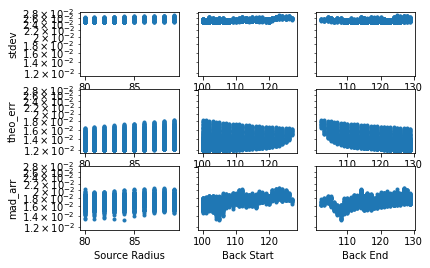

In [36]:
analysis.plot_apsizes('/home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP39b_SYS_sweep_aperture_sizing_NRCA3_WASP39b_SYS_2022_07_22_src_80_90_step_1_back_100_130_step_1.csv')

In [38]:
sweep_fine_results = pd.read_csv('/home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP39b_SYS_sweep_aperture_sizing_NRCA3_WASP39b_SYS_2022_07_22_src_80_90_step_1_back_100_130_step_1.csv')

MAD_min_idx = abs(sweep_fine_results[['mad_arr']]).idxmin()
print("Min MAD Results " + str(sweep_fine_results[['mad_arr']].idxmin()))
print(sweep_fine_results.iloc[MAD_min_idx])

print("THEO_ERR = "+str((0.0152/100)*10**6))
print("STDEV = "+str((0.0253/100)*10**6))
print("MAD*1.48 = "+str((0.0132/100)*1.48*10**6))

Min MAD Results mad_arr    1755
dtype: int64
       src  back_st  back_end   stdev  theo_err  mad_arr
1755  84.0    105.0     108.0  0.0253    0.0152   0.0132
THEO_ERR = 152.0
STDEV = 252.99999999999997
MAD*1.48 = 195.36


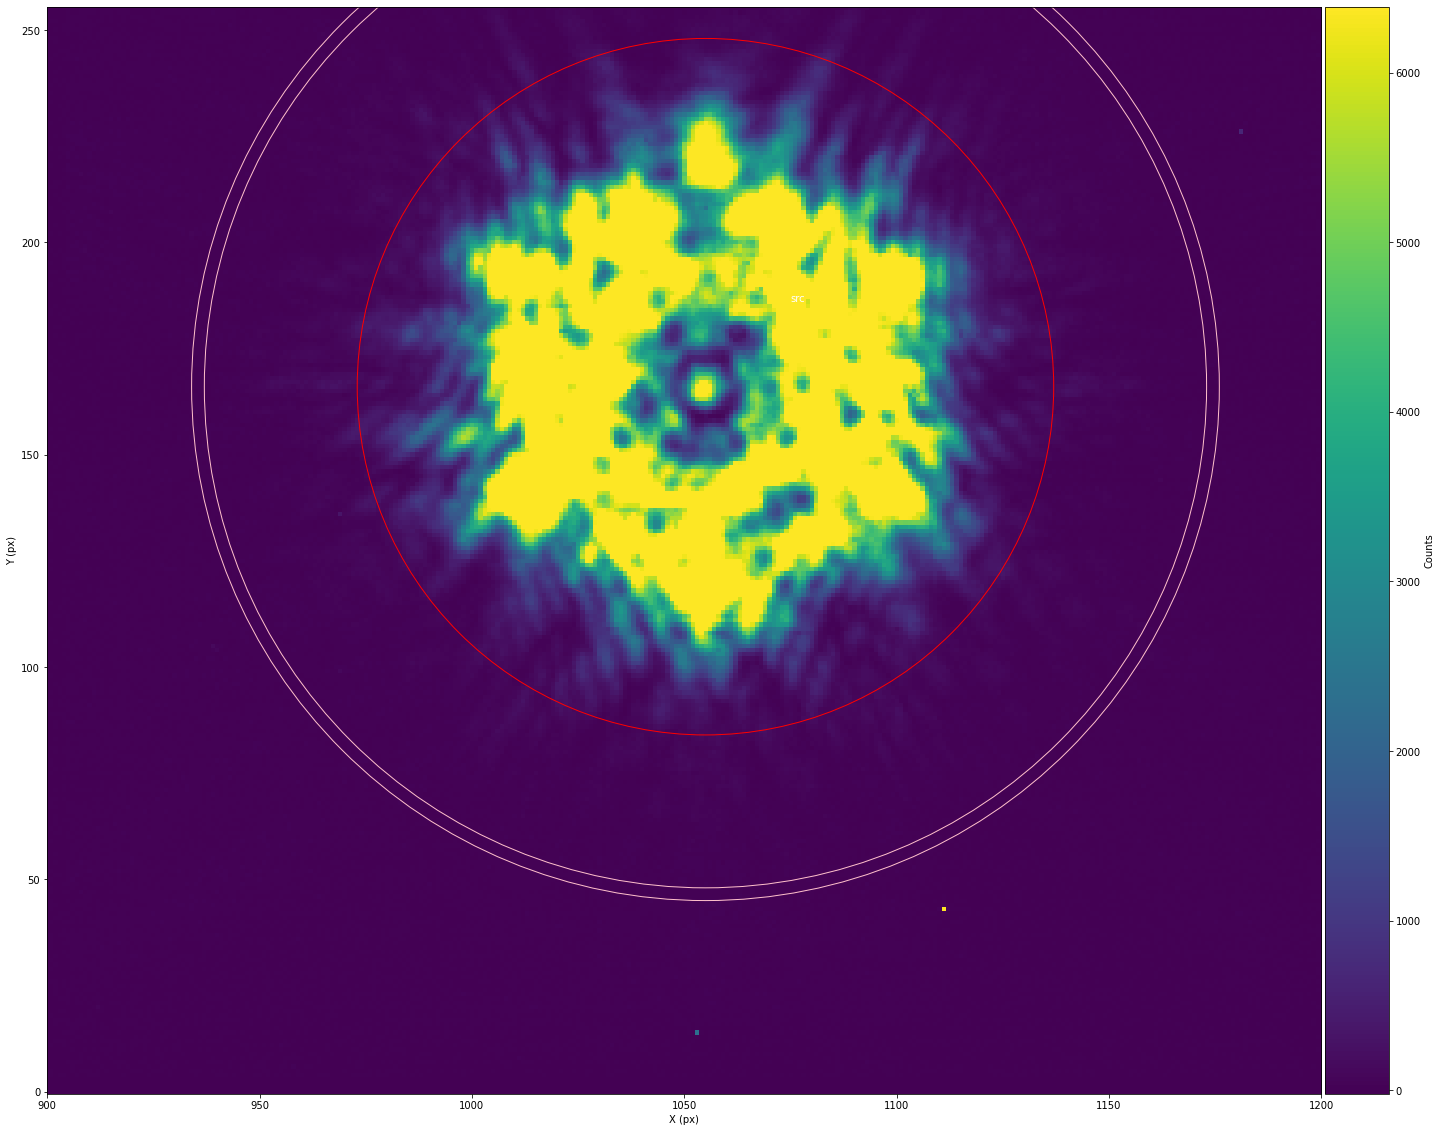

In [10]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/ROEBA/WASP39b_WLP8_NRCA3_ROEBA_phot_pipeline.yaml') #create a photometric object
alteredParam = deepcopy(phot.param)
alteredParam['srcGeometry']='Circular'
alteredParam['bkgGeometry'] = 'CircularAnnulus' #Changing the outer radius
alteredParam['backEnd'] = 121 #Changing the outer radius
alteredParam['apRadius'] = 82 #Changing the source radius
alteredParam['backStart'] = 118 #Changing the inner radius
alteredParam['bkgMethod'] ='mean'

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP39b_best' #provide a new name for centroid realignment

#Assignimg a object new phot2
phot_best = phot_pipeline.phot(directParam=alteredParam) #create new photometric object
#Assignimg a object phot
phot_best.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200]) #Plot the source and background subtraction area

In [11]:
phot_best.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot_best.do_phot(useMultiprocessing=True) #extract the photometric data

 10%|████                                      | 36/378 [00:01<00:13, 24.49it/s]2022-04-05 17:57:00,985 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 11%|████▍                                     | 40/378 [00:02<00:14, 23.95it/s]2022-04-05 17:57:01,263 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 14%|█████▉                                    | 53/378 [00:02<00:15, 20.46it/s]2022-04-05 17:57:01,908 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message

 75%|██████████████████████████████▌          | 282/378 [00:11<00:04, 21.80it/s]2022-04-05 17:57:10,943 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 77%|███████████████████████████████▌         | 291/378 [00:12<00:02, 32.34it/s]2022-04-05 17:57:11,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 78%|███████████████████████████████▉         | 295/378 [00:12<00:03, 26.45it/s]2022-04-05 17:57:11,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message

Tshirt Calculated Net Aperture Sum MAD (ppm): 122.59374169852676
Tshirt Calculated Net Aperture Sum std (ppm): 165.56688117405486
Median Relative Errors Net Aperture Sum (ppm): 143.1177016296774


<ErrorbarContainer object of 3 artists>

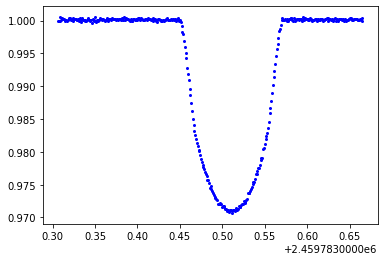

In [12]:
#Tshirt: net aperture
Flux_best, Flux_error_best = phot_best.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt_best = Flux_best['Flux 0']/Flux_best['Flux 0'][0] #normalized net aperture sum
std_tshirt_best = np.std(normalized_flux_tshirt_best[0:20]) #calculated standard deviation
relative_error_tshirt_best = (Flux_error_best['Error 0']/Flux_best['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt_best[0:seg01_len] - np.median(normalized_flux_tshirt_best[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt_best*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt_best)*10**6))

plt.errorbar(Flux_best['Time (JD)'],normalized_flux_tshirt_best,yerr=relative_error_tshirt_best,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

# Light Curve Modeling - Sweep Test

Planet Parameters: were kept hidden. However, a TSR member found: 
* t0: 0.009669611942651719
* inc: 88.0658045617915
* a: 11.450027574339222
* c0: 1.0070841238963764
* u1         1.20
* u2         -0.5


For planet WASP39b Filter NIRCam F210M the ExoCKT returns limb darkening parameters and corresponding errors: 
* c1 = 0.539;  e1 = 0.025	
* c2 = 0.21	; e2 = 0.059		
* c3 = -0.47;  e3 = 0.06		
* c4 = 0.199; e4 = 0.022

However, the modeling team made an error in the simulation and had a wavelength with the wrong units (2nm) when calculating the limb darkening law. Therefore, we will fit the light curve with a quadratic law and optimize u1 (c1) and u2 (c2). We will also start the fitting process by fixing some orbital parameters (period, a/R*, inclination, longitude of periastron, and eccentricity. These can later be optimized, but currently with curve_fit it gets stuck in some minima and does not perform the optimization of all these parameters. The following are the fixed values pulled from literature: 

* Period = 4.055259 (days) 
* a/R* = 11.612 (in units of stellar radii)
* Inclination = 87.93 (degrees)
* Longitude of Periastron = 88 (degrees, from TSR optimization)
* Eccentricity = 0 

The radius values pulled from literature are:
* R_p  = 1.27[Rj]	$\rightarrow$ 0.1305086[R☉]
* R_star = 0.9[R☉]
* R_p/R_star = 0.145

In [93]:
def transit_model(x, rp, A, t0, u1, u2):
    '''
    Models transit light curve using Python package `batman` based on initial parameters stored in params_transit.
    
    Parameters
    ----------
    
    x: array
        Time in Julian days  
    rp: int
        Planet-to-star radius ratio
    A: int
        Baseline Normalization Factor
    t0: int
        Time of inferior conjunction
    per: int
        Obital period
    a:int 
        Semi-major axis (in units of stellar radii)
    inc: int
        Inclination
    ecc: int
        Eccentricity of orbit
    w: int
        Longitude of Periastron (in degrees)
    u1,u2,u3,u4: int
        Limb darkening coeffcients 
    '''

    params_transit = batman.TransitParams()                   #Object to store transit parameters
    
    params_transit.t0 = t0                                              #time of inferior conjunction
    params_transit.per = 4.055259                                       #orbital period
    params_transit.a = 11.612                                           #semi-major axis (in units of stellar radii)
    params_transit.inc = 87.93                                          #orbital inclination (in degrees)
    params_transit.ecc = 0                                              #eccentricity
    params_transit.w =88                                                #longitude of periastron (in degrees)
    params_transit.limb_dark = "quadratic"                              #limb darkening model
    params_transit.u = [u1,u2]                            #limb darkening coefficients [u1, u2, u3, u4]
    
    params_transit.rp = rp                                    #Planet-to-star radius ratio - Will depend on function input
    
    #Modifying the time: Julian Date(x) - Initial Julian Date(x0) 
    x0 = np.min(x)
    m = batman.TransitModel(params_transit, x-x0)                #Initializes model
    
    flux = m.light_curve(params_transit)*A        #Calculate the light curve
    return flux

In [103]:
def lc_fitting(model, x, flux, sigma, rp, A, t0, u1, u2):
    '''
    Fits the light curve with scipy.curve_fit() and filters out outlier data
    
    Parameters
    ---------- 
    model:function
        Transit model function (batman)
    x: array
        Time in Julian days
    flux: array
        Array of fluxes from fine_sweep results
    sigma: array
        Array of flux errors from fine_sweep results
    rp: int
        Planet-to-star radius ratio
    A: int
        Baseline Normalization Factor
    t0: int
        Time of inferior conjunction
    per: int
        Orbital Period
    a:int 
        Semi-major axis (in units of stellar radii)
    inc: int
        Inclination
    ecc: int
        Eccentricity of orbit
    w: int
        Longitude of Periastron (in degrees)
    u1,u2,u3,u4: ints
        Limb darkening coefficients
    e1, e2, e3, e4: ints
        Limb darkening coefficients uncertainty
    '''
    
    quickfit = model(x, rp, A, t0, u1, u2) #Quickfit to the data based on initial guess values. 
    
    good_flux_points = [] #array for "good flux points"
    good_sigma_points = [] #array for the corresponding "good sigma points"
    good_time_points = []
    
    for i, j, k, l  in zip(flux, quickfit, sigma, x):
        residual = i - j #Calculate the residuals from the fine sweep results and initial light curve fit. 
        if (np.abs(residual) < 10*k)==True: #Define the "good point"; will exclude outliers 
            good_flux_points.append(i) #append the good flux values
            good_sigma_points.append(k) #append the good sigma values
            good_time_points.append(l) #append the good time values 
        else:
            None

    #Optimize the fit, only include the "good points"
    
    p0 = [rp, A, t0, u1, u2]#, u2, u3, u4] #Initial Guess values  
    #bounds =([0,0,0,0,u1-2*e1,u2-2*e2,u3-2*e3,u4-2*e4],[np.inf,np.inf,np.inf,np.inf,u1+2*e1,u2+2*e2,u3+2*e3,u4+2*e4]) #set upper and lower limits for all parameters. 
    #bounds =([0,0,0,0,u1-2*e1],[np.inf,np.inf,np.inf,np.inf,u1+2*e1]) #set upper and lower limits for all parameters. 
    bounds =([0,0,0,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf]) #set upper and lower limits for all parameters. Most importantly set the RECTE parameters limits to be within reason. 

    popt, pcov = curve_fit(model,good_time_points,good_flux_points,sigma=good_sigma_points,p0=p0, bounds=bounds)#, maxfev=10e6) 
    curvefit_uncertainty = np.sqrt(np.diag(pcov))
    
    print("Optimized Planet-to-star radius ratio (rp/r*) = " + str(popt[0]) + ' +/- ' + str(curvefit_uncertainty[0]))
    print("Optimized Baseline Normalization Factor = " + str(popt[1])+ ' +/- ' + str(curvefit_uncertainty[1]))
    print("Optimized Time of Inferior Conjunction = " + str(popt[2])+ ' +/- ' + str(curvefit_uncertainty[2]))
    #print("Optimized Orbital Period = " + str(popt[3])+ ' +/- ' + str(curvefit_uncertainty[3]))
    #print("Optimized Semi-major Axis (stellar radii) = " + str(popt[4])+ ' +/- ' + str(curvefit_uncertainty[4]))
    #print("Optimized inclination (degrees) = " + str(popt[5])+ ' +/- ' + str(curvefit_uncertainty[5]))
    #print("Optimized eccentricity = " + str(popt[6])+ ' +/- ' + str(curvefit_uncertainty[6]))
    #print("Optimized Longitude of Periastron (degrees) = " + str(popt[3])+ ' +/- ' + str(curvefit_uncertainty[3]))
    print("Optimized u1 = " + str(popt[3])+ ' +/- ' + str(curvefit_uncertainty[3]))
    print("Optimized u2 = " + str(popt[4])+ ' +/- ' + str(curvefit_uncertainty[4]))
    #print("Optimized u3 = " + str(popt[6])+ ' +/- ' + str(curvefit_uncertainty[6]))
    #print("Optimized u4 = " + str(popt[7])+ ' +/- ' + str(curvefit_uncertainty[7]))
    
    #plot the modeled light curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    
    #plot the good points model
    modeled_flux=model(good_time_points,*popt)
    ax2.plot(good_time_points,modeled_flux, markersize=5,color='red', label = 'Light Curve Model - Outliers Removed')
    
    #plot the quickfit model as a check:
    ax1.plot(x, quickfit, '--',label ='Quickfit Initial Check', color='green')
    
    #plot original data
    ax1.plot(x,flux,'.',alpha=0.1, label='Real Light Curve', color='blue')
    ax2.plot(x,flux,'.',alpha=0.1, label='Real Light Curve', color='blue')

    ax1.set_title("GJ436b Light Curve Model - Initial Check")
    ax2.set_title("GJ436b Light Curve Model")

    ax1.set_xlabel("Time (JD)")
    ax2.set_xlabel("Time (JD)")
    
    ax1.set_ylabel("Normalized Flux")
    ax2.set_ylabel("Normalized Flux")
    
    ax1.legend(loc="lower left")
    ax2.legend(loc="lower left")

    
    return popt, curvefit_uncertainty

Optimized Planet-to-star radius ratio (rp/r*) = 0.15546161239566397 +/- 0.000313890790456424
Optimized Baseline Normalization Factor = 1.0003878020852939 +/- 2.334635913070112e-05
Optimized Time of Inferior Conjunction = 0.20379679102166423 +/- 0.00011802111184340779
Optimized u1 = 1.233160231598571 +/- 0.04242619565553229
Optimized u2 = -0.7244056464495776 +/- 0.07256722236589208


(array([ 0.15546161,  1.0003878 ,  0.20379679,  1.23316023, -0.72440565]),
 array([3.13890790e-04, 2.33463591e-05, 1.18021112e-04, 4.24261957e-02,
        7.25672224e-02]))

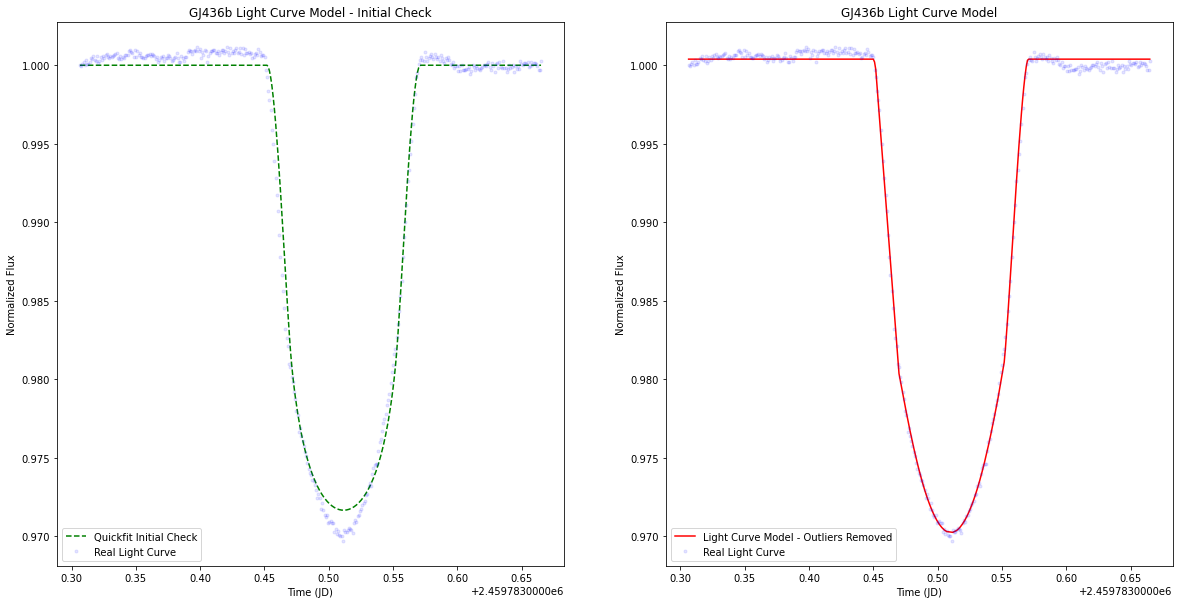

In [132]:
lc_fitting(transit_model,Flux_best['Time (JD)'],normalized_flux_tshirt_best, relative_error_tshirt_best, 0.15,1,0.205,0.5,0.5)

## Original Attempt

In [ ]:
#Simple curve_fit model to determine the best planet-to-star radius ratio. 
#bounds =([-np.inf,0,0,0,-3,-3,-3,-3],[np.inf,np.inf,np.inf,np.inf,3,3,3,3]) #set upper and lower limits for all parameters.
#p0=[0.2,1,0.01,22,0.5, 0.1, 0.1, -0.1]

#Linear
bounds =([0,0,0,0,-2,-2,0,0,0,0,-2,-2],[np.inf,np.inf,np.inf,np.inf,2,2,np.inf,180,1,90,2,2]) #set upper and lower limits for all parameters. Most importantly set the RECTE parameters limits to be within reason. 
p0=[0.2,1,0.009,22,0.5,0.5,10,88,0,90,0.5,0.5]
popt, pcov = curve_fit(transit_model,Flux_best['Time (JD)'],normalized_flux_tshirt_best,sigma=relative_error_tshirt_best,p0=p0, bounds=bounds) 

print("Optimized Planet-to-star radius ratio = " + str(popt[0]))
print("Optimized Baseline Normalization Factor = " + str(popt[1]))
print("Optimized Time of Inferior Conjunction = " + str(popt[2]))
print("Optimized Orbital Period = " + str(popt[3]))

print("Optimized u1 = " + str(popt[4]))
print("Optimized u2 = " + str(popt[5]))
print("Optimized a = " + str(popt[6]))
print("Optimized inc = " + str(popt[7]))
print("Optimized ecc = " + str(popt[8]))
print("Optimized w = " + str(popt[9]))
print("Optimized u3 = " + str(popt[10]))
print("Optimized u4 = " + str(popt[11]))

In [ ]:
#plot the modeled light curves
modeled_flux=transit_model(Flux_best['Time (JD)'], *popt)
t = Flux_best['Time (JD)'] 

plt.plot(t,modeled_flux, color='red')
plt.plot(t,normalized_flux_tshirt_best,'.',alpha=0.1)
plt.title("WASP39b Light Curve Model")
plt.xlabel("Time (JD)")
plt.ylabel("Normalized Flux")